# Modelling Carbon Capture and Energy Storage at Steady and Transient Operation

### Sunshine Tanphiphat
M Sc. Energy System,
Department of Engineering Science,
University of Oxford,

Supervisor: 
Prof. Budimir Rosic (Oxford Thermofluids Institute),
Prof. Aidong Yang (Oxford Agile Initiative)

2025

# Environment

## Clearing

In [1]:
%reset -f
from IPython.display import clear_output; clear_output(wait=True)
import matplotlib.pyplot as plt; plt.close('all')

## Simulation timer

In [2]:
import time              
_start_time = time.time() 

## Function Imports

In [3]:
from pathlib import Path
import time
from openpyxl import load_workbook

In [4]:
import os
import math
import pandas as pd
import numpy as np
import sympy as sp
import sys 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
from evalwitherrfun import eval_with_err
from addfun import add_fun
from subtractfun import subtract_fun
from multiplyfun import multiply_fun
from dividefun import divide_fun
from powerfun import power_fun

In [6]:
from getvaluefun import get_value
from getremainingthermovarsfun import get_remaining_thermo_vars
from gethfrometafun import get_h_from_eta
from getsolvedstatefun import get_solved_state

In [7]:
from getdepthfromTfun import get_depth_from_T
from callgetvaluefun import call_get_value
from getTfromdepthfun import get_T_from_depth

In [8]:
from getDutyfun import get_Duty
from getToutfun import get_Tout
from getToutstr2fun import get_Tout_str2
from Wfun import W_fun
from Qfun import Q_fun

In [9]:
from selectvaluecolumnsfun import select_value_columns
from quantvisfun import quant_vis
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

In [10]:
from findPbottomsecantfun import find_P_bottom_secant
from findpipediameterfun import find_pipe_diameter
from batchoptpipediameterfun import batch_opt_pipe_diameter

In [11]:
from getvisfun import get_vis
from secantsolvecompressibilityfun import secant_solve_compressibility_implicit
from operategeobatteryfun import operate_geobattery

In [12]:
from pathlib import Path
project_root = Path.cwd().parent     
input_dir    = project_root / 'Input_Spreadsheets'    
model_dir = project_root / 'Model_Files' 

# Inputs

## Global Inputs

### Simulation Round

In [13]:
simulation_name = 'TCCESUK'

### CGES Type

In [14]:
Working_fluid = 'CO2'
Cycle = 'TCCES'

### Toggles

In [15]:
# Allowable frictional loss MPa/m
gradP = 0.0001*2

In [16]:
# Storage Depths 
z_HS = 3000; # HS C.O.M. depth
z_LS = 200; # LS C.O.M. depth

In [17]:
min_HS_reg = gradP * 2 * z_HS; min_LS_reg = gradP * 2 * z_LS;
print(f'Minimum HS pressure regulation = {min_HS_reg} MPa, LS pressure regulation = {min_LS_reg} MPa')

Minimum HS pressure regulation = 1.2 MPa, LS pressure regulation = 0.08 MPa


In [18]:
HS_thrtl_deliberate = 5 # Deliberate turbine inlet pressure regulation
LS_thrtl_deliberate = 0.5 # Deliberate compressor inlet pressure regulation

In [19]:
HS_reg = min_HS_reg + HS_thrtl_deliberate; LS_reg = min_LS_reg + LS_thrtl_deliberate; 
print(f'Pressure regulation: HS {HS_reg} ΔMPa, LS {LS_reg} ΔMPa')

Pressure regulation: HS 6.2 ΔMPa, LS 0.58 ΔMPa


In [20]:
# Compression Train
P_0, P_0err = 1.5, 0 #MPa Compressor train inlet P (subcritical, critical = 7.40 MPa)
T_0, T_0err = 308, 0 #K Compressor train inlet T (supercritical, critical = 307.84 K)
P_max_c = 25
num_C = 3 #num Compressors in train
P_lift1ratio = 0.127234042553; P_lift2ratio = 0.380425531915; P_lift3ratio = 0.492340425532

In [21]:
# Expansion Distribution
num_T = 2 #num Turbines in train
P_drop1ratio = 0.41;

In [22]:
# Reheating
T_max = 873

In [23]:
# Nameplate capacity of wind farm kW
Nameplate_capacity = 100 * 1000 

# Power spot prices
elexon_df = pd.read_excel(input_dir/'ELEXON_SystemPrices_Jul_7_2019.xlsx'); SystemPrices_arr = elexon_df['System_price'].to_numpy(); assert SystemPrices_arr.shape[0] == 48, "Expected 48 half‐hourly prices"

# Wind generation
rn_df = pd.read_excel(input_dir/'RenewablesNinja_WindGeneration_Jul_7_2019.xlsx'); hourly_cf = rn_df['Capacity_factor'].to_numpy(); assert hourly_cf.shape[0] == 24, "Expected 24 hourly capacity factors"
CF_avg = hourly_cf.mean()

## Internal Parameters

### Geography

In [24]:
Patm = 0.101325 #MPa
Vrock_LS, Vrock_HS = 1e5, 1e5 #aquifer rock volume
z_S, z_Serr = 0, 0 #m
G, G_err = 0.025, 0 #K/m Geologic T gradient
Ts, Ts_err = 283, 0 #K Surface temperature
beta_p, beta_perr = 4.5*1e-10, 0 #Pa-1 Pore compressibility 
beta_w, beta_werr = 3.5*1e-10, 0 #Pa-1 Brine compressibility
p_w, p_werr = 1025, 0 # Surface brine density kg/m3
g, gerr = 9.81, 0 # Gravitational acceleration
por = 0.275 # Porosity
tol_P_storage = 0.025 #qausi-steady-state pressure deviation allowance frac

### Compression train

In [25]:
T_w, T_werr = 313, 0; #compressor inlet T
eta_C = 0.85 #frac Compressor isentropic efficiency
eta_grid_avg = 0.50 #frac baseload power plant efficiency

### Expansion train

In [26]:
eta_T = 0.87 #frac Turbine isentropic efficiency
eta_gen_avg = 0.476 #frac standalone generator efficiency
eta_burner_Gulen = 0.6815 #gas burner efficiency

### Transport 

In [27]:
m_CO2info=[1, 0]; m_CO2 = m_CO2info[0]; m_CO2err = m_CO2info[1] #Mass basis
r= 0.000045 #Conduit roughness m

### Thermodynamic Data

In [28]:
Thermodata_filename = f'../Input_Spreadsheets/Thermodata_{Working_fluid}'; df0 = pd.read_excel(f'{Thermodata_filename}.xlsx')

# Simulation

## Derived P

In [29]:
HS_fric = z_HS * gradP; HS_thrtl = HS_reg - 2*HS_fric; 
if HS_thrtl < 0: 
    print('HS Regulation Spares Insufficiently for Frictional Losses'); raise KeyboardInterrupt("Stopping execution")
LS_fric = z_LS * gradP; LS_thrtl = LS_reg - 2*LS_fric;
if LS_thrtl < 0: 
    print('LS Regulation Spares Insufficiently for Frictional Losses'); raise KeyboardInterrupt("Stopping execution")

In [30]:
P_lift = P_max_c - P_0; P_lift1 = P_lift1ratio*P_lift; P_lift2 = P_lift2ratio*P_lift; P_lift3 = P_lift3ratio*P_lift

In [31]:
P_inlet_t = P_max_c - HS_reg;
P_min_t = P_0 + LS_reg; 
P_drop = P_inlet_t - P_min_t; P_drop1 = P_drop1ratio*P_drop; P_drop2 = (1-P_drop1ratio)*P_drop

In [32]:
P1_d = P_0
P2_d = P1_d + P_lift1
P3_d = P2_d
P4_d = P3_d + P_lift2
P5_d = P4_d
P6_d = P5_d + P_lift3
P7_d = P6_d - HS_reg
P8_d = P7_d
P9_d = P8_d - P_drop1
P10_d = P9_d
P11_d = P10_d - P_drop2
P12_d = P11_d 
if P6_d == P_max_c:
    print('Compression pressure achieved')
else: 
    print('No')
if P12_d == P_0 + LS_reg:
    print('Cycle pressure calibrated')
else:
    print('No')

Compression pressure achieved
Cycle pressure calibrated


## Defining Stream State

In [33]:
df = pd.read_excel(input_dir/f'{Cycle}_Inputs.xlsx'); dfc = pd.read_excel(input_dir/f'Cycledata_{Cycle}.xlsx');

In [34]:
# Stream 1
stream_num = 1; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
df.loc[idx, ['P','Perr','T','Terr']] = [P1_d, 0, T_0, 0]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 1.000,2.000
interp T@1.500: -56.087±0.000
interp T@1.500: -62.963±0.000
→ -59.525±0.000
P interp bounds: 1.000,2.000
interp T@1.500: -0.572±0.000
interp T@1.500: -10.310±0.000
→ -5.441±0.000
P interp bounds: 1.000,2.000
interp T@1.500: -0.425±0.000
interp T@1.500: -0.579±0.000
→ -0.502±0.000
P interp bounds: 1.000,2.000
interp T@1.500: 266.252±0.000
interp T@1.500: 258.758±0.000
→ 262.505±0.000
P interp bounds: 1.000,2.000
interp T@1.500: 18.015±0.000
interp T@1.500: 37.989±0.000
→ 28.002±0.000
P interp bounds: 1.000,2.000
interp T@1.500: 0.688±0.000
interp T@1.500: 0.713±0.000
→ 0.700±0.000
P interp bounds: 1.000,2.000
interp T@1.500: 0.922±0.000
interp T@1.500: 1.009±0.000
→ 0.965±0.000


P interp bounds: 4.000,5.000
interp s@4.490: 57.813±0.000
interp s@4.490: 73.201±0.000
→ 65.353±0.000
Compressor: h_in=-5.441±0.000, h_iso=65.353±0.000, eta=0.850 → h_out=77.846±0.000


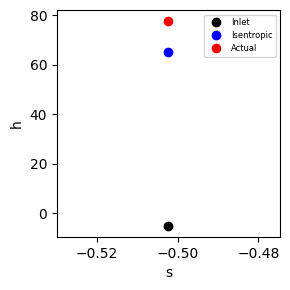

P interp bounds: 4.000,5.000
interp h@4.490: 407.314±0.000
interp h@4.490: 412.136±0.000
→ 409.677±0.000
P interp bounds: 4.000,5.000
interp h@4.490: 6.118±0.000
interp h@4.490: 6.275±0.000
→ 6.195±0.000
P interp bounds: 4.000,5.000
interp h@4.490: -0.452±0.000
interp h@4.490: -0.491±0.000
→ -0.471±0.000
P interp bounds: 4.000,5.000
interp h@4.490: 300.294±0.000
interp h@4.490: 300.528±0.000
→ 300.409±0.000
P interp bounds: 4.000,5.000
interp h@4.490: 55.778±0.000
interp h@4.490: 69.874±0.000
→ 62.685±0.000
P interp bounds: 4.000,5.000
interp h@4.490: 0.784±0.000
interp h@4.490: 0.794±0.000
→ 0.789±0.000
P interp bounds: 4.000,5.000
interp h@4.490: 1.058±0.000
interp h@4.490: 1.089±0.000
→ 1.073±0.000


In [35]:
# Stream 2
stream_num = 2; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P1, P1err, h1, h1err, s1, s1err = df.loc[idx-1, ['P', 'Perr','h','herr','s', 'serr']]; 
P2, P2err = P2_d, 0; h2,h2err=get_h_from_eta([P2, P2err],[h1,h1err],[s1, s1err],eta_C,'Compressor',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P2, P2err, h2, h2err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [36]:
# Stream 3
stream_num = 3; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P3, P3err = P3_d, 0; T3,T3err=[T_w,T_werr]
df.loc[idx, ['P','Perr','T','Terr']] = [P3, P3err, T3, T3err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 4.000,5.000
interp T@4.490: -74.596±0.000
interp T@4.490: -84.083±0.000
→ -79.245±0.000
P interp bounds: 4.000,5.000
interp T@4.490: -26.892±0.000
interp T@4.490: -39.923±0.000
→ -33.277±0.000
P interp bounds: 4.000,5.000
interp T@4.490: -0.745±0.000
interp T@4.490: -0.820±0.000
→ -0.782±0.000
P interp bounds: 4.000,5.000
interp T@4.490: 246.146±0.000
interp T@4.490: 237.594±0.000
→ 241.956±0.000
P interp bounds: 4.000,5.000
interp T@4.490: 83.872±0.000
interp T@4.490: 113.274±0.000
→ 98.279±0.000
P interp bounds: 4.000,5.000
interp T@4.490: 0.771±0.000
interp T@4.490: 0.808±0.000
→ 0.789±0.000
P interp bounds: 4.000,5.000
interp T@4.490: 1.255±0.000
interp T@4.490: 1.475±0.000
→ 1.363±0.000


P interp bounds: 10.000,15.000
interp s@13.430: 7.488±0.000
interp s@13.430: 31.292±0.000
→ 23.818±0.000
Compressor: h_in=-33.277±0.000, h_iso=23.818±0.000, eta=0.850 → h_out=33.893±0.000


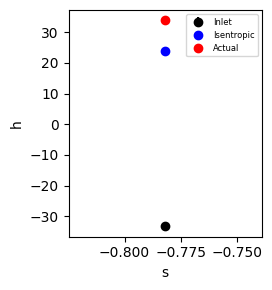

P interp bounds: 10.000,15.000
interp h@13.430: 398.946±0.000
interp h@13.430: 418.997±0.000
→ 412.701±0.000
P interp bounds: 10.000,15.000
interp h@13.430: -27.684±0.000
interp h@13.430: -28.849±0.000
→ -28.483±0.000
P interp bounds: 10.000,15.000
interp h@13.430: -0.714±0.000
interp h@13.430: -0.776±0.000
→ -0.756±0.000
P interp bounds: 10.000,15.000
interp h@13.430: 286.197±0.000
interp h@13.430: 301.107±0.000
→ 296.425±0.000
P interp bounds: 10.000,15.000
interp h@13.430: 162.442±0.000
interp h@13.430: 239.139±0.000
→ 215.056±0.000
P interp bounds: 10.000,15.000
interp h@13.430: 0.829±0.000
interp h@13.430: 0.858±0.000
→ 0.849±0.000
P interp bounds: 10.000,15.000
interp h@13.430: 1.338±0.000
interp h@13.430: 1.481±0.000
→ 1.436±0.000


In [37]:
# Stream 4
stream_num = 4; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P3, P3err, h3, h3err, s3, s3err = df.loc[idx-1, ['P', 'Perr','h','herr','s', 'serr']]; 
P4, P4err = P4_d, 0; h4,h4err=get_h_from_eta([P4, P4err],[h3,h3err],[s3, s3err],eta_C,'Compressor',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P4, P4err, h4, h4err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [38]:
# Stream 5
stream_num = 5; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P5, P5err = P5_d, 0; T5,T5err=[T_w,T_werr]
df.loc[idx, ['P','Perr','T','Terr']] = [P5, P5err, T5, T5err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 10.000,15.000
interp T@13.430: -209.270±0.000
interp T@13.430: -240.824±0.000
→ -230.916±0.000
P interp bounds: 10.000,15.000
interp T@13.430: -193.202±0.000
interp T@13.430: -221.612±0.000
→ -212.691±0.000
P interp bounds: 10.000,15.000
interp T@13.430: -1.381±0.000
interp T@13.430: -1.494±0.000
→ -1.459±0.000
P interp bounds: 10.000,15.000
interp T@13.430: 272.468±0.000
interp T@13.430: 428.490±0.000
→ 379.499±0.000
P interp bounds: 10.000,15.000
interp T@13.430: 625.920±0.000
interp T@13.430: 780.922±0.000
→ 732.251±0.000
P interp bounds: 10.000,15.000
interp T@13.430: 1.029±0.000
interp T@13.430: 0.933±0.000
→ 0.963±0.000
P interp bounds: 10.000,15.000
interp T@13.430: 5.796±0.000
interp T@13.430: 2.674±0.000
→ 3.654±0.000


P exact: 25.000
interp s@25.000: -197.606±0.000
Compressor: h_in=-212.691±0.000, h_iso=-197.606±0.000, eta=0.850 → h_out=-194.944±0.000


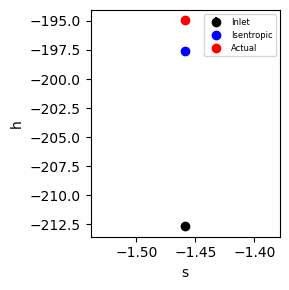

P exact: 25.000
interp h@25.000: 331.656±0.000
P exact: 25.000
interp h@25.000: -226.445±0.000
P exact: 25.000
interp h@25.000: -1.451±0.000
P exact: 25.000
interp h@25.000: 492.985±0.000
P exact: 25.000
interp h@25.000: 793.753±0.000
P exact: 25.000
interp h@25.000: 0.910±0.000
P exact: 25.000
interp h@25.000: 2.169±0.000


In [39]:
# Stream 6
stream_num = 6; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P5, P5err, h5, h5err, s5, s5err = df.loc[idx-1, ['P', 'Perr','h','herr','s', 'serr']]; 
P6, P6err = P6_d, 0; h6,h6err=get_h_from_eta([P6, P6err],[h5,h5err],[s5, s5err],eta_C,'Compressor',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P6, P6err, h6, h6err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [40]:
# Stream 7
stream_num = 7; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P7, P7err = P7_d, 0; h7, h7err = df.loc[idx-1, ['h','herr']]
df.loc[idx, ['P','Perr','h','herr']] = [P7, P7err, h7, h7err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 15.000,20.000
interp h@18.800: 322.393±0.000
interp h@18.800: 328.005±0.000
→ 326.658±0.000
P interp bounds: 15.000,20.000
interp h@18.800: -216.210±0.000
interp h@18.800: -221.425±0.000
→ -220.173±0.000
P interp bounds: 15.000,20.000
interp h@18.800: -1.410±0.000
interp h@18.800: -1.431±0.000
→ -1.426±0.000
P interp bounds: 15.000,20.000
interp h@18.800: 367.441±0.000
interp h@18.800: 432.469±0.000
→ 416.863±0.000
P interp bounds: 15.000,20.000
interp h@18.800: 705.896±0.000
interp h@18.800: 755.333±0.000
→ 743.468±0.000
P interp bounds: 15.000,20.000
interp h@18.800: 0.943±0.000
interp h@18.800: 0.920±0.000
→ 0.926±0.000
P interp bounds: 15.000,20.000
interp h@18.800: 3.019±0.000
interp h@18.800: 2.435±0.000
→ 2.575±0.000


In [41]:
# Stream 10
stream_num = 10; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P10, P10err, T10, T10err = P10_d, 0, T_max, 0 
df.loc[idx, ['P','Perr','T','Terr']] = [P10, P10err, T10, T10err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 10.000,15.000
interp T@11.945: 429.396±0.000
interp T@11.945: 424.301±0.000
→ 427.414±0.000
P interp bounds: 10.000,15.000
interp T@11.945: 597.107±0.000
interp T@11.945: 593.681±0.000
→ 595.774±0.000
P interp bounds: 10.000,15.000
interp T@11.945: 0.216±0.000
interp T@11.945: 0.133±0.000
→ 0.184±0.000
P interp bounds: 10.000,15.000
interp T@11.945: 454.755±0.000
interp T@11.945: 461.909±0.000
→ 457.538±0.000
P interp bounds: 10.000,15.000
interp T@11.945: 59.268±0.000
interp T@11.945: 88.834±0.000
→ 70.768±0.000
P interp bounds: 10.000,15.000
interp T@11.945: 1.011±0.000
interp T@11.945: 1.013±0.000
→ 1.012±0.000
P interp bounds: 10.000,15.000
interp T@11.945: 1.224±0.000
interp T@11.945: 1.237±0.000
→ 1.229±0.000


P interp bounds: 2.000,3.000
interp s@2.080: 340.914±0.000
interp s@2.080: 279.853±0.000
→ 336.030±0.000
Turbine: h_in=595.774±0.000, h_iso=336.030±0.000, eta=0.870 → h_out=369.796±0.000


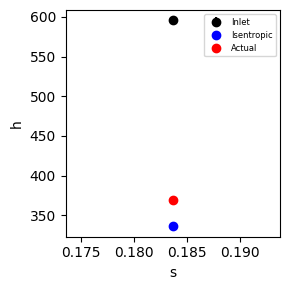

P interp bounds: 2.000,3.000
interp h@2.080: 672.854±0.000
interp h@2.080: 674.304±0.000
→ 672.970±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 242.862±0.000
interp h@2.080: 242.643±0.000
→ 242.844±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 0.227±0.000
interp h@2.080: 0.151±0.000
→ 0.221±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 392.328±0.000
interp h@2.080: 393.379±0.000
→ 392.412±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 15.758±0.000
interp h@2.080: 23.595±0.000
→ 16.385±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 0.927±0.000
interp h@2.080: 0.928±0.000
→ 0.927±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 1.125±0.000
interp h@2.080: 1.131±0.000
→ 1.125±0.000


In [42]:
# Stream 11
stream_num = 11; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']; 
P11,P11err= P11_d,0; h10, h10err = df.loc[idx-1, ['h','herr']]; s10, s10err = df.loc[idx-1, ['s','serr']]; h11,h11err=get_h_from_eta([P11, P11err],[h10,h10err],[s10, s10err],eta_T,'Turbine',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P11, P11err, h11, h11err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [43]:
# Stream 12
stream_num = 12; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']; 
P12, P12err = P12_d, 0; h12, h12err = df.loc[1-1, ['h','herr']];
df.loc[idx, ['P','Perr','h','herr']] = [P12, P12err, h12, h12err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 2.000,3.000
interp h@2.080: 312.842±0.000
interp h@2.080: 322.187±0.000
→ 313.589±0.000
P interp bounds: 2.000,3.000
interp h@2.080: -59.236±0.000
interp h@2.080: -58.733±0.000
→ -59.196±0.000
P interp bounds: 2.000,3.000
interp h@2.080: -0.563±0.000
interp h@2.080: -0.632±0.000
→ -0.569±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 261.447±0.000
interp h@2.080: 259.894±0.000
→ 261.323±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 37.183±0.000
interp h@2.080: 56.301±0.000
→ 38.712±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 0.714±0.000
interp h@2.080: 0.740±0.000
→ 0.716±0.000
P interp bounds: 2.000,3.000
interp h@2.080: 1.003±0.000
interp h@2.080: 1.083±0.000
→ 1.009±0.000


Final T=313.589±0.000
Total Q=-375.293276 ± 0.000000


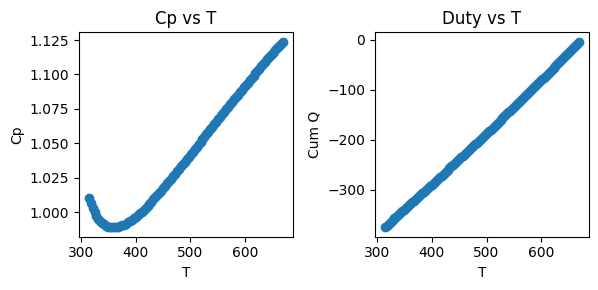

P interp bounds: 15.000,20.000
interp T@18.800: 3.195±0.000
interp T@18.800: 2.417±0.000
→ 2.604±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.216±0.000
interp T@18.800: 2.424±0.000
→ 2.614±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.236±0.000
interp T@18.800: 2.430±0.000
→ 2.624±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.236±0.000
interp T@18.800: 2.430±0.000
→ 2.624±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.256±0.000
interp T@18.800: 2.437±0.000
→ 2.633±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.276±0.000
interp T@18.800: 2.443±0.000
→ 2.643±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.276±0.000
interp T@18.800: 2.443±0.000
→ 2.643±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.297±0.000
interp T@18.800: 2.450±0.000
→ 2.653±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.317±0.000
interp T@18.800: 2.457±0.000
→ 2.663±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 3.317±0.000
interp T@18.8

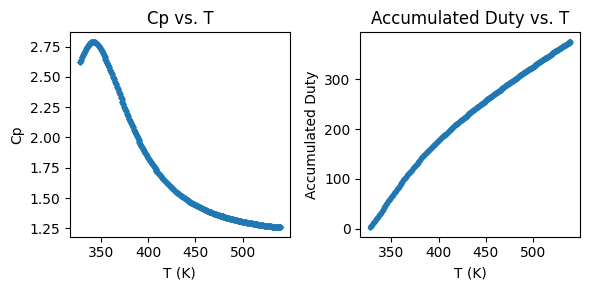

P interp bounds: 15.000,20.000
interp T@18.800: 93.526±0.000
interp T@18.800: 82.450±0.000
→ 85.108±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 189.794±0.000
interp T@18.800: 178.022±0.000
→ 180.847±0.000
P interp bounds: 15.000,20.000
interp T@18.800: -0.447±0.000
interp T@18.800: -0.521±0.000
→ -0.503±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 357.919±0.000
interp T@18.800: 366.075±0.000
→ 364.118±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 155.972±0.000
interp T@18.800: 209.515±0.000
→ 196.665±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 0.883±0.000
interp T@18.800: 0.893±0.000
→ 0.890±0.000
P interp bounds: 15.000,20.000
interp T@18.800: 1.214±0.000
interp T@18.800: 1.271±0.000
→ 1.257±0.000


In [44]:
# Stream 8
stream_num = 8; idx = stream_num - 1 
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']; 
P8, P8err = P8_d, 0;
P11, P11err, T11, T11err = df.loc[11-1,['P', 'Perr','T','Terr']]; T12, T12err = df.loc[12-1,['T','Terr']]; HEX_Duty, HEX_Dutyerr = get_Duty([P11, P11err], [T11, T11err], [T12, T12err], m_CO2info,Thermodata_filename); Q_recuped = HEX_Duty;
P7, P7err, T7, T7err = df.loc[7-1,['P','Perr','T','Terr']];T8, T8err = get_Tout([P7, P7err], [T7, T7err], [-1*HEX_Duty, HEX_Dutyerr],  m_CO2info,Thermodata_filename)
df.loc[idx, ['P','Perr','T','Terr']] = [P8, P8err, T8, T8err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 10.000,15.000
interp s@11.945: 125.569±0.000
interp s@11.945: 160.560±0.000
→ 139.179±0.000
Turbine: h_in=180.847±0.000, h_iso=139.179±0.000, eta=0.870 → h_out=144.596±0.000


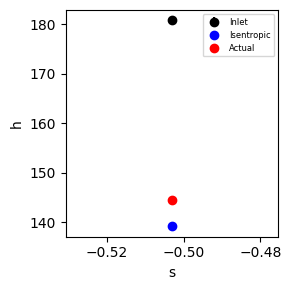

P interp bounds: 10.000,15.000
interp h@11.945: 489.347±0.000
interp h@11.945: 502.374±0.000
→ 494.414±0.000
P interp bounds: 10.000,15.000
interp h@11.945: 58.731±0.000
interp h@11.945: 57.658±0.000
→ 58.314±0.000
P interp bounds: 10.000,15.000
interp h@11.945: -0.463±0.000
interp h@11.945: -0.534±0.000
→ -0.491±0.000
P interp bounds: 10.000,15.000
interp h@11.945: 332.871±0.000
interp h@11.945: 342.514±0.000
→ 336.622±0.000
P interp bounds: 10.000,15.000
interp h@11.945: 116.463±0.000
interp h@11.945: 172.619±0.000
→ 138.305±0.000
P interp bounds: 10.000,15.000
interp h@11.945: 0.851±0.000
interp h@11.945: 0.870±0.000
→ 0.858±0.000
P interp bounds: 10.000,15.000
interp h@11.945: 1.167±0.000
interp h@11.945: 1.242±0.000
→ 1.197±0.000


In [45]:
# Stream 9
stream_num = 9; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']; 
P9, P9err = P9_d,0; h8, h8err = df.loc[idx-1, ['h','herr']]; s8, s8err = df.loc[idx-1, ['s','serr']]; h9,h9err=get_h_from_eta([P9, P9err],[h8,h8err],[s8, s8err],eta_T,'Turbine',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P9, P9err, h9, h9err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

## Exergy Analysis

### Stream Exergy

In [46]:
df['ex'] = df['h'] - Ts * df['s']; df['exerr'] = np.sqrt(df['herr']**2 + (Ts * df['serr'])**2)
for idx, row in dfc.iterrows():
    start_val = row['Start_stream']; end_val   = row['End_stream']
    start_ex,     start_ex_err = get_solved_state(start_val, df, 'ex'); end_ex,       end_ex_err   = get_solved_state(end_val,   df, 'ex')
    change_ex, change_ex_err = subtract_fun(end_ex, end_ex_err, start_ex, start_ex_err)
    dfc.loc[idx, ['Start_ex', 'Start_ex_err','End_ex','End_ex_err','Change_ex','Change_ex_err']] = (start_ex, start_ex_err, end_ex, end_ex_err,change_ex, change_ex_err)

### Component Exergy Changes

Final T=873.000±0.000
Total Q=451.231159 ± 0.000000


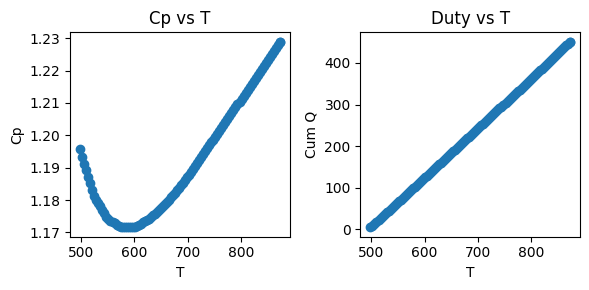

In [47]:
for idx, row in dfc.iterrows():
    start = row['Start_stream']; end = row['End_stream']
    for src_col, tgt_col, tgt_err_col in [('Fuel_exergy',    'EX_F',   'EX_F_err'),('Product_exergy', 'EX_P',   'EX_P_err')]:
        ex_type = str(row[src_col]).lower() 
        if ex_type == 'w':
            w, werr = W_fun(df, start, end); dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = w, werr
        elif ex_type == 'q':
            q, qerr = Q_fun(df, start, end, m_CO2info, Thermodata_filename); dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = q, qerr
        elif ex_type == 'start_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['Start_ex'], row['Start_ex_err']
        elif ex_type == 'end_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['End_ex'], row['End_ex_err']
        elif ex_type == 'change_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['Change_ex'], row['Change_ex_err']
        else:
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = np.nan, np.nan

In [48]:
cold_tube_num = dfc.index[dfc['Component'] == 'TUBE_T'][0]; hot_tube_num  = dfc.index[dfc['Component'] == 'TUBE_LS'][0]; hex_num = dfc.index[dfc['Component'] == 'HEX'][0]
hot_ex     = dfc.at[hot_tube_num, 'Change_ex']; hot_ex_err = dfc.at[hot_tube_num, 'Change_ex_err']; cold_ex    = dfc.at[cold_tube_num, 'Change_ex']; cold_ex_err= dfc.at[cold_tube_num, 'Change_ex_err']
dfc.loc[hex_num, ['EX_F','EX_F_err','EX_P','EX_P_err']] = [-hot_ex,-hot_ex_err, cold_ex, cold_ex_err]


In [49]:
for idx, row in dfc.iterrows():
    ex_d, ex_d_err = subtract_fun(abs(row['EX_F']), abs(row['EX_F_err']), abs(row['EX_P']), abs(row['EX_P_err']))
    if ex_d < 0:
        ex_d, ex_d_err = 0.0, ex_d_err
    dfc.loc[idx, ['EX_D', 'EX_D_err']] = (ex_d, ex_d_err)

mask_P = dfc['EX_P'].notna(); EX_P_T = abs(dfc.loc[mask_P, 'EX_P']).sum(); EX_P_T_err = np.sqrt((dfc.loc[mask_P, 'EX_P_err']**2).sum())

mask_F = dfc['EX_F'].notna(); EX_F_T = abs(dfc.loc[mask_F, 'EX_F']).sum(); EX_F_T_err = np.sqrt((dfc.loc[mask_F, 'EX_F_err']**2).sum())

mask_D = dfc['EX_D'].notna(); EX_D_T = abs(dfc.loc[mask_D, 'EX_D']).sum(); EX_D_T_err = np.sqrt((dfc.loc[mask_D, 'EX_D_err']**2).sum())

dfc.loc[mask_D, ['EX_D_ratio', 'EX_D_ratio_err']] = [divide_fun(d, de, EX_D_T, EX_D_T_err) for d, de in zip(dfc.loc[mask_D, 'EX_D'], dfc.loc[mask_D, 'EX_D_err'])]

In [50]:
W_C1   = abs(dfc.loc[dfc['Component']=='C1',  'EX_F'].iloc[0])
W_C2   = abs(dfc.loc[dfc['Component']=='C2',  'EX_F'].iloc[0])
W_C3   = abs(dfc.loc[dfc['Component']=='C3',  'EX_F'].iloc[0])
W_C    = W_C1 + W_C2 + W_C3

In [51]:
W_T1   = abs(dfc.loc[dfc['Component']=='T1',  'EX_P'].iloc[0])
W_T2   = abs(dfc.loc[dfc['Component']=='T2',  'EX_P'].iloc[0])
W_T    = W_T1 + W_T2

In [52]:
Q_HE   = abs(dfc.loc[dfc['Component']=='HE',  'EX_F'].iloc[0])
Q_F = Q_HE/eta_burner_Gulen

In [53]:
Q_ICL1 = abs(dfc.loc[dfc['Component']=='ICL1',  'Change_ex'].iloc[0])
Q_ICL2 = abs(dfc.loc[dfc['Component']=='ICL2',  'Change_ex'].iloc[0])
Q_ICL = Q_ICL1 + Q_ICL2

In [54]:
RTE_Liu = W_T/(W_C + eta_gen_avg*Q_HE)
RTE_Gulen = W_T/(W_C + eta_gen_avg*Q_F)
RTE_alt_F = (W_T-eta_gen_avg*Q_F)/W_C
RTE_alt_HE = (W_T-eta_gen_avg*Q_HE)/W_C

In [55]:
PEE = W_T/((W_C/eta_grid_avg) + Q_F)
ER = W_C/W_T
HR = W_T/Q_F

In [56]:
EXD_C    = dfc.loc[dfc['Component'].isin(['C1','C2','C3']), 'EX_D'].sum();   EXDR_C  = EXD_C/EX_D_T
EXD_T    = dfc.loc[dfc['Component'].isin(['T1','T2']),   'EX_D'].sum();   EXDR_T  = EXD_T/EX_D_T
EXD_HS   = dfc.loc[dfc['Component'].isin(['HS']),  'EX_D'].sum();   EXDR_HS = EXD_HS/EX_D_T
EXD_LS   = dfc.loc[dfc['Component'].isin(['LS']),  'EX_D'].sum();   EXDR_LS = EXD_LS/EX_D_T
EXD_HE   = dfc.loc[dfc['Component'].isin(['HE']),       'EX_D'].sum();   EXDR_HE = EXD_HE/EX_D_T
EXD_HEX  = dfc.loc[dfc['Component'].isin(['HEX']),      'EX_D'].sum();   EXDR_HEX= EXD_HEX/EX_D_T

In [57]:
EX_EFF = EX_P_T/EX_F_T

## Storage Analysis

### HS Storage

In [58]:
# HS wells indexing
HS_num = dfc.index[dfc['Component'] == 'HS'][0]; HS_start = dfc['Start_stream'][HS_num]; HS_end = dfc['End_stream'][HS_num];
HS_inj_well = df.loc[df['Stream_#'] == HS_start]; HS_prod_well = df.loc[df['Stream_#'] == HS_end];

Interpolated in T at exact P=25.0 (Sheet: Sheet1)
  T bounds and viscosities: 320.0→80.39, 340.0→64.45
Temperature = 358.000 +/- 0.000 K at depth 3000.0 +/- 0.0 m
P interp bounds: 30.000,40.000
interp T@38.000: 725.036±0.000
interp T@38.000: 806.928±0.000
→ 790.550±0.000
P exact: 40.000
interp T@40.000: 806.928±0.000
P interp bounds: 40.000,50.000
interp T@49.726: 806.928±0.000
interp T@49.726: 861.776±0.000
→ 860.272±0.000
P interp bounds: 40.000,50.000
interp T@49.305: 806.928±0.000
interp T@49.305: 861.776±0.000
→ 857.963±0.000
P interp bounds: 40.000,50.000
interp T@49.305: 806.928±0.000
interp T@49.305: 861.776±0.000
→ 857.963±0.000
Final iteration results:
  P_guess     = 49.304800 MPa
  P_calc      = 49.304800 MPa
  Error       = -7.11e-15 MPa
  rho_bottom  = 857.962965 kg/m³
  rho_avg     = 825.857954 kg/m³


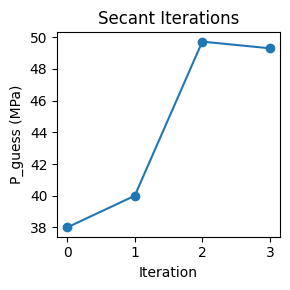

Interpolated in P and T (Sheet: Sheet1)
  P bounds and viscosities at T bounds:
    P=45.0: T=340.0→90.06, T=360.0→77.85
    P=50.0: T=340.0→95.21, T=360.0→82.77
  Final interpolation at P=49.304799585786476, T=358.0: 83.32672487050851
P interp bounds: 40.000,50.000
interp T@49.305: -205.522±0.000
interp T@49.305: -217.848±0.000
→ -216.991±0.000
P interp bounds: 40.000,50.000
interp T@49.305: -155.936±0.000
interp T@49.305: -159.818±0.000
→ -159.548±0.000
P interp bounds: 40.000,50.000
interp T@49.305: -1.392±0.000
interp T@49.305: -1.436±0.000
→ -1.433±0.000
P interp bounds: 40.000,50.000
interp T@49.305: 563.246±0.000
interp T@49.305: 641.746±0.000
→ 636.289±0.000
P interp bounds: 40.000,50.000
interp T@49.305: 806.928±0.000
interp T@49.305: 861.776±0.000
→ 857.963±0.000
P interp bounds: 40.000,50.000
interp T@49.305: 0.903±0.000
interp T@49.305: 0.905±0.000
→ 0.905±0.000
P interp bounds: 40.000,50.000
interp T@49.305: 1.852±0.000
interp T@49.305: 1.748±0.000
→ 1.755±0.000
Interpolat

In [59]:
# HS injection well
P_HS_inj = HS_inj_well['P'].iloc[0]; T_HS_inj = HS_inj_well['T'].iloc[0];
p_HS_inj = HS_inj_well['p'].iloc[0]; vis_HS_inj = get_vis(P = P_HS_inj, T = T_HS_inj, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS_inj = vis_HS_inj*(1e-6)

# HS 
T_HS, T_HSerr = get_T_from_depth(z_HS, 0, Ts, G)
P_HS, pavg_HS_inj, p_HS = find_P_bottom_secant(T_aquifer=T_HS,z_aquifer=z_HS,Ptop=P_HS_inj,g=g,fric_rate=gradP, rho_top=p_HS_inj, thermo_file=Thermodata_filename, P0=38.0, P1=40.0, tol=1e-6,max_iter=500)
vis_HS = get_vis(P = P_HS, T = T_HS, near_critical_point = 'N',filename= f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS = vis_HS*(1e-6); visavg_HS_inj = 0.5*(vis_HS_inj + vis_HS)
n_rows = df.shape[0];idx = n_rows; df.loc[idx,['Definer_1','Definer_2']] = ['P','T']; df.loc[idx, ['P','Perr','T','Terr']] = [P_HS, 0, T_HS, 0]; get_remaining_thermo_vars(idx, df, Thermodata_filename); 
df.loc[idx,['Stream_#','From_component', 'To_component']] = [HS_start+0.5, 'HS_inj_well', 'HS_prod_well'];

# HS production well
P_HS_prod = HS_prod_well['P'].iloc[0]; T_HS_prod = HS_prod_well['T'].iloc[0]; p_HS_prod = HS_prod_well['p'].iloc[0]; vis_HS_prod = get_vis(P = P_HS_prod, T = T_HS_prod, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS_prod = vis_HS_prod*(1e-6)
pavg_HS_prod = 0.5*(p_HS_prod + p_HS); visavg_HS_prod = 0.5*(vis_HS_prod + vis_HS)

### LS Storage

In [60]:
# LS wells indexing
LS_num = dfc.index[dfc['Component'] == 'LS'][0]; LS_start = dfc['Start_stream'][LS_num]; LS_end = dfc['End_stream'][LS_num];
LS_inj_well = df.loc[df['Stream_#'] == LS_start]; LS_prod_well = df.loc[df['Stream_#'] == LS_end];

Interpolated in P and T (Sheet: Sheet1)
  P bounds and viscosities at T bounds:
    P=1.0: T=300.0→15.11, T=320.0→16.07
    P=2.5: T=300.0→15.41, T=320.0→16.32
  Final interpolation at P=2.08, T=313.589278931104: 15.953824686617004
Temperature = 288.000 +/- 0.000 K at depth 200.0 +/- 0.0 m
P exact: 3.000
interp T@3.000: 68.551±0.000
P exact: 1.000
interp T@1.000: 19.515±0.000
P interp bounds: 2.000,3.000
interp T@2.165: 41.887±0.000
interp T@2.165: 68.551±0.000
→ 46.285±0.000
P interp bounds: 2.000,3.000
interp T@2.163: 41.887±0.000
interp T@2.163: 68.551±0.000
→ 46.237±0.000
P interp bounds: 2.000,3.000
interp T@2.163: 41.887±0.000
interp T@2.163: 68.551±0.000
→ 46.237±0.000
P interp bounds: 2.000,3.000
interp T@2.163: 41.887±0.000
interp T@2.163: 68.551±0.000
→ 46.237±0.000
Final iteration results:
  P_guess     = 2.163135 MPa
  P_calc      = 2.163135 MPa
  Error       = 0.00e+00 MPa
  rho_bottom  = 46.236632 kg/m³
  rho_avg     = 42.474524 kg/m³


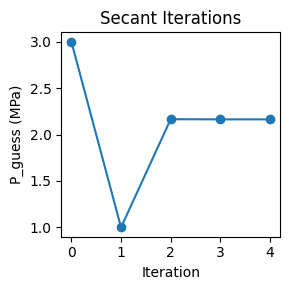

Interpolated in P and T (Sheet: Sheet1)
  P bounds and viscosities at T bounds:
    P=1.0: T=280.0→14.15, T=300.0→15.11
    P=2.5: T=280.0→14.51, T=300.0→15.41
  Final interpolation at P=2.1631350162071024, T=288.0: 14.79454224363039
P interp bounds: 2.000,3.000
interp T@2.163: -78.583±0.000
interp T@2.163: -88.433±0.000
→ -80.190±0.000
P interp bounds: 2.000,3.000
interp T@2.163: -30.828±0.000
interp T@2.163: -44.657±0.000
→ -33.084±0.000
P interp bounds: 2.000,3.000
interp T@2.163: -0.648±0.000
interp T@2.163: -0.761±0.000
→ -0.666±0.000
P interp bounds: 2.000,3.000
interp T@2.163: 246.758±0.000
interp T@2.163: 235.690±0.000
→ 244.952±0.000
P interp bounds: 2.000,3.000
interp T@2.163: 41.887±0.000
interp T@2.163: 68.551±0.000
→ 46.237±0.000
P interp bounds: 2.000,3.000
interp T@2.163: 0.712±0.000
interp T@2.163: 0.760±0.000
→ 0.720±0.000
P interp bounds: 2.000,3.000
interp T@2.163: 1.048±0.000
interp T@2.163: 1.249±0.000
→ 1.081±0.000
Interpolated in P and T (Sheet: Sheet1)
  P bound

In [61]:
# LS injection well
P_LS_inj = LS_inj_well['P'].iloc[0]; T_LS_inj = LS_inj_well['T'].iloc[0];
p_LS_inj = LS_inj_well['p'].iloc[0]; vis_LS_inj = get_vis(P = P_LS_inj, T = T_LS_inj, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_LS_inj = vis_LS_inj*(1e-6)

# LS
T_LS, T_LSerr = get_T_from_depth(z_LS, 0, Ts, G)
P_LS, pavg_LS_inj, p_LS = find_P_bottom_secant(T_aquifer=T_LS,z_aquifer=z_LS,Ptop=P_LS_inj,g=g,fric_rate=gradP, rho_top=p_LS_inj, thermo_file=Thermodata_filename, P0=3, P1=1, tol=1e-6,max_iter=500)
vis_LS = get_vis(P = P_LS, T = T_LS, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_LS = vis_LS*(1e-6); visavg_LS_inj = 0.5*(vis_LS_inj + vis_LS)
n_rows = df.shape[0];idx = n_rows; df.loc[idx,['Definer_1','Definer_2']] = ['P','T'];  df.loc[idx, ['P','Perr','T','Terr']] = [P_LS, 0, T_LS, 0]; get_remaining_thermo_vars(idx, df, Thermodata_filename); 
df.loc[idx,['Stream_#','From_component', 'To_component']] = [LS_start+0.5, 'LS_inj_well', 'LS_prod_well'];

# LS production well
P_LS_prod = LS_prod_well['P'].iloc[0]; T_LS_prod = HS_prod_well['T'].iloc[0]; p_LS_prod = LS_prod_well['p'].iloc[0]; vis_LS_prod = get_vis(P = P_LS_prod, T = T_LS_prod, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_LS_prod = vis_LS_prod*(1e-6)
pavg_LS_prod = 0.5*(p_LS_prod + p_LS); visavg_LS_prod = 0.5*(vis_LS_prod + vis_LS)

## Frictional Analysis

### HS Injection Well

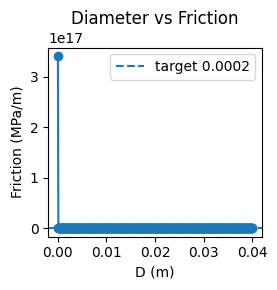

Final diameter: 0.040010 m
Final friction: 0.000200 MPa/m


In [62]:
D0_HS_inj_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_inj,mass_rate=m_CO2,mu_avg=visavg_HS_inj,D_guess=1e-5,roughness=r, D_step=1e-4)
dfDm_HS_inj_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_inj,mu_avg=visavg_HS_inj,D_start=1e-5,roughness=r, D_step=1e-4)

### HS Production Well

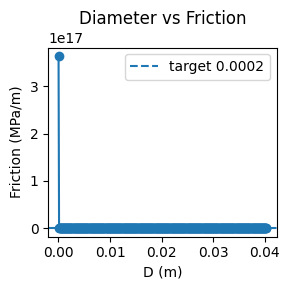

Final diameter: 0.040310 m
Final friction: 0.000198 MPa/m


In [63]:
D0_HS_prod_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_prod,mass_rate=m_CO2,mu_avg=visavg_HS_prod,D_guess=1e-5,roughness=r, D_step=1e-4)
dfDm_HS_prod_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_prod,mu_avg=visavg_HS_prod,D_start=1e-5,roughness=r, D_step=1e-4)

### LS Injection Well

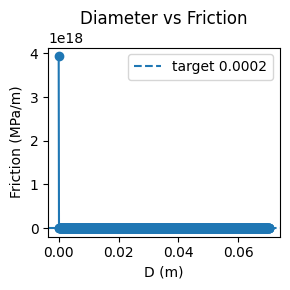

Final diameter: 0.070410 m
Final friction: 0.000199 MPa/m


In [64]:
D0_LS_inj_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_LS_inj,mass_rate=m_CO2,mu_avg=visavg_LS_inj,D_guess=1e-5,roughness=r, D_step=1e-4)
dfDm_LS_inj_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_LS_inj,mu_avg=visavg_LS_inj,D_start=1e-5,roughness=r, D_step=1e-4)

### LS Production Well

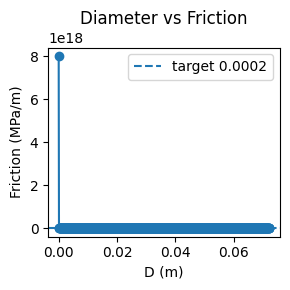

Final diameter: 0.072210 m
Final friction: 0.000200 MPa/m


In [65]:
D0_LS_prod_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_LS_prod,mass_rate=m_CO2,mu_avg=visavg_LS_prod,D_guess=1e-5,roughness=r, D_step=1e-4)
dfDm_LS_prod_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_LS_prod,mu_avg=visavg_LS_prod,D_start=1e-5,roughness=r, D_step=1e-4)

## Quasi-Steady-State Analysis

In [66]:
# Steady state parameters
P_HS_ss = P_HS; p_HS_ss = p_HS; P_LS_ss = P_LS; p_LS_ss = p_LS; 

In [67]:
#Dispatch parameters
PPA = Nameplate_capacity*CF_avg; #PPA derated by mean capacity factor of wind farm
beta_w_MPa = beta_w*(1e6); beta_p_MPa = beta_p*(1e6) #Pa-1 to MPa-1
SystemPrices_arr = SystemPrices_arr*0.001; #£/MWh to £/kWh
CapacityFactors_arr = np.repeat(hourly_cf, 2); assert CapacityFactors_arr.shape[0] == 48, "Expected 48 half‐hourly capacity factors"; #Capacity factor per settlement period
Generation_arr = Nameplate_capacity*CapacityFactors_arr #Generation per settlement period kW

In [68]:
# Full-cycle pressure swing 
M = PPA/min(W_T,W_C)
deltaP_HS_full_cycle = tol_P_storage*P_HS_ss*(1e6); V_HS = M/(deltaP_HS_full_cycle * p_HS_ss * (beta_p + beta_w)); V_HS_ss = V_HS;
deltaP_LS_full_cycle = tol_P_storage*P_LS_ss*(1e6); V_LS = M/(deltaP_LS_full_cycle * p_LS_ss * (beta_p + beta_w)); V_LS_ss = V_LS;
E_V =0.5*W_T*(beta_p + beta_w)*(p_LS_ss*deltaP_LS_full_cycle + p_HS_ss*deltaP_HS_full_cycle)

In [69]:
initialconditions, timeseries = operate_geobattery(
    Vrock_LS                = Vrock_LS,                  # m³ rock in LS
    Vrock_HS                = Vrock_HS,                  # m³ rock in HS
    phi                     = por,                   # porosity (−)
    b_pore                  = beta_p_MPa,                   # rock compressibility (1/MPa)
    b_brine                 = beta_w_MPa,                  # brine compressibility (1/MPa)
    z_LS                    = z_LS,                  # m depth of LS
    z_HS                    = z_HS,                 # m depth of HS
    P_LS_ss                 = P_LS_ss,                    # MPa steady LS pressure
    P_HS_ss                 = P_HS_ss,                   # MPa steady HS pressure
    rho_co2_LS_ss           = p_LS_ss,                  # kg/m³ CO₂ @ 2 MPa
    rho_co2_HS_ss           = p_HS_ss,                  # kg/m³ CO₂ @ 40 MPa
    rho_brine_0             = p_w,                 # kg/m³ surface brine density
    T_LS                    = T_LS,                 # K reservoir temperature LS
    T_HS                    = T_HS,                 # K reservoir temperature HS
    thermo_file             = Thermodata_filename,         # path to EOS file
    stable_power_requirement= PPA,                  # kW constant load
    W_turbine_T             = W_T,                    # kWh per kg CO₂ through turbine
    W_compressor_T          = W_C,                    # kWh per kg CO₂ through compressor
    power_rating            = PPA,                 # kW max charge/discharge
    dt                      = 1.0,                    # hr per timestep
    price                   = SystemPrices_arr,    # $/kWh
    generation              = Generation_arr,# kW available
    pressure_tolerance      = tol_P_storage,                  # ±1.5% allowable swing
    pressure_buffer_fraction= 0.25                    # buffer fraction
)

dfQSS = pd.DataFrame(timeseries)
dfQSS0 = pd.DataFrame(initialconditions)

In [70]:
dfQSS.columns

Index(['mode', 'residual', 'charge', 'charge_mass_co2',
       'pressure_constraint_mass_co2', 'power_constraint', 'deltaM_co2_LS',
       'deltaM_co2_HS', 'M_co2_LS', 'M_co2_HS', 'M_br_LS', 'M_br_HS',
       'pore_gain_LS', 'pore_gain_HS', 'extra_cap_LS', 'extra_cap_HS',
       'brine_shrink_LS', 'brine_shrink_HS', 'Vp_LS', 'Vp_HS', 'V_LS_co2',
       'V_HS_co2', 'Vbr_LS', 'Vbr_HS', 'volfrac_LS_co2', 'volfrac_HS_co2',
       'volfrac_LS_br', 'volfrac_HS_br', 'massfrac_LS_co2', 'massfrac_HS_co2',
       'massfrac_LS_br', 'massfrac_HS_br', 'deltaV_LS_br', 'deltaV_HS_br',
       'P_LS', 'P_HS', 'diffP_LS', 'diffP_HS', 'QSS_P_drift_LS',
       'QSS_P_drift_HS', 'errorP_LS', 'errorP_HS', 'purchase', 'sale',
       'revenue', 'expense', 'cashflow', 'balance', 'generation', 'demand',
       'price', 'rho_co2_LS', 'rho_co2_HS', 'rho_br_LS', 'rho_br_HS', 'b_eff',
       'residual_mass', 'constraint',
       'reservoir_responsible_pressure_constraint'],
      dtype='object')

# Outputs

In [71]:
from pathlib import Path
project_root = Path.cwd().parent  
base_dir  = project_root / simulation_name
data_dir  = base_dir / f"{simulation_name}_data"
fig_dir   = base_dir / f"{simulation_name}_figures"
for d in (base_dir, data_dir, fig_dir):
    d.mkdir(parents=True, exist_ok=True)
print(f"Results folders for simulation created: {base_dir}")

Results folders for simulation created: C:\Users\Sunshine Tanphiphat\OneDrive\Desktop\Sunshine-Academics\Sunshine-Oxford\Oxford-EnergySystems-Dissertation\OXF-Dissertation-Simulation-TCCES - Copy\TCCESUK


## Spreadsheet Writing

In [72]:
data_dir.mkdir(parents=True, exist_ok=True)

### KPIs

In [73]:
metrics = {'W_C1':    W_C1,   'W_C2':    W_C2,   'W_C3':    W_C3,   'W_C':    W_C,
           'W_T1':    W_T1,   'W_T2':    W_T2,   'W_T':     W_T,
           'Q_HE':    Q_HE, 'Q_F': Q_F,
           'Q_ICL1': Q_ICL1, 'Q_ICL2': Q_ICL2, 'Q_ICL': Q_ICL,
           'RTE_Liu':     RTE_Liu,    'RTE_Gulen': RTE_Gulen, 'RTE_alt_F': RTE_alt_F, 'RTE_alt_HE': RTE_alt_HE,
           'PEE': PEE, 
           'ER': ER, 'HR': HR,
           'EXDR_C':  EXDR_C, 'EXDR_T':  EXDR_T, 'EXDR_HS': EXDR_HS,  'EXDR_LS': EXDR_LS, 'EXDR_HE': EXDR_HE,'EXDR_HEX': EXDR_HEX,
           'EX_F_T': EX_F_T, 'EX_P_T': EX_P_T, 'EX_D_T': EX_D_T, 'EX_EFF': EX_EFF,
           
           'P_HS_ss': P_HS_ss, 'T_HS' : T_HS, 'p_HS_ss': p_HS_ss,'V_HS_ss': V_HS,
           'P_LS_ss': P_HS_ss, 'T_LS' : T_LS,'p_LS_ss' : p_LS_ss,'V_LS_ss' : V_LS,
           'deltaP_HS_fullcycle': deltaP_HS_full_cycle, 'deltaP_LS_fullcycle': deltaP_HS_full_cycle, 'E_V': E_V,
           
           'p_HS_inj_avg': pavg_HS_inj, 'vis_HS_inj_avg': visavg_HS_inj, 'HS_inj_drop': gradP*z_HS, 'HS_inj_D0': D0_HS_inj_well,
           'p_LS_inj_avg': pavg_LS_inj, 'vis_LS_inj_avg': visavg_LS_inj, 'LS_inj_drop': gradP*z_LS, 'LS_inj_D0': D0_LS_inj_well,

           'max_purchase': dfQSS['purchase'].max(), 'max_purchase_hr': dfQSS['purchase'].idxmax(),
           'min_purchase': dfQSS['purchase'].min(), 'min_purchase_hr': dfQSS['purchase'].idxmin(),
           'max_cashflow': dfQSS['cashflow'].max(), 'max_cashflow_hr': dfQSS['cashflow'].idxmax(),
           'min_cashflow': dfQSS['cashflow'].min(), 'min_cashflow_hr': dfQSS['cashflow'].idxmin(),
           'max_balance': dfQSS['balance'].max(), 'max_balance_hr': dfQSS['balance'].idxmax(),
           'min_balance': dfQSS['balance'].min(), 'min_balance_hr': dfQSS['balance'].idxmin(),
           'max_charge': dfQSS['charge'].max(), 'max_charge_hr': dfQSS['charge'].idxmax(),
           'max_discharge': abs(dfQSS['charge'].min()), 'max_discharge_hr': dfQSS['charge'].idxmin(),
           'max_charge_mass_co2': dfQSS['charge_mass_co2'].max(), 'max_charge_hr': dfQSS['charge_mass_co2'].idxmax(),
           'max_discharge_mass_co2': abs(dfQSS['charge_mass_co2'].min()), 'max_discharge_hr': dfQSS['charge_mass_co2'].idxmin(),
           'max_P_HS_deviation': dfQSS['diffP_HS'].max(), 'max_P_HS_deviation_hr': dfQSS['diffP_HS'].idxmax(),
           'max_P_LS_deviation': dfQSS['diffP_LS'].max(), 'max_P_LS_deviation_hr': dfQSS['diffP_LS'].idxmax(),
           'most_frequent_constraint':dfQSS['constraint'].value_counts().idxmax(),
           'max_HS_brine_content': dfQSS['Vbr_HS'].max(), 'max_HS_brine_content_hr': dfQSS['Vbr_HS'].idxmax(),
           'max_LS_brine_content': dfQSS['Vbr_LS'].max(), 'max_LS_brine_content_hr': dfQSS['Vbr_LS'].idxmax()
}
dfKPI = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value']); dfKPI.index.name = 'Metric'
dfKPI.to_excel(data_dir / f"{simulation_name}_dfKPI.xlsx", index=True )

### Streams

In [74]:
df = select_value_columns(df)
df.to_excel(   data_dir / f"{simulation_name}_df.xlsx",     index=False )

### Components

In [75]:
dfc = select_value_columns(dfc)
dfc.to_excel(  data_dir / f"{simulation_name}_dfc.xlsx",    index=False )

### Wells

In [76]:
dfDm_HS_inj_well = select_value_columns(dfDm_HS_inj_well); dfDm_HS_inj_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "HS_inj")
dfDm_HS_prod_well = select_value_columns(dfDm_HS_prod_well); dfDm_HS_prod_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "HS_prod")
dfDm_LS_inj_well = select_value_columns(dfDm_LS_inj_well); dfDm_LS_inj_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "LS_inj")
dfDm_LS_prod_well = select_value_columns(dfDm_LS_prod_well); dfDm_LS_prod_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "LS_prod")

### Dispatch

In [77]:
dftransient = select_value_columns(dfQSS)
dftransient.to_excel(  data_dir / f"{simulation_name}_dfQSS.xlsx", index=False )

## Data Display

In [78]:
print(f"df, dfc, and dfKPI, data saved to: {data_dir}")

df, dfc, and dfKPI, data saved to: C:\Users\Sunshine Tanphiphat\OneDrive\Desktop\Sunshine-Academics\Sunshine-Oxford\Oxford-EnergySystems-Dissertation\OXF-Dissertation-Simulation-TCCES - Copy\TCCESUK\TCCESUK_data


In [79]:
display(select_value_columns(dfKPI))

Value
Metric                                
W_C1                         83.287199
W_C2                         67.170341
W_C3                         17.747599
W_C                         168.205138
W_T1                         36.251408
...                                ...
most_frequent_constraint      pressure
max_HS_brine_content      27141.734837
max_HS_brine_content_hr             39
max_LS_brine_content      27499.539082
max_LS_brine_content_hr             13

[75 rows x 1 columns]

In [80]:
display(select_value_columns(df))

Stream_# Orientation From_component  To_component Definer_1 Definer_2  \
0        1.0  Horizontal             LS            C1         P         T   
1        2.0  Horizontal             C1          ICL1         P         h   
2        3.0  Horizontal           ICL1            C2         P         T   
3        4.0  Horizontal             C2          ICL2         P         h   
4        5.0  Horizontal           ICL2            C3         P         T   
5        6.0    Vertical             C3            HS         P         h   
6        7.0    Vertical             HS           HEX         P         h   
7        8.0  Horizontal            HEX            T1         P         T   
8        9.0  Horizontal             T1            HE         P         h   
9       10.0  Horizontal             HE            T2         P         T   
10      11.0  Horizontal             T2           HEX         P         h   
11      12.0    Vertical            HEX            LS         P         h   
12       6.5         NaN    HS_inj_well  HS_prod_well         P         T   
13      12.5         NaN    LS_inj_well  LS_prod_well         P         T   

            P           T           e           h         s           v  \
0    1.500000  308.000000  -59.525100   -5.441390 -0.502295  262.505000   
1    4.490000  409.676866    6.195183   77.845809 -0.471064  300.409020   
2    4.490000  313.000000  -79.244634  -33.277182 -0.781911  241.955520   
3   13.430000  412.700972  -28.483011   33.893159 -0.756320  296.425440   
4   13.430000  313.000000 -230.916044 -212.691260 -1.458587  379.499092   
5   25.000000  331.655773 -226.444881 -194.943661 -1.450571  492.984642   
6   18.800000  326.658175 -220.173239 -194.943661 -1.426032  416.862556   
7   18.800000  539.262351   85.108278  180.847179 -0.502984  364.117705   
8   11.944800  494.413884   58.313527  144.595771 -0.490918  336.621994   
9   11.944800  873.000000  427.414377  595.774084  0.183687  457.537864   
10   2.080000  672.969917  242.844309  369.796351  0.221375  392.411976   
11   2.080000  313.589279  -59.195684   -5.441390 -0.568954  261.322970   
12  49.304800  358.000000 -216.991096 -159.548123 -1.433060  636.288677   
13   2.163135  288.000000  -80.189745  -33.083659 -0.666454  244.952422   

             p        Cv        Cp          ex  
0    28.002300  0.700105  0.965088  136.708095  
1    62.684844  0.788768  1.072875  211.157020  
2    98.278878  0.789329  1.362628  188.003722  
3   215.056045  0.848917  1.436171  247.931799  
4   732.251372  0.963054  3.654195  200.088884  
5   793.752943  0.910433  2.168605  215.568001  
6   743.468456  0.925779  2.574949  208.623353  
7   196.664716  0.890372  1.257429  323.191785  
8   138.305106  0.858012  1.196611  283.525668  
9    70.768147  1.011517  1.228944  543.790613  
10   16.385187  0.926738  1.125448  307.147223  
11   38.712416  0.716113  1.009226  155.572727  
12  857.962965  0.904613  1.754933         NaN  
13   46.236632  0.719714  1.081234         NaN

In [81]:
display(select_value_columns(dfc))

Component       Equipment_Type Start_stream End_stream  \
0         C1           Compressor            1          2   
1       ICL1          Intercooler            2          3   
2         C2           Compressor            3          4   
3       ICL2          Intercooler            4          5   
4         C3           Compressor            5          6   
5         HS           HS_Storage            6          7   
6     TUBE_T  Heat_exchanger_tube            7          8   
7         T1              Turbine            8          9   
8         HE               Heater            9         10   
9         T2              Turbine           10         11   
10   TUBE_LS  Heat_exchanger_tube           11         12   
11        LS           LS_Storage           12          1   
12       HEX       Heat_exchanger         7,11       8,12   

             Fuel_exergy   Product_exergy        EX_F        EX_P        EX_D  \
0                      W        Change_ex   83.287199   74.448925    8.838274   
1                    NaN              NaN         NaN         NaN         NaN   
2                      W        Change_ex   67.170341   59.928078    7.242263   
3                    NaN              NaN         NaN         NaN         NaN   
4                      W        Change_ex   17.747599   15.479118    2.268481   
5               Start_ex           End_ex  215.568001  208.623353    6.944648   
6                    NaN              NaN         NaN         NaN         NaN   
7              Change_ex                W  -39.666117  -36.251408    3.414709   
8                      Q        Change_ex  451.231159  260.264945  190.966214   
9              Change_ex                W -236.643390 -225.977733   10.665657   
10                   NaN              NaN         NaN         NaN         NaN   
11              Start_ex           End_ex  155.572727  136.708095   18.864632   
12  neg_Change_e_TUBE_LS  Change_e_TUBE_T  151.574496  114.568431   37.006065   

      Start_ex      End_ex   Change_ex  EX_D_ratio  
0   136.708095  211.157020   74.448925    0.030880  
1   211.157020  188.003722  -23.153298         NaN  
2   188.003722  247.931799   59.928078    0.025304  
3   247.931799  200.088884  -47.842916         NaN  
4   200.088884  215.568001   15.479118    0.007926  
5   215.568001  208.623353   -6.944648    0.024264  
6   208.623353  323.191785  114.568431         NaN  
7   323.191785  283.525668  -39.666117    0.011931  
8   283.525668  543.790613  260.264945    0.667222  
9   543.790613  307.147223 -236.643390    0.037265  
10  307.147223  155.572727 -151.574496         NaN  
11  155.572727  136.708095  -18.864632    0.065912  
12         NaN         NaN         NaN    0.129296

In [82]:
display(select_value_columns(dfQSS))

mode  residual        charge  charge_mass_co2  \
0   discharge   -5075.0  -3606.310469        13.752516   
1   discharge   -5075.0  -4535.827728        17.297192   
2   discharge    -875.0   -875.000000         3.336776   
3   discharge    -875.0   -875.000000         3.336776   
4      charge    3125.0    765.149913         4.548909   
5      charge    3125.0    954.565596         5.675009   
6      charge    6625.0   1190.267580         7.076285   
7      charge    6625.0   1483.219376         8.817920   
8      charge    8125.0   1846.730111        10.979035   
9      charge    8125.0   2296.978593        13.655817   
10     charge    2625.0   2625.000000        15.605944   
11     charge    2625.0   2625.000000        15.605944   
12     charge     525.0    525.000000         3.121189   
13     charge     525.0    525.000000         3.121189   
14  discharge   -2175.0   -212.310330         0.809637   
15  discharge   -2175.0   -265.499802         1.012473   
16  discharge   -6275.0   -332.046919         1.266247   
17  discharge   -6275.0   -415.324299         1.583822   
18  discharge   -8375.0   -519.566180         1.981344   
19  discharge   -8375.0   -650.094130         2.479107   
20  discharge   -9575.0   -813.604917         3.102649   
21  discharge   -9575.0  -1018.539277         3.884157   
22  discharge  -10175.0  -1275.556734         4.864283   
23  discharge  -10175.0  -1598.150618         6.094481   
24  discharge  -10375.0  -2003.450128         7.640074   
25  discharge  -10375.0  -2513.204483         9.584002   
26  discharge  -10575.0  -3155.359902        12.032835   
27  discharge  -10575.0  -3965.771738        15.123307   
28  discharge  -10775.0  -4990.775730        19.032117   
29  discharge  -10775.0  -6290.691279        23.989291   
30  discharge  -11375.0  -7944.322066        30.295344   
31  discharge  -11375.0 -10055.927024        38.347862   
32  discharge  -12575.0 -12575.000000        47.954243   
33  discharge  -12575.0 -12575.000000        47.954243   
34  discharge  -13475.0 -13475.000000        51.386356   
35  discharge  -13475.0 -13475.000000        51.386356   
36  discharge  -11375.0 -11375.000000        43.378093   
37  discharge  -11375.0 -11375.000000        43.378093   
38  discharge   -2075.0  -2075.000000         7.912927   
39  discharge   -2075.0  -2075.000000         7.912927   
40     charge   12925.0      0.000000         0.000000   
41     charge   12925.0      0.000000         0.000000   
42     charge   25325.0      0.000000         0.000000   
43     charge   25325.0      0.000000         0.000000   
44     charge   31425.0      0.000000         0.000000   
45     charge   31425.0      0.000000         0.000000   
46     charge   34425.0      0.000000         0.000000   
47     charge   34425.0      0.000000         0.000000   

    pressure_constraint_mass_co2  power_constraint  deltaM_co2_LS  \
0                      13.752516           20175.0      13.752516   
1                      17.297192           20175.0      17.297192   
2                      21.787160           20175.0       3.336776   
3                      22.661288           20175.0       3.336776   
4                       4.548909           20175.0      -4.548909   
5                       5.675009           20175.0      -5.675009   
6                       7.076285           20175.0      -7.076285   
7                       8.817920           20175.0      -8.817920   
8                      10.979035           20175.0     -10.979035   
9                      13.655817           20175.0     -13.655817   
10                     16.963121           20175.0     -15.605944   
11                     20.710622           20175.0     -15.605944   
12                     24.420617           20175.0      -3.121189   
13                     25.155363           20175.0      -3.121189   
14                      0.809637           20175.0       0.809637   
15                      1.012473           20175.0       1.012

## Visualizations

In [83]:
fig_dir.mkdir(parents=True, exist_ok=True);
figsize_std = (5, 5);
plt.rcParams['font.family']      = 'serif'; plt.rcParams['font.serif']       = ['Times New Roman']; 
plt.rcParams['mathtext.fontset'] = 'stix'; plt.rcParams['mathtext.rm']      = 'Times New Roman'; plt.rcParams['mathtext.bf']      = 'Times New Roman:bold'; plt.rcParams['mathtext.it']      = 'Times New Roman:italic'
plt.rcParams['axes.titlesize']   = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize']   = 11; plt.rcParams['xtick.labelsize']  = 10; plt.rcParams['ytick.labelsize']  = 10; plt.rcParams['legend.fontsize']  = 8

### KPI Visualizations

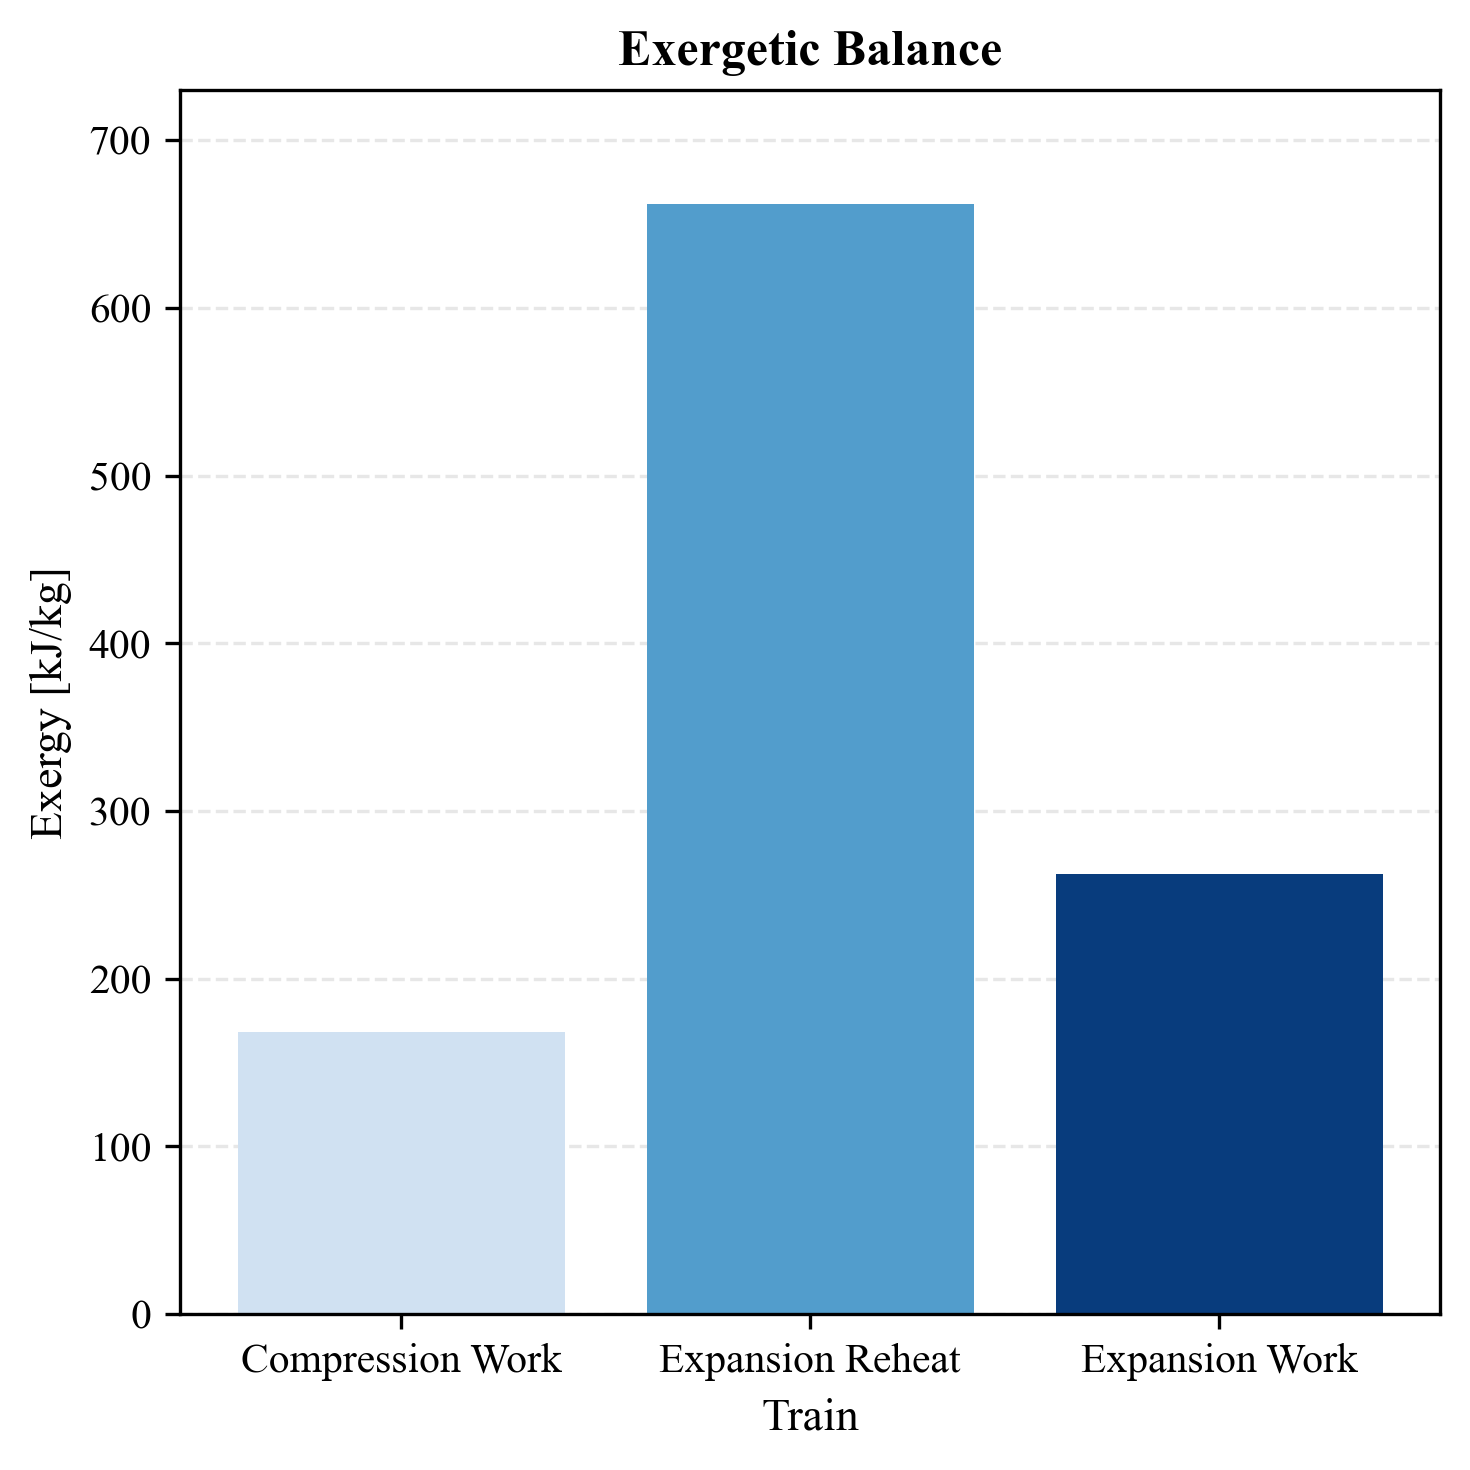

In [84]:
Figure_title = 'Exergetic Balance'

kpis = ['Compression Work', 'Expansion Reheat', 'Expansion Work']
y_data = [W_C, Q_F, W_T]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Train'); ax.set_ylabel('Exergy [kJ/kg]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

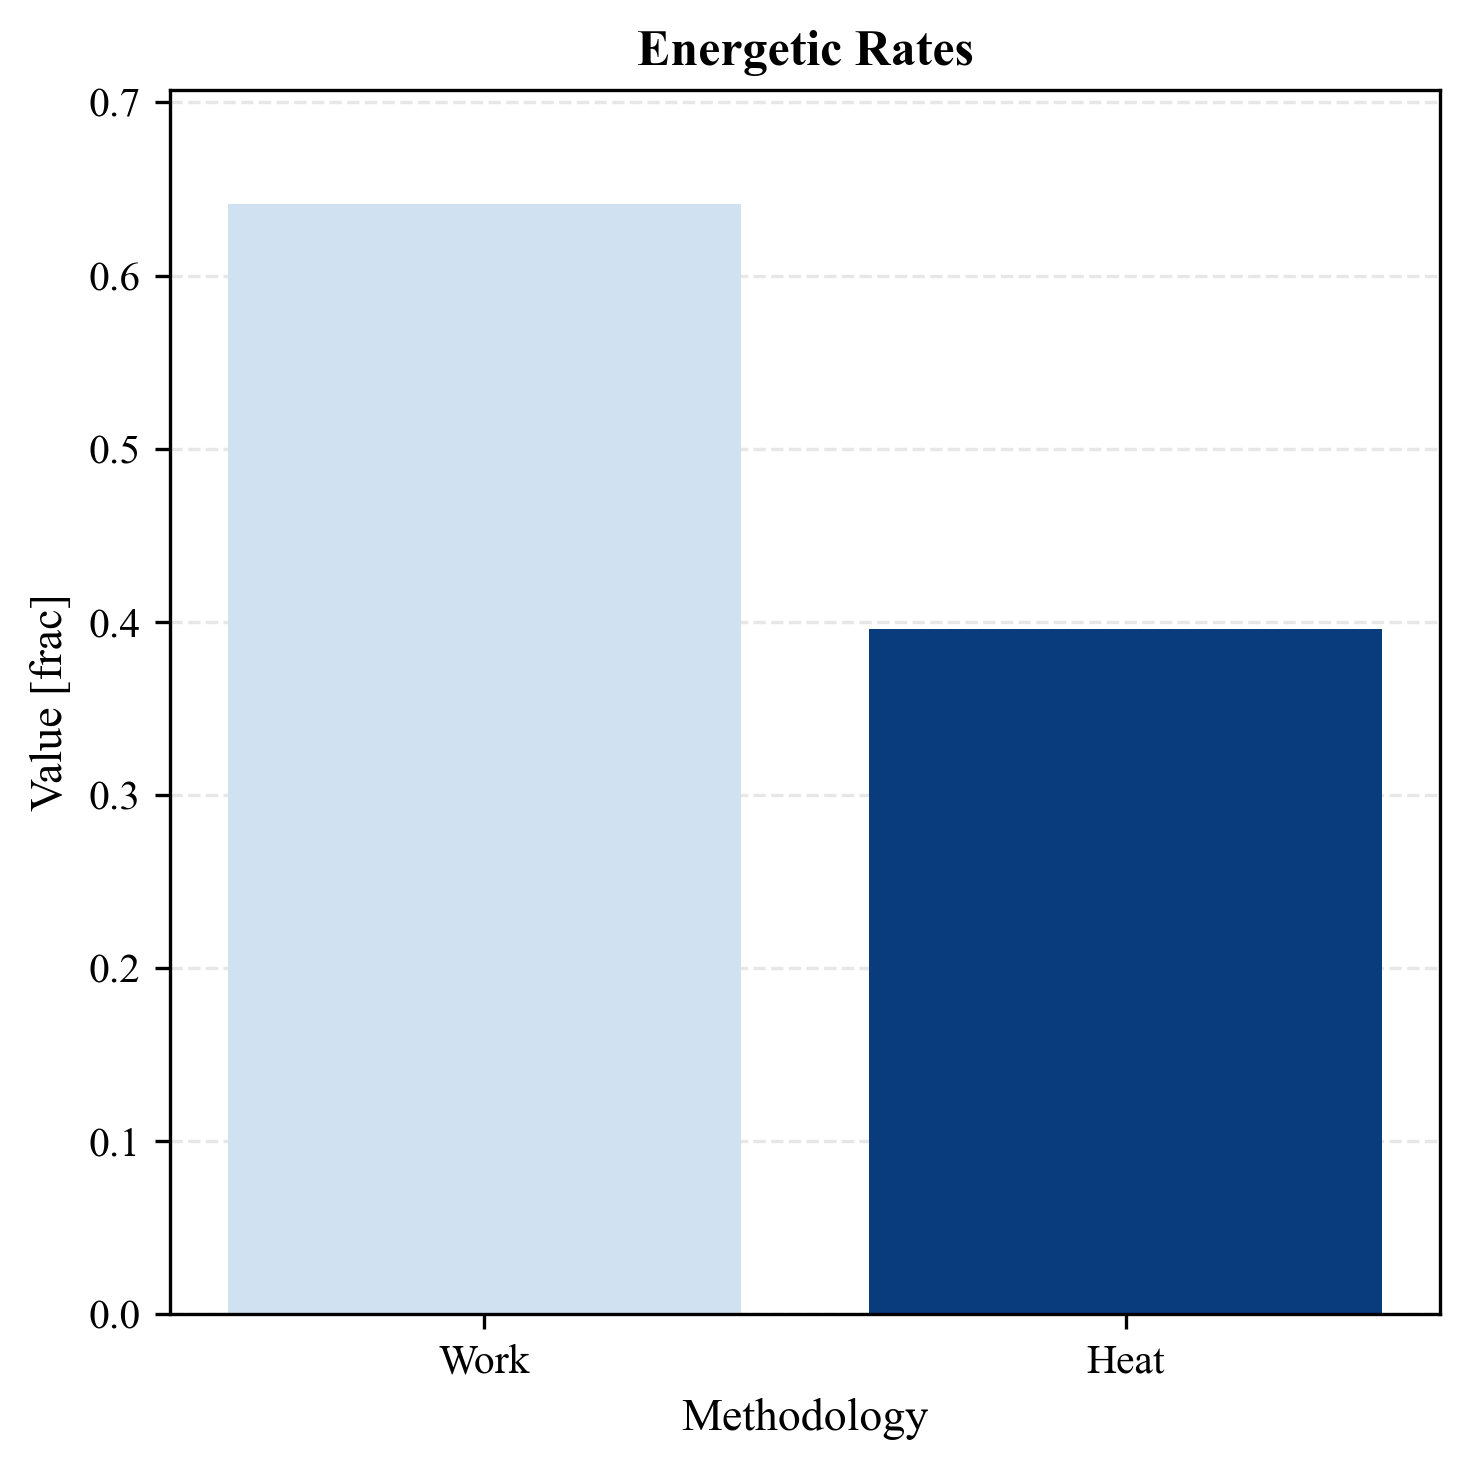

In [85]:
Figure_title = 'Energetic Rates'

kpis = ['Work', 'Heat']
y_data = [ER, HR]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Value [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

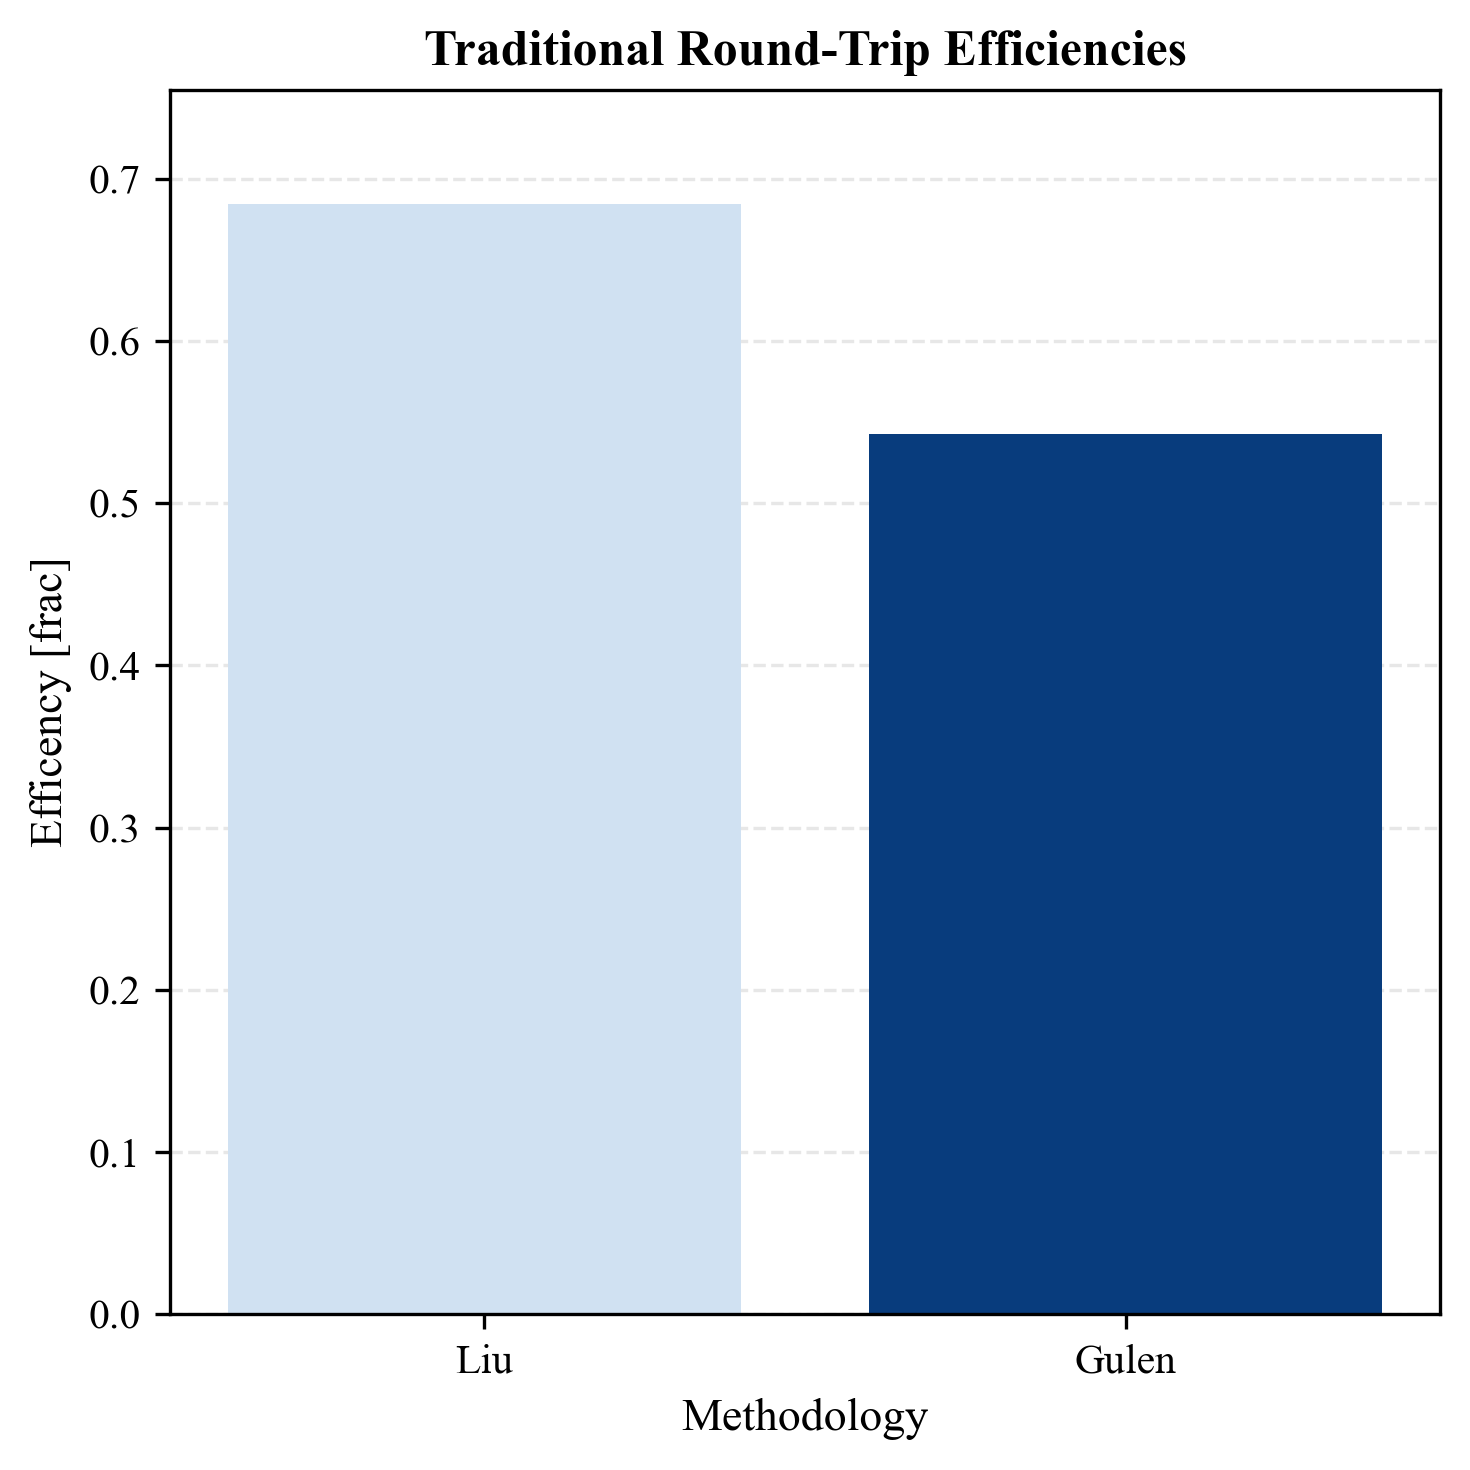

In [86]:
Figure_title = 'Traditional Round-Trip Efficiencies'

kpis = ['Liu', 'Gulen']
y_data = [RTE_Liu, RTE_Gulen]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Efficency [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

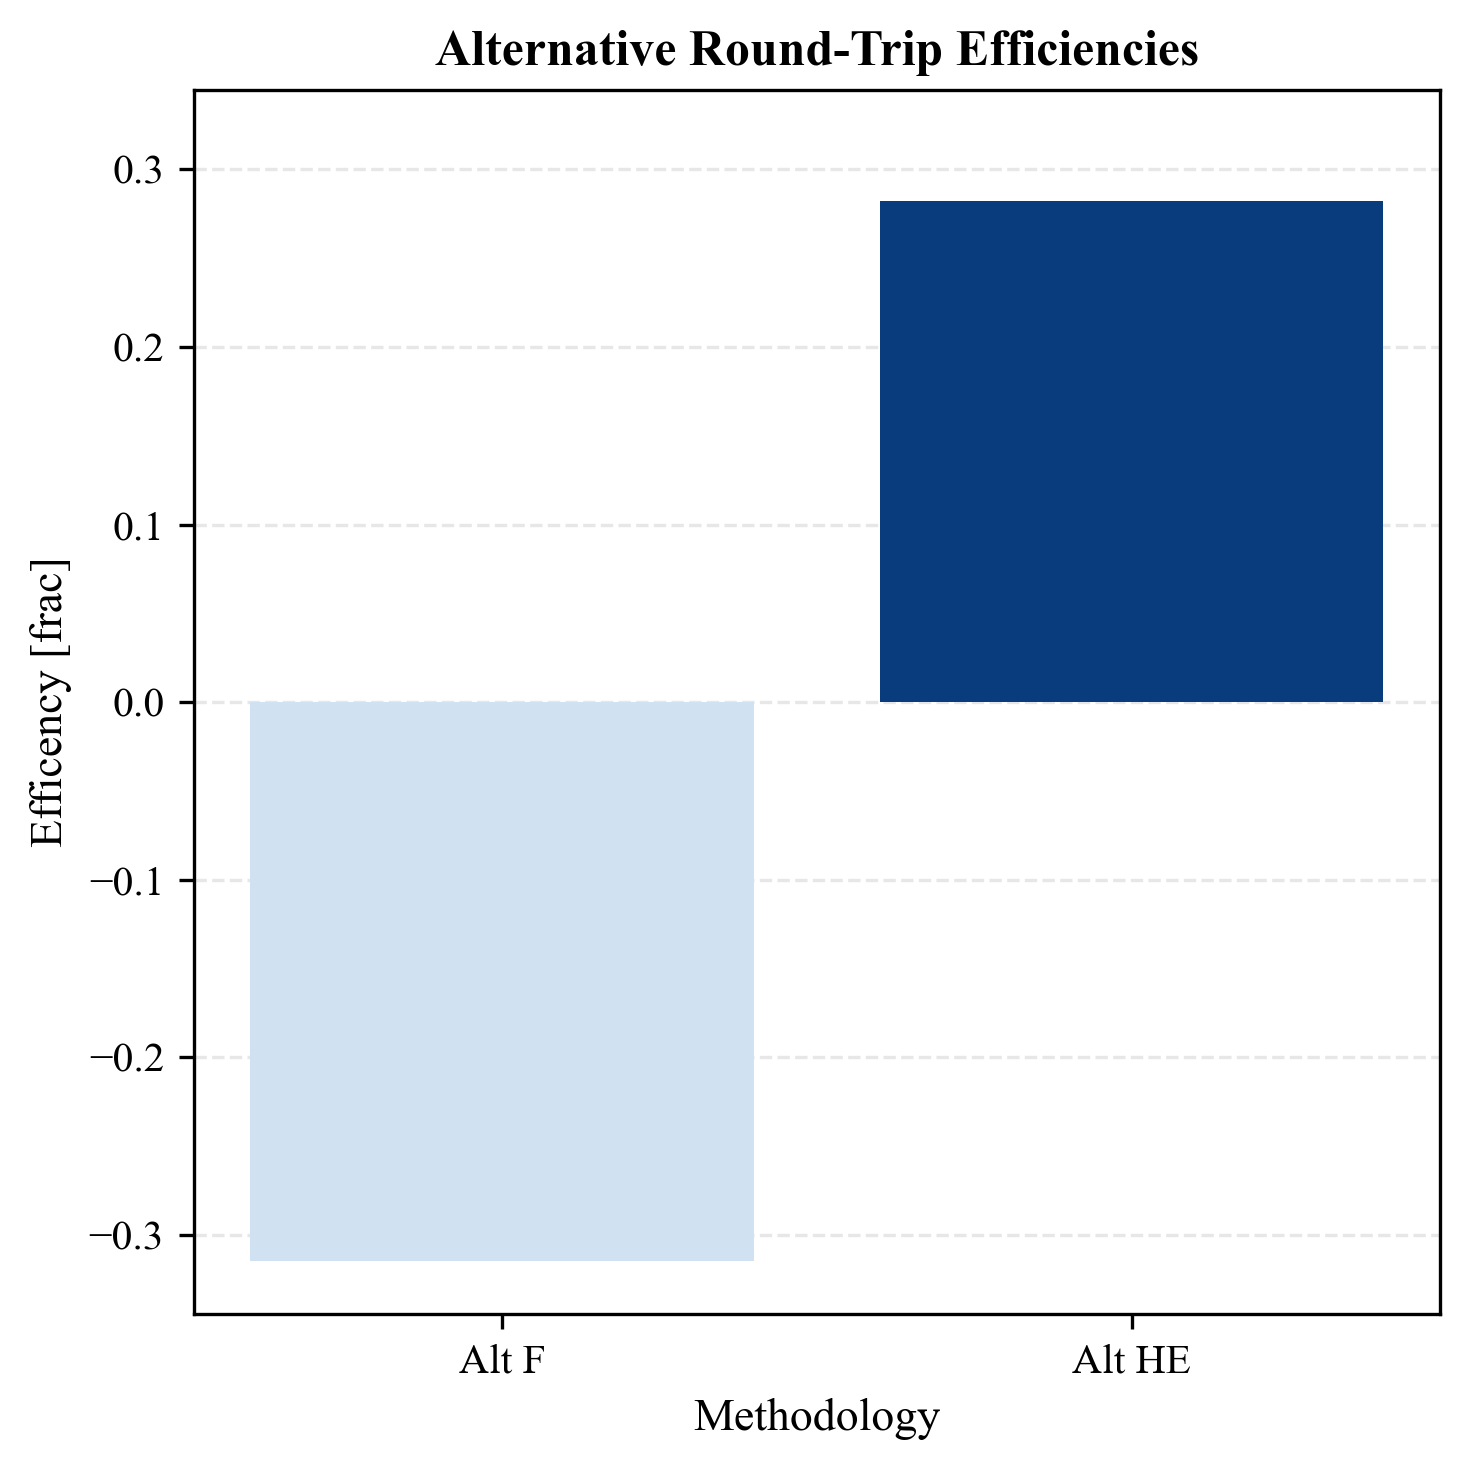

In [87]:
Figure_title = 'Alternative Round-Trip Efficiencies'

kpis = ['Alt F', 'Alt HE']
y_data = [RTE_alt_F, RTE_alt_HE]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Efficency [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

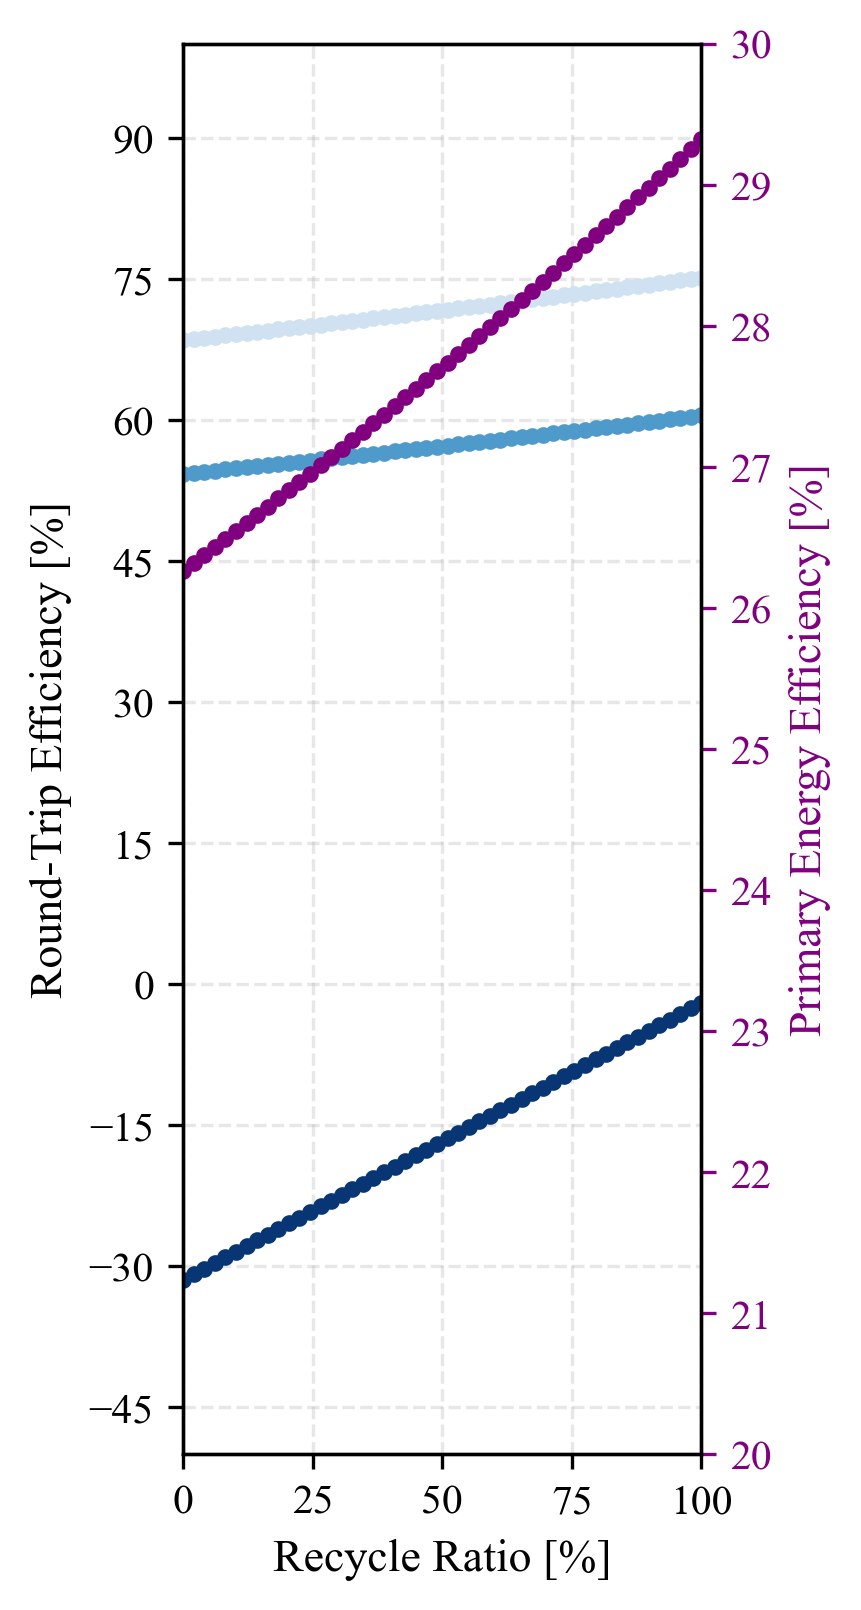

In [88]:
Q_rcyc_max    = Q_ICL
Q_rcyc_sample = np.linspace(0, Q_rcyc_max, 50)
Q_rcyc_ratio  = 100 * Q_rcyc_sample / Q_rcyc_max   # now in %

Q_HE_eff   = Q_HE - Q_rcyc_sample
Q_F_array  = Q_HE_eff / eta_burner_Gulen

RTE_Liu_array     = 100 * W_T / (W_C + eta_gen_avg * Q_HE_eff)
RTE_Gulen_array   = 100 * W_T / (W_C + eta_gen_avg * Q_F_array)
RTE_alt_F_array   = 100 * (W_T - eta_gen_avg * Q_F_array) / W_C
RTE_alt_HE_array  = 100 * (W_T - eta_gen_avg * Q_HE_eff) / W_C
PEE_array         = 100 * W_T / ((W_C / eta_gri_avg) + Q_F_array)

fig, ax1 = plt.subplots(figsize=(3, 5.5), dpi=300)

cmap   = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.975, 3))
labels = ['RTE Liu', 'RTE Gulen', 'RTE alt F', 'RTE alt HE']

for arr, col, lbl in zip([RTE_Liu_array, RTE_Gulen_array, RTE_alt_F_array, RTE_alt_HE_array], colors, labels):
    ax1.plot(Q_rcyc_ratio, arr, marker='o', markersize=3, linewidth=1, color=col)

ax1.set_xlabel('Recycle Ratio [%]')
ax1.set_ylabel('Round-Trip Efficiency [%]')
ax1.grid(True, which='both', linestyle='--', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(Q_rcyc_ratio, PEE_array, marker='o', markersize=3, linewidth=1, color='purple')
ax2.set_ylabel('Primary Energy Efficiency [%]', color='purple')
ax2.tick_params(axis='y', colors='purple')

ax1.set_xlim(0, 100)
ax1.set_ylim(-50, 100)  
ax2.set_ylim(20, 30)

ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax2.yaxis.set_major_locator(plt.MaxNLocator(10))

ax1.legend([], [], frameon=False)
ax1.set_title("")

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

plt.tight_layout()

Figure_title = r'Recycled Dumped Heat Ratio & Cycle Efficiency KPIs'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


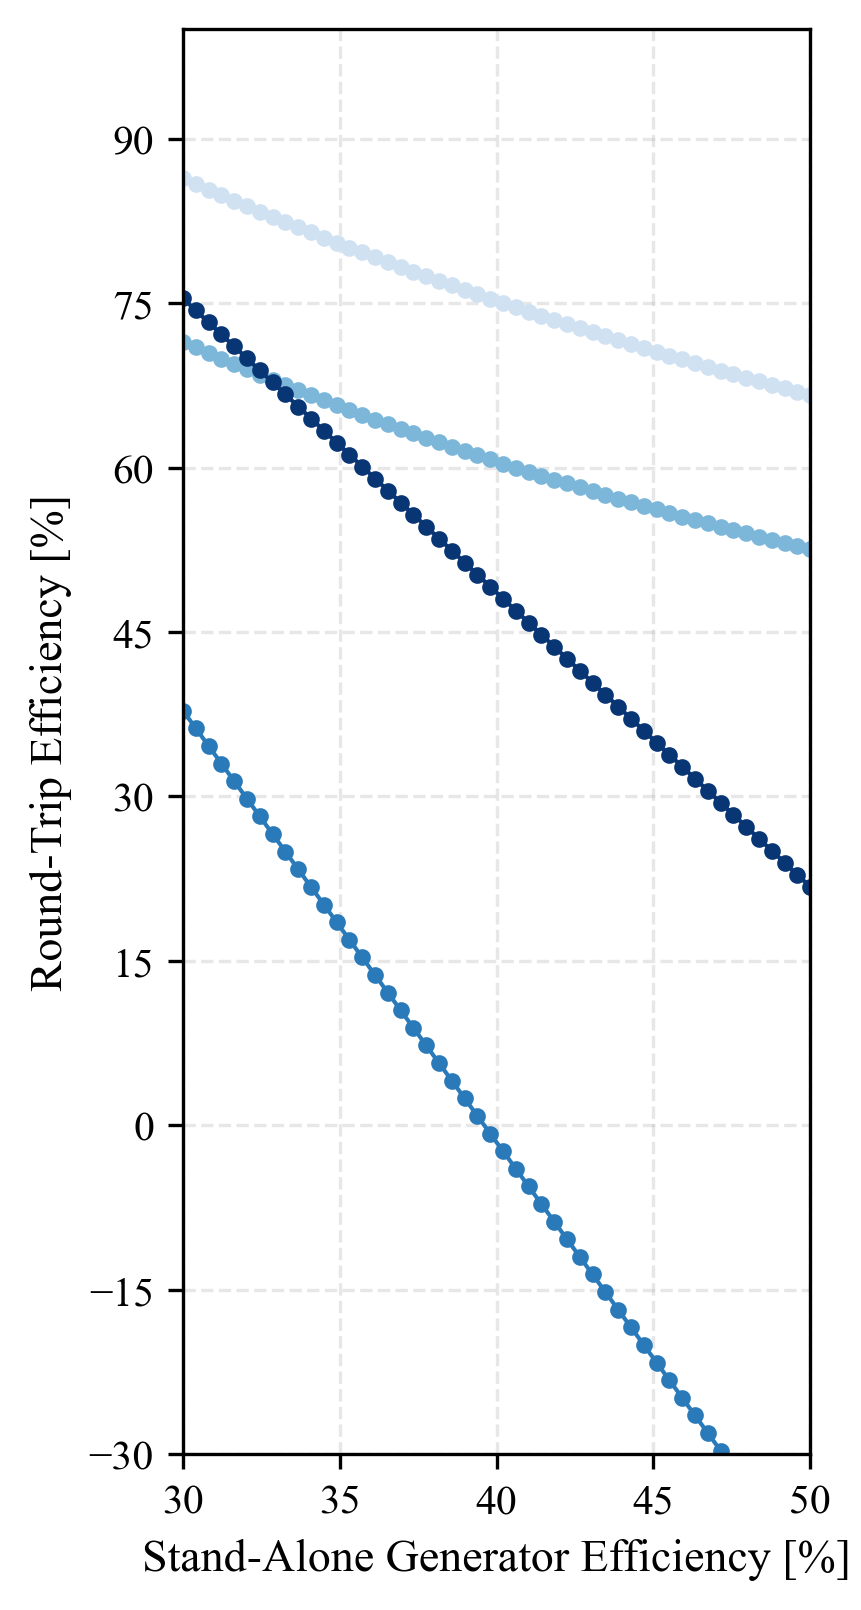

In [89]:
eta_gen_sample = np.linspace(0.3, 0.5, 50) * 100   # convert to %
RTE_Liu_array   = 100 * W_T / (W_C + (eta_gen_sample/100) * Q_HE)
RTE_Gulen_array = 100 * W_T / (W_C + (eta_gen_sample/100) * Q_F)
RTE_alt_F_array = 100 * (W_T - (eta_gen_sample/100) * Q_F) / W_C
RTE_alt_HE_array= 100 * (W_T - (eta_gen_sample/100) * Q_HE) / W_C

fig, ax1 = plt.subplots(figsize=(3, 5.5), dpi=300)

cmap   = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.975, 4))

for arr, col in zip([RTE_Liu_array, RTE_Gulen_array, RTE_alt_F_array, RTE_alt_HE_array], colors):
    ax1.plot(eta_gen_sample, arr, marker='o', markersize=3, linewidth=1, color=col)

ax1.set_xlabel('Stand-Alone Generator Efficiency [%]')
ax1.set_ylabel('Round-Trip Efficiency [%]')
ax1.grid(True, which='both', linestyle='--', alpha=0.3)

ax1.set_xlim(30, 50)
ax1.set_ylim(-30, 100)  

ax1.yaxis.set_major_locator(plt.MaxNLocator(10))

ax1.legend([], [], frameon=False)
ax1.set_title("")

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

plt.tight_layout()

Figure_title = r'Stand-alone Generator Thermal Efficiency & Cycle Efficiency KPIs'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')

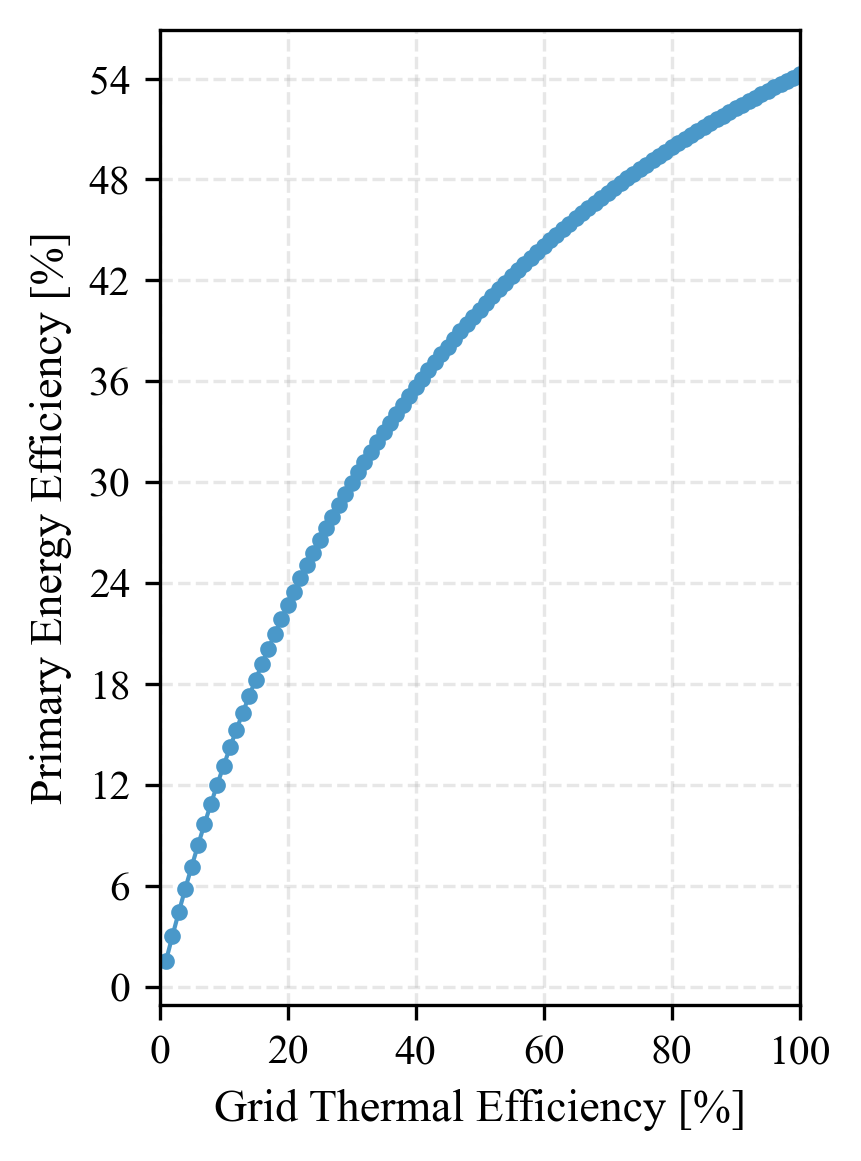

In [90]:
eta_grid_sample = np.linspace(0.01, 1, 100) * 100  
PEE_array_2     = 100 * W_T / ((W_C / (eta_grid_sample/100)) + eta_gen_avg*Q_F)

fig, ax = plt.subplots(figsize=(3, 4), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
    'mathtext.it': 'Times New Roman:italic',
    'font.size': 11
})

color = plt.get_cmap('Blues')(0.6)
ax.plot(eta_grid_sample, PEE_array_2, marker='o', markersize=3, linewidth=1, color=color)

ax.set_xlabel('Grid Thermal Efficiency [%]')
ax.set_ylabel('Primary Energy Efficiency [%]')

ax.set_title("")

ax.set_xlim(0, 100)

ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(True, which='both', linestyle='--', alpha=0.3)

plt.tight_layout()

Figure_title = 'Mean Grid Thermal Efficiency & PEE'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


### Component Visualizations

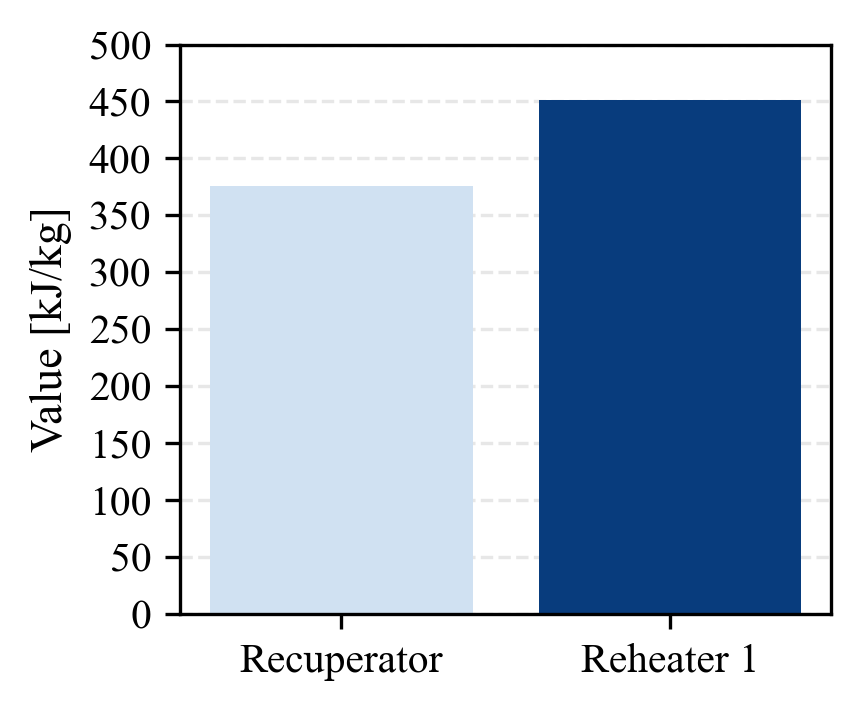

In [91]:
kpis = ['Recuperator', 'Reheater 1']
y_data = [-1*Q_recuped, Q_HE]

# Figure setup
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap = plt.get_cmap('Blues')
hues = np.linspace(0.2, 0.95, len(kpis))
colors = cmap(hues)

x = np.arange(len(kpis))
bars = ax.bar(x, y_data, color=colors, edgecolor='none')

ax.set_xticks(x)
ax.set_xticklabels(kpis)
ax.set_ylabel('Value [kJ/kg]')
ax.set_xlabel("")            
ax.set_title("")          

ax.set_ylim(0, 500)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()

Figure_title = 'Expansion Heating Decomposition'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


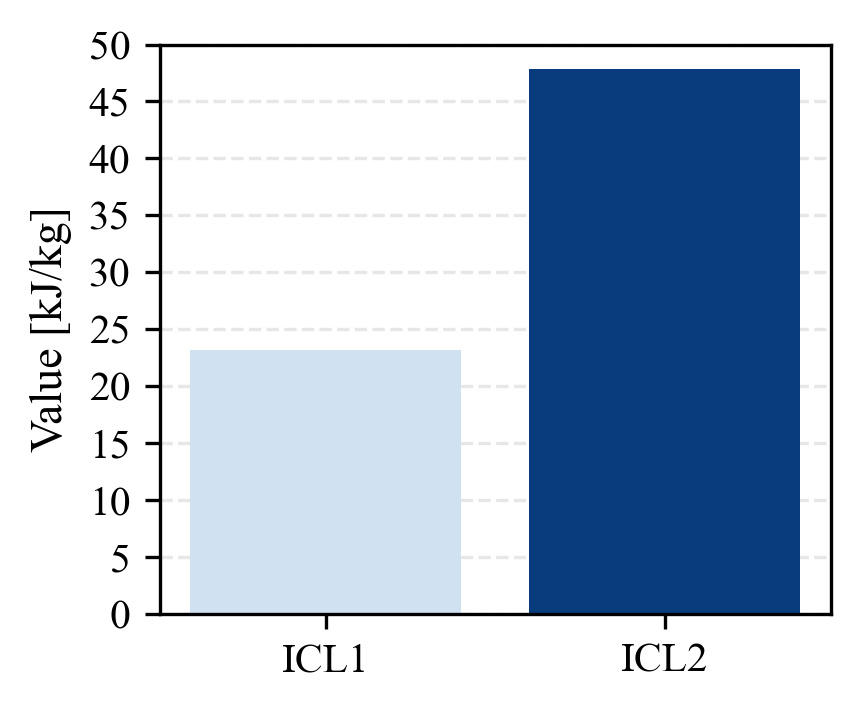

In [92]:
kpis = ['ICL1', 'ICL2']
y_data = [Q_ICL1, Q_ICL2]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap = plt.get_cmap('Blues')
hues = np.linspace(0.2, 0.95, len(kpis))
colors = cmap(hues)

x = np.arange(len(kpis))
bars = ax.bar(x, y_data, color=colors, edgecolor='none')

ax.set_xticks(x)
ax.set_xticklabels(kpis)
ax.set_ylabel('Value [kJ/kg]')
ax.set_xlabel("")  
ax.set_title("")    

ax.set_ylim(0, 50)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()

Figure_title = 'Intercooler Heat Dump Decomposition'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


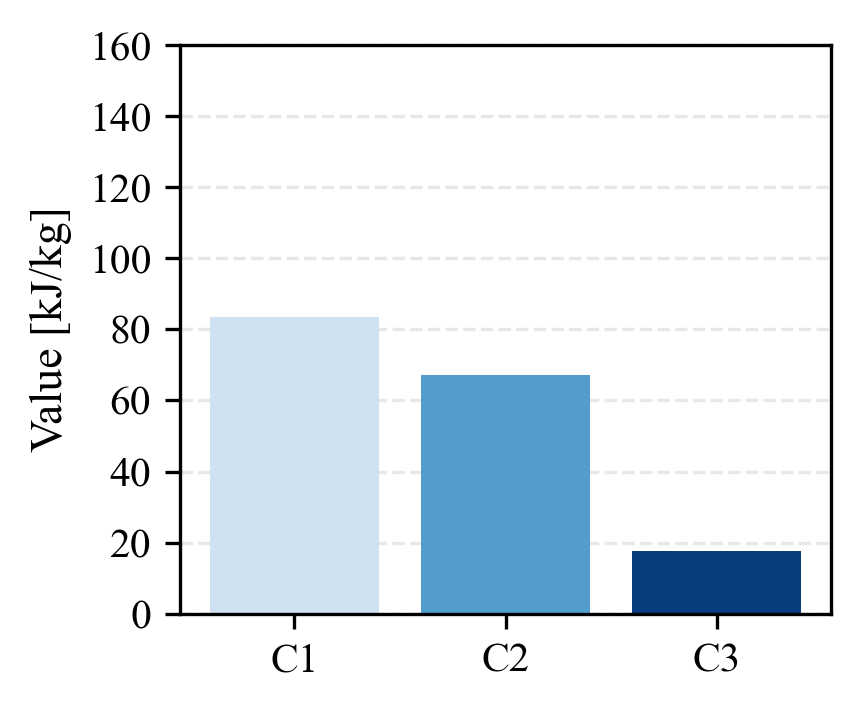

In [93]:
kpis = ['C1', 'C2', 'C3']
y_data = [W_C1, W_C2, W_C3]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap = plt.get_cmap('Blues')
hues = np.linspace(0.2, 0.95, len(kpis))
colors = cmap(hues)

x = np.arange(len(kpis))
bars = ax.bar(x, y_data, color=colors, edgecolor='none')

ax.set_xticks(x)
ax.set_xticklabels(kpis)
ax.set_ylabel('Value [kJ/kg]')
ax.set_xlabel("")   
ax.set_title("")  


ax.set_ylim(0, 160)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()

Figure_title = 'Compression Train Decomposition'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


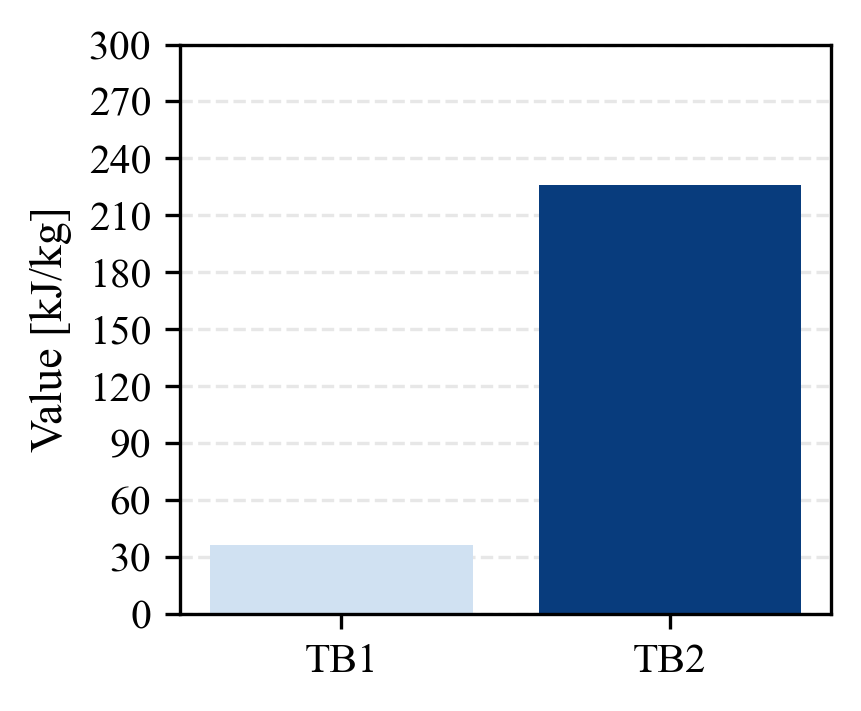

In [94]:
kpis = ['T1', 'T2']
y_data = [W_T1, W_T2]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap = plt.get_cmap('Blues')
hues = np.linspace(0.2, 0.95, len(kpis))
colors = cmap(hues)

x = np.arange(len(kpis))
bars = ax.bar(x, y_data, color=colors, edgecolor='none')

ax.set_xticks(x)
ax.set_xticklabels(['TB1', 'TB2'])
ax.set_ylabel('Value [kJ/kg]')
ax.set_xlabel("")   
ax.set_title("")    

ax.set_ylim(0, 300)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()


Figure_title = 'Expansion Train Decomposition'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


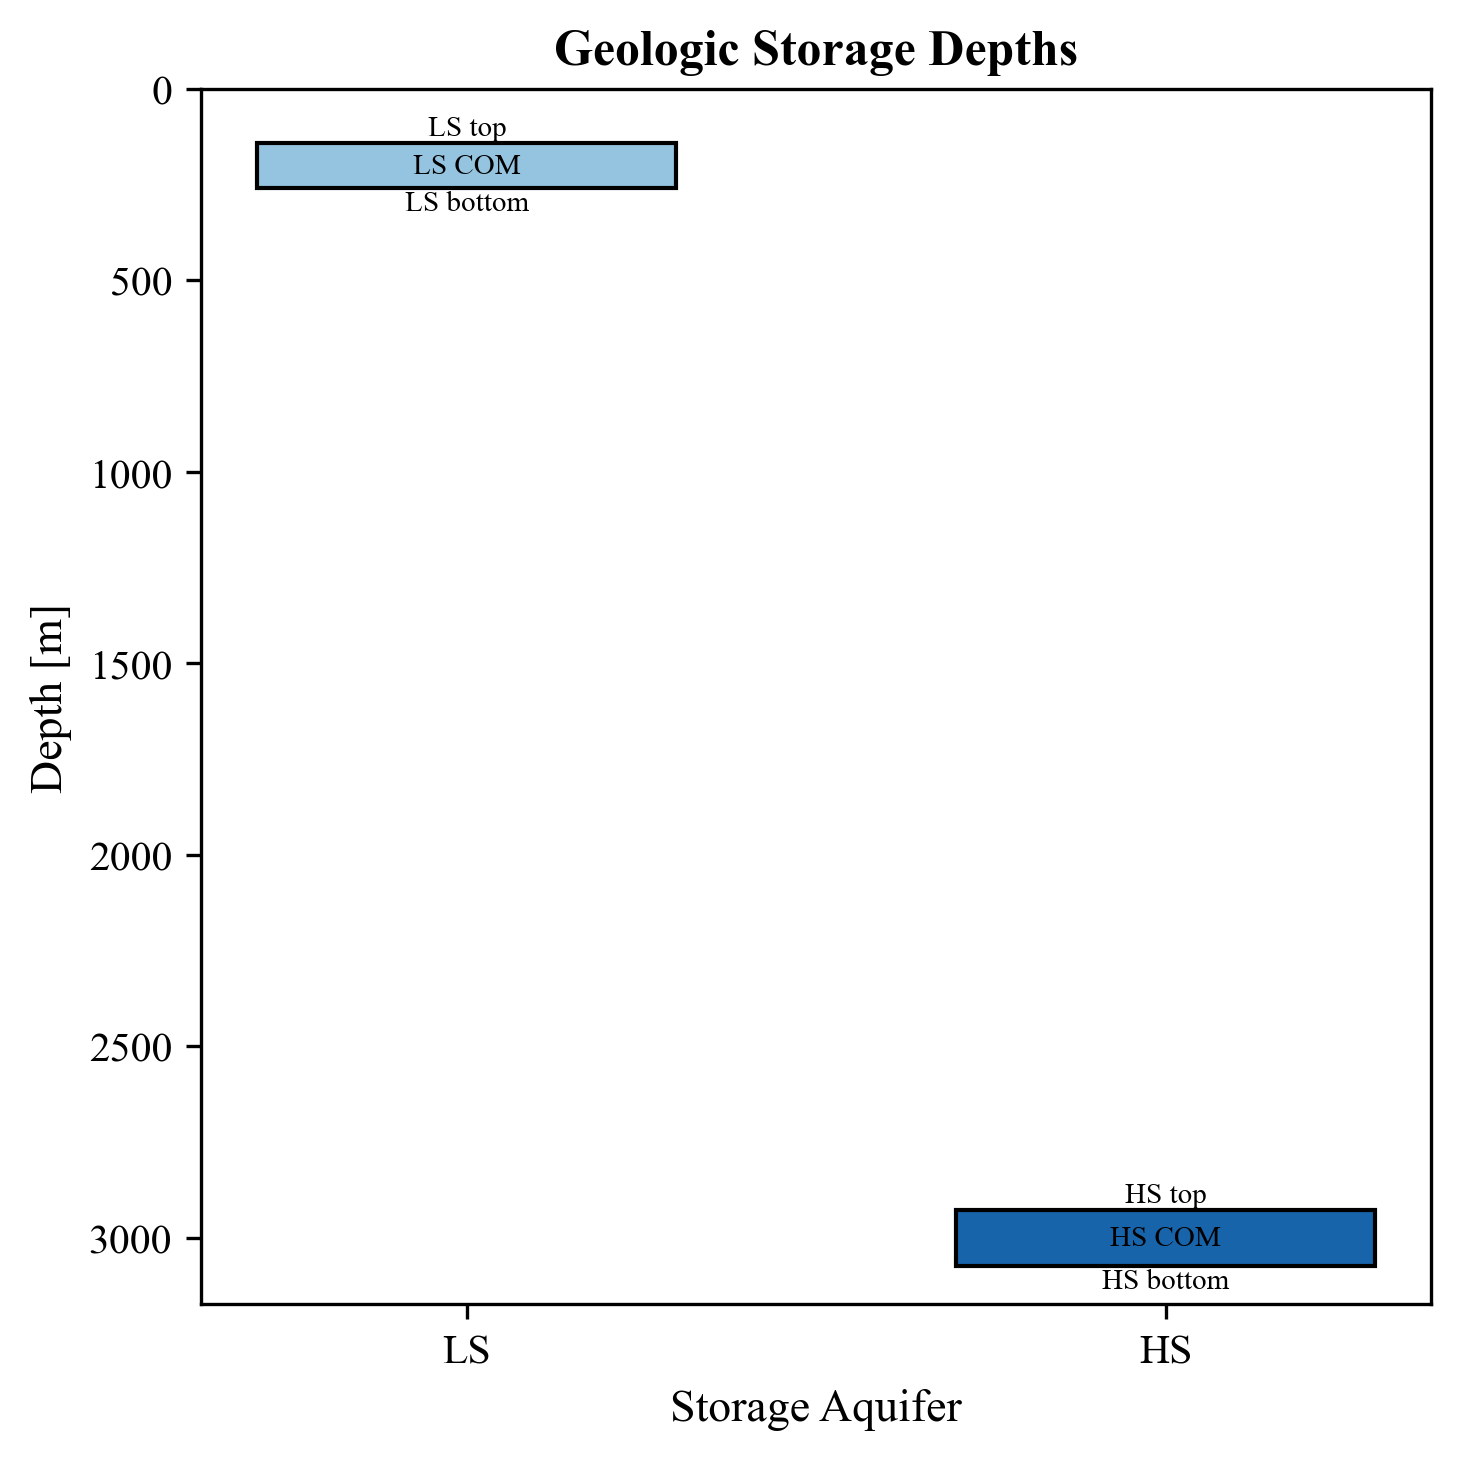

In [95]:
Figure_title = 'Geologic Storage Depths'
deltaz_LS = deltaP_LS_full_cycle/(p_LS_ss*g); deltaz_HS = deltaP_HS_full_cycle/(p_HS_ss*g); 
z_LS_top = z_LS - (deltaz_LS/2); z_LS_bottom = z_LS + (deltaz_LS/2); z_LS_com = z_LS;
z_HS_top = z_HS - (deltaz_HS/2); z_HS_bottom = z_HS + (deltaz_HS/2); z_HS_com = z_HS;
labels = ['LS', 'HS']; top    = [z_LS_top,     z_HS_top]; bot    = [z_LS_bottom,  z_HS_bottom]; com    = [z_LS_com,     z_HS_com]
heights     = [t - b for t, b in zip(top, bot)]; max_height  = max(heights); offset      = max_height * 0.045


fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap   = plt.get_cmap('Blues'); colors = cmap(np.linspace(0.4, 0.8, len(labels)))
x = np.arange(len(labels))
ax.bar(x,heights,bottom=bot,width=0.6,color=colors,edgecolor='black')
for xi, t, m, b, lbl in zip(x, top, com, bot, labels):
    ax.text(xi,t + offset,f"{lbl} top",ha='center',va='bottom',fontsize=7)
    ax.text(xi,m,f"{lbl} COM",ha='center',va='center',fontsize=7,color='black')
    ax.text(xi,b - offset,f"{lbl} bottom",ha='center',va='top',fontsize=7)
ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=10); ax.set_ylim(max(bot) + 100, 0);ax.set_xlabel('Storage Aquifer'); ax.set_ylabel('Depth [m]', fontsize=11);ax.set_title(Figure_title,fontsize=12,fontweight='bold')

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

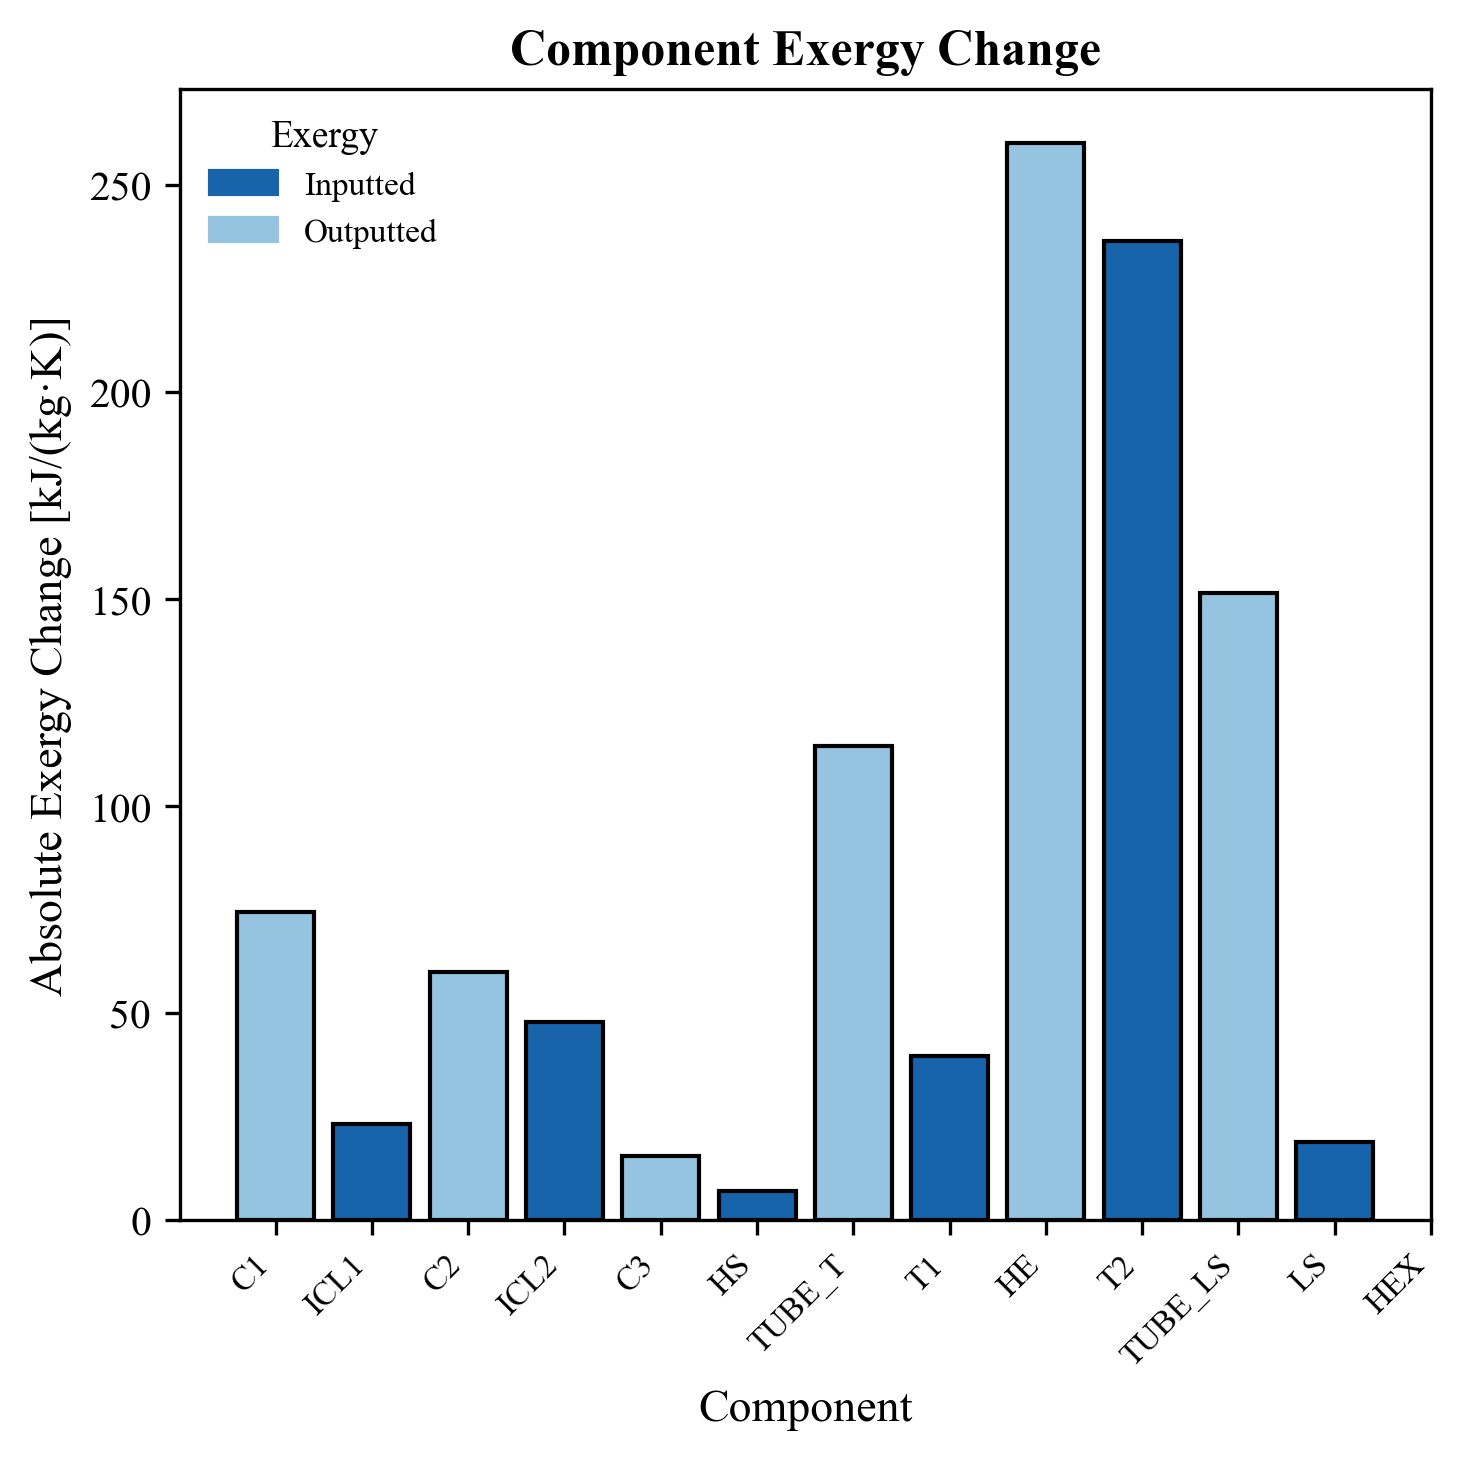

In [96]:
Figure_title = 'Component Exergy Change'

components = dfc['Component'].tolist(); start_ex   = dfc['Start_ex'].values; end_ex     = dfc['End_ex'].values; delta_ex   = end_ex - start_ex
heights = np.abs(delta_ex); x       = np.arange(len(components))

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap      = plt.get_cmap('Blues'); in_color  = cmap(0.8); out_color = cmap(0.4); outputcolors    = [in_color if d > 0 else out_color for d in delta_ex]
ax.bar(x, heights, color=colors, edgecolor='black'); in_patch  = mpatches.Patch(color=in_color,  label='Energy Input'); out_patch = mpatches.Patch(color=out_color, label='Energy Output')
ax.legend([in_patch, out_patch],['Inputted', 'Outputted'],title='Exergy',title_fontsize=9,fontsize=8,loc='upper left',frameon=False)
ax.set_title(Figure_title, fontsize=12, fontweight='bold'); ax.set_xlabel('Component', fontsize=11); ax.set_ylabel('Absolute Exergy Change [kJ/(kg·K)]', fontsize=11); ax.set_xticks(x)
ax.set_xticklabels(components, rotation=45, ha='right', fontsize=8); 

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

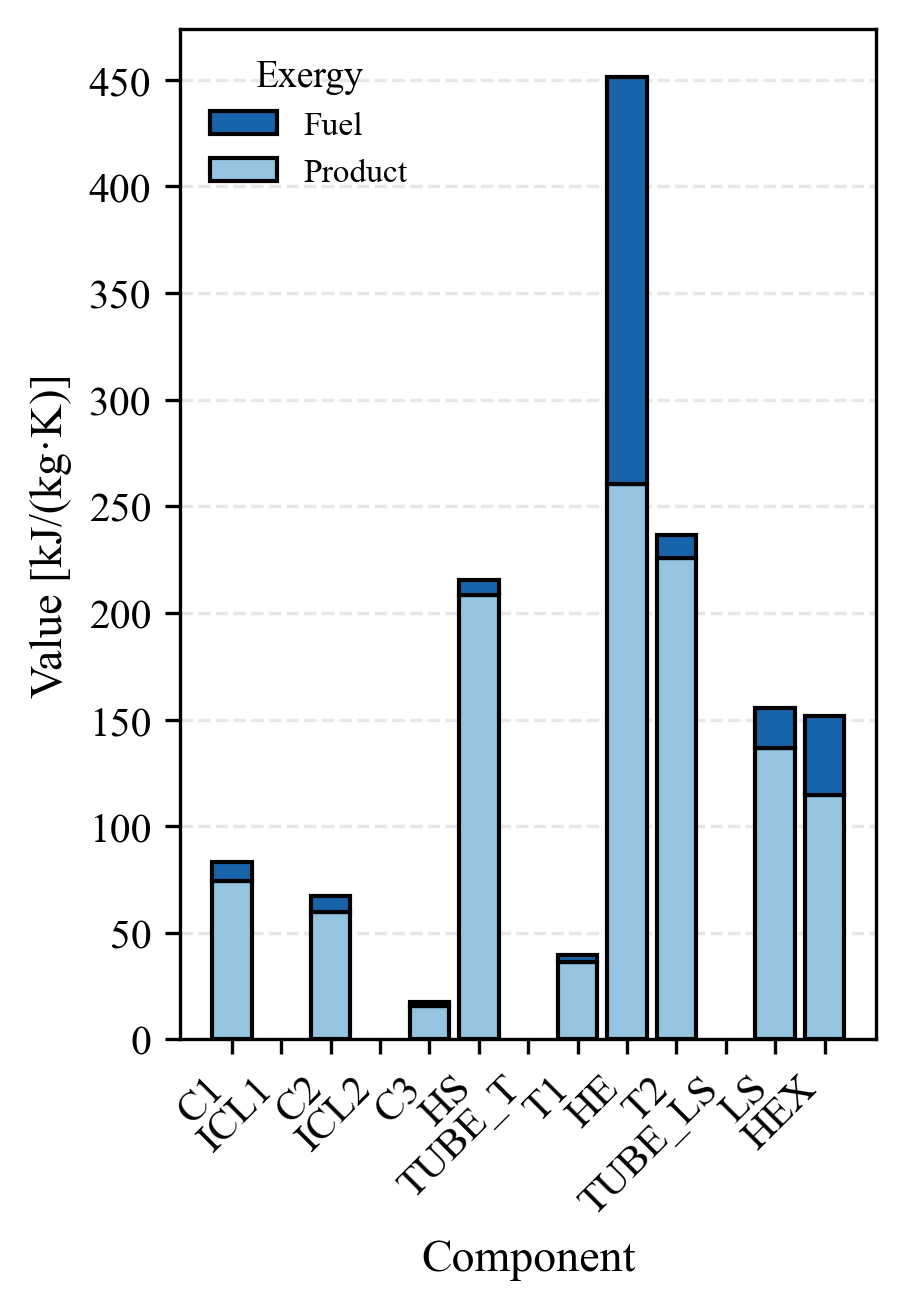

In [97]:
components = dfc['Component'].tolist()
EX_F = np.abs(dfc['EX_F'].values)
EX_P = np.abs(dfc['EX_P'].values)
inc_F = EX_F - EX_P

fig, ax = plt.subplots(figsize=(3.15, 4.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap = plt.get_cmap('Blues')
col_P = cmap(0.4)
col_F = cmap(0.8)

x = np.arange(len(components))
ax.bar(x, EX_P, color=col_P, label='Product', edgecolor='black')
ax.bar(x, inc_F, bottom=EX_P, color=col_F, label='Fuel', edgecolor='black')

ax.set_title("")  
ax.set_xlabel('Component')
ax.set_ylabel('Value [kJ/(kg·K)]')
ax.set_xticks(x)
ax.set_xticklabels(components, rotation=45, ha='right')

ax.yaxis.set_major_locator(plt.MaxNLocator(10))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Exergy',
          title_fontsize=9, fontsize=8, loc='upper left', frameon=False)

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()

Figure_title = 'Component Exergy Destruction'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


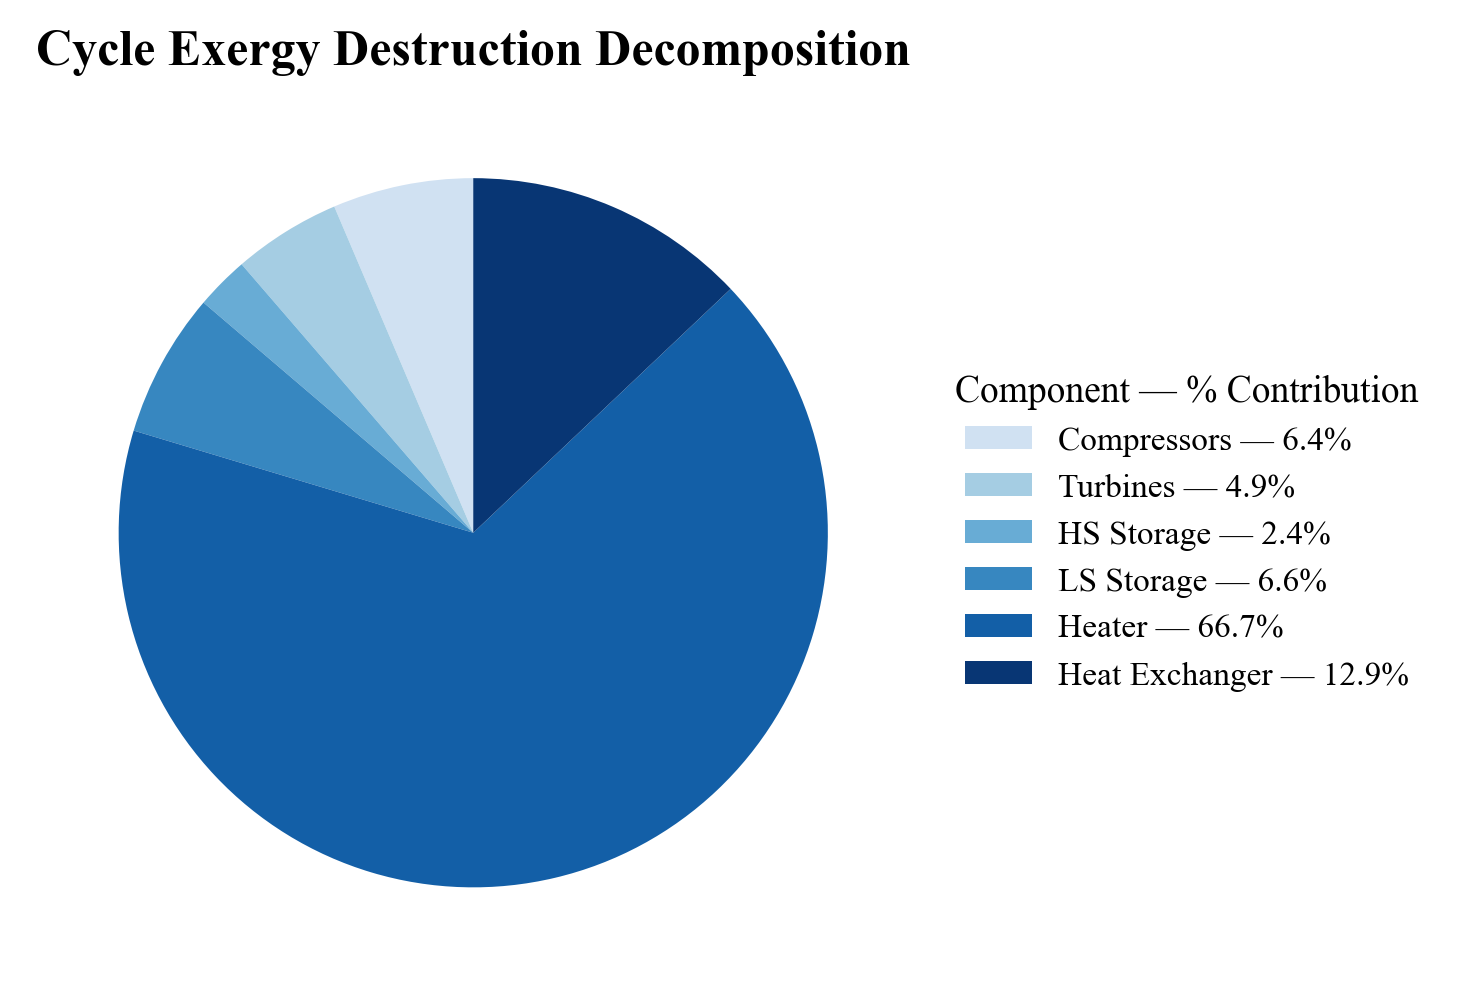

In [98]:
Figure_title = 'Cycle Exergy Destruction Decomposition'

components = ['Compressors', 'Turbines','HS Storage', 'LS Storage','Heater', 'Heat Exchanger']
ratios = np.array([EXDR_C,EXDR_T,EXDR_HS,EXDR_LS,EXDR_HE,EXDR_HEX]); percentages = 100 * ratios / ratios.sum(); legend_labels = [f"{comp} — {pct:.1f}%" for comp, pct in zip(components, percentages)]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.975, len(components)); colors = cmap(hues)
wedges, _ = ax.pie(ratios,labels=None,colors=colors,startangle=90,wedgeprops=dict(edgecolor=None))
ax.legend(wedges,legend_labels,title='Component — % Contribution',loc='center left',bbox_to_anchor=(1.01, 0.5),fontsize=8,title_fontsize=9,frameon=False); ax.set_title(Figure_title, fontsize=12, fontweight='bold')

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Stream Visualizations

In [99]:
dffull = df; df_storage = df.iloc[-2:]; df = df.iloc[:-2]; 
HS_num = 0.5*(HS_start+HS_end); LS_num = 0.5*(LS_start + (LS_start+1)); n_rows = dffull.shape[0];HS_idx = n_rows-1;LS_idx = n_rows;

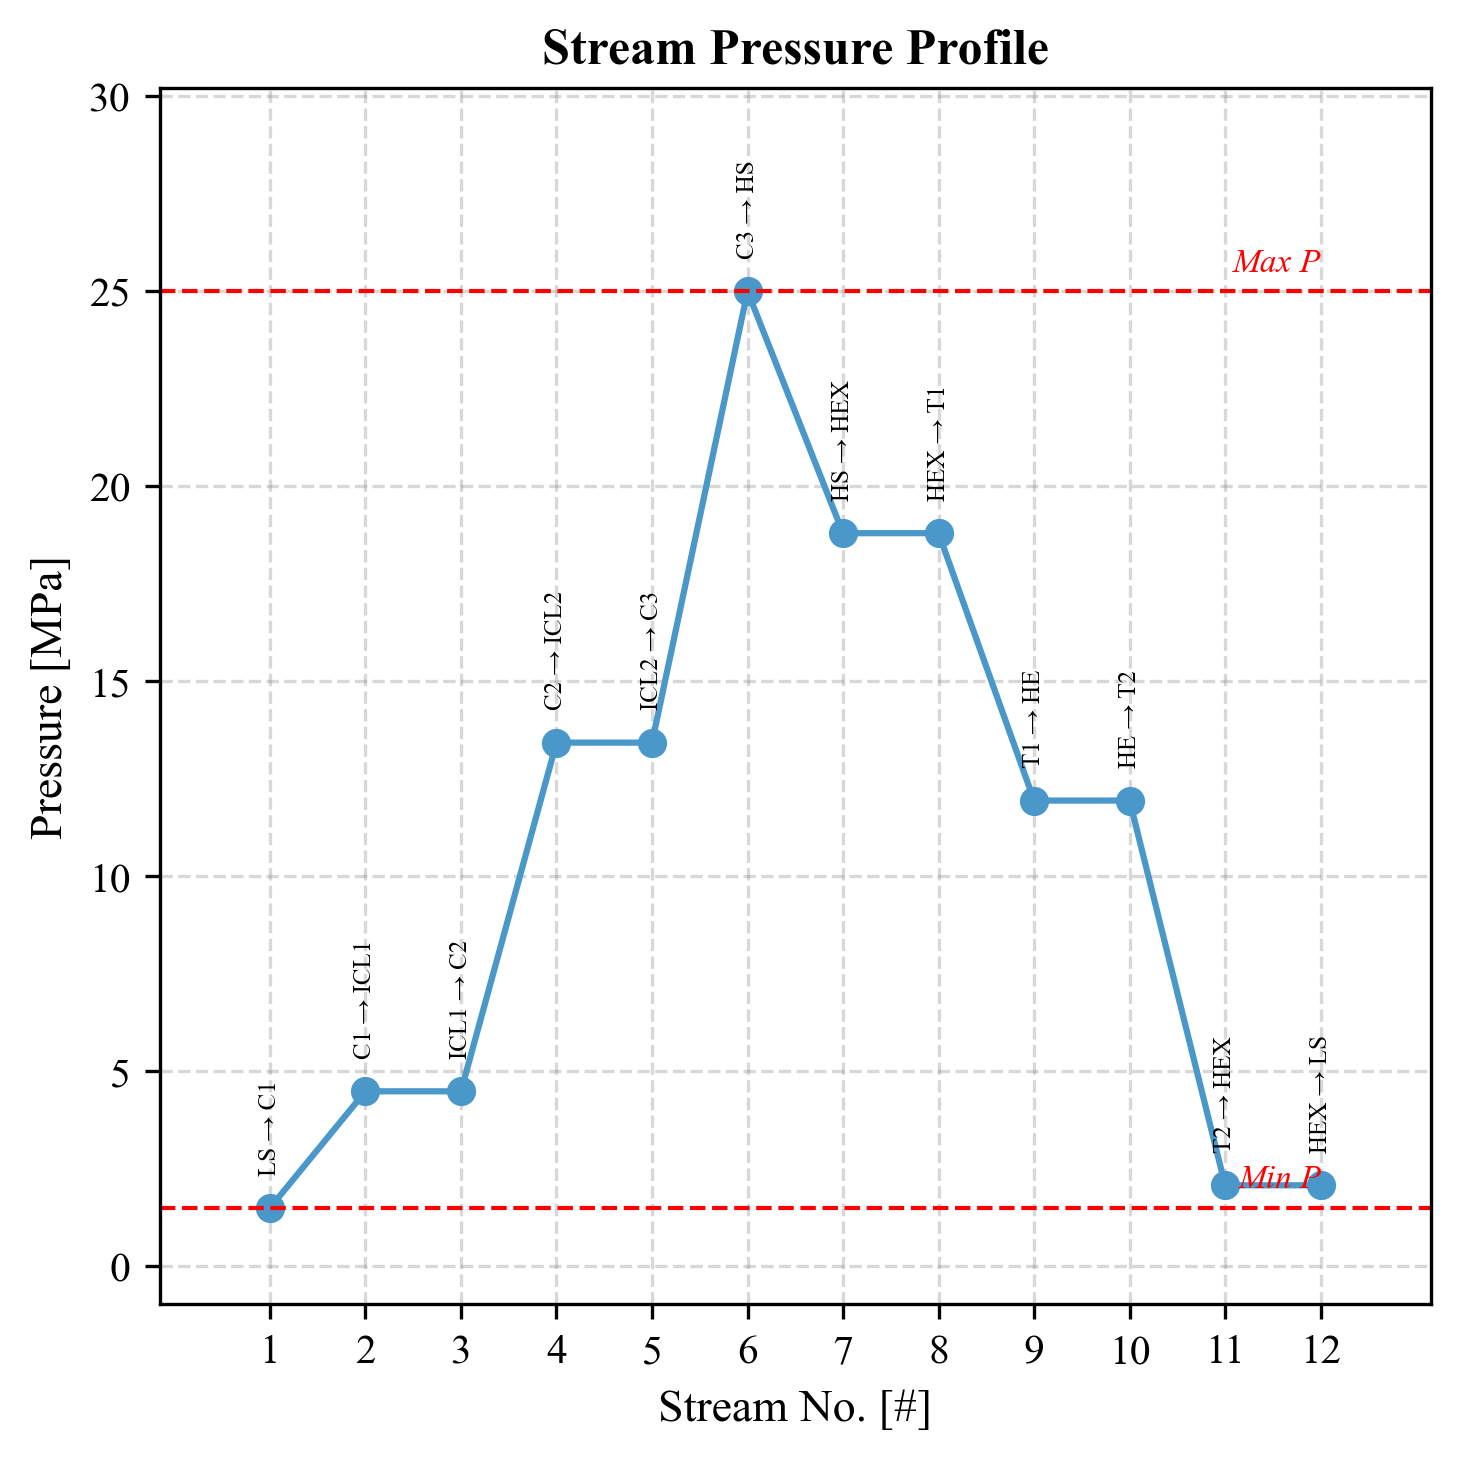

In [100]:
Thermodynamic_variable        = 'Pressure'
Thermodynamic_variable_symbol = 'P'
Units                         = 'MPa'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'

x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 0.75,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 0.75,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

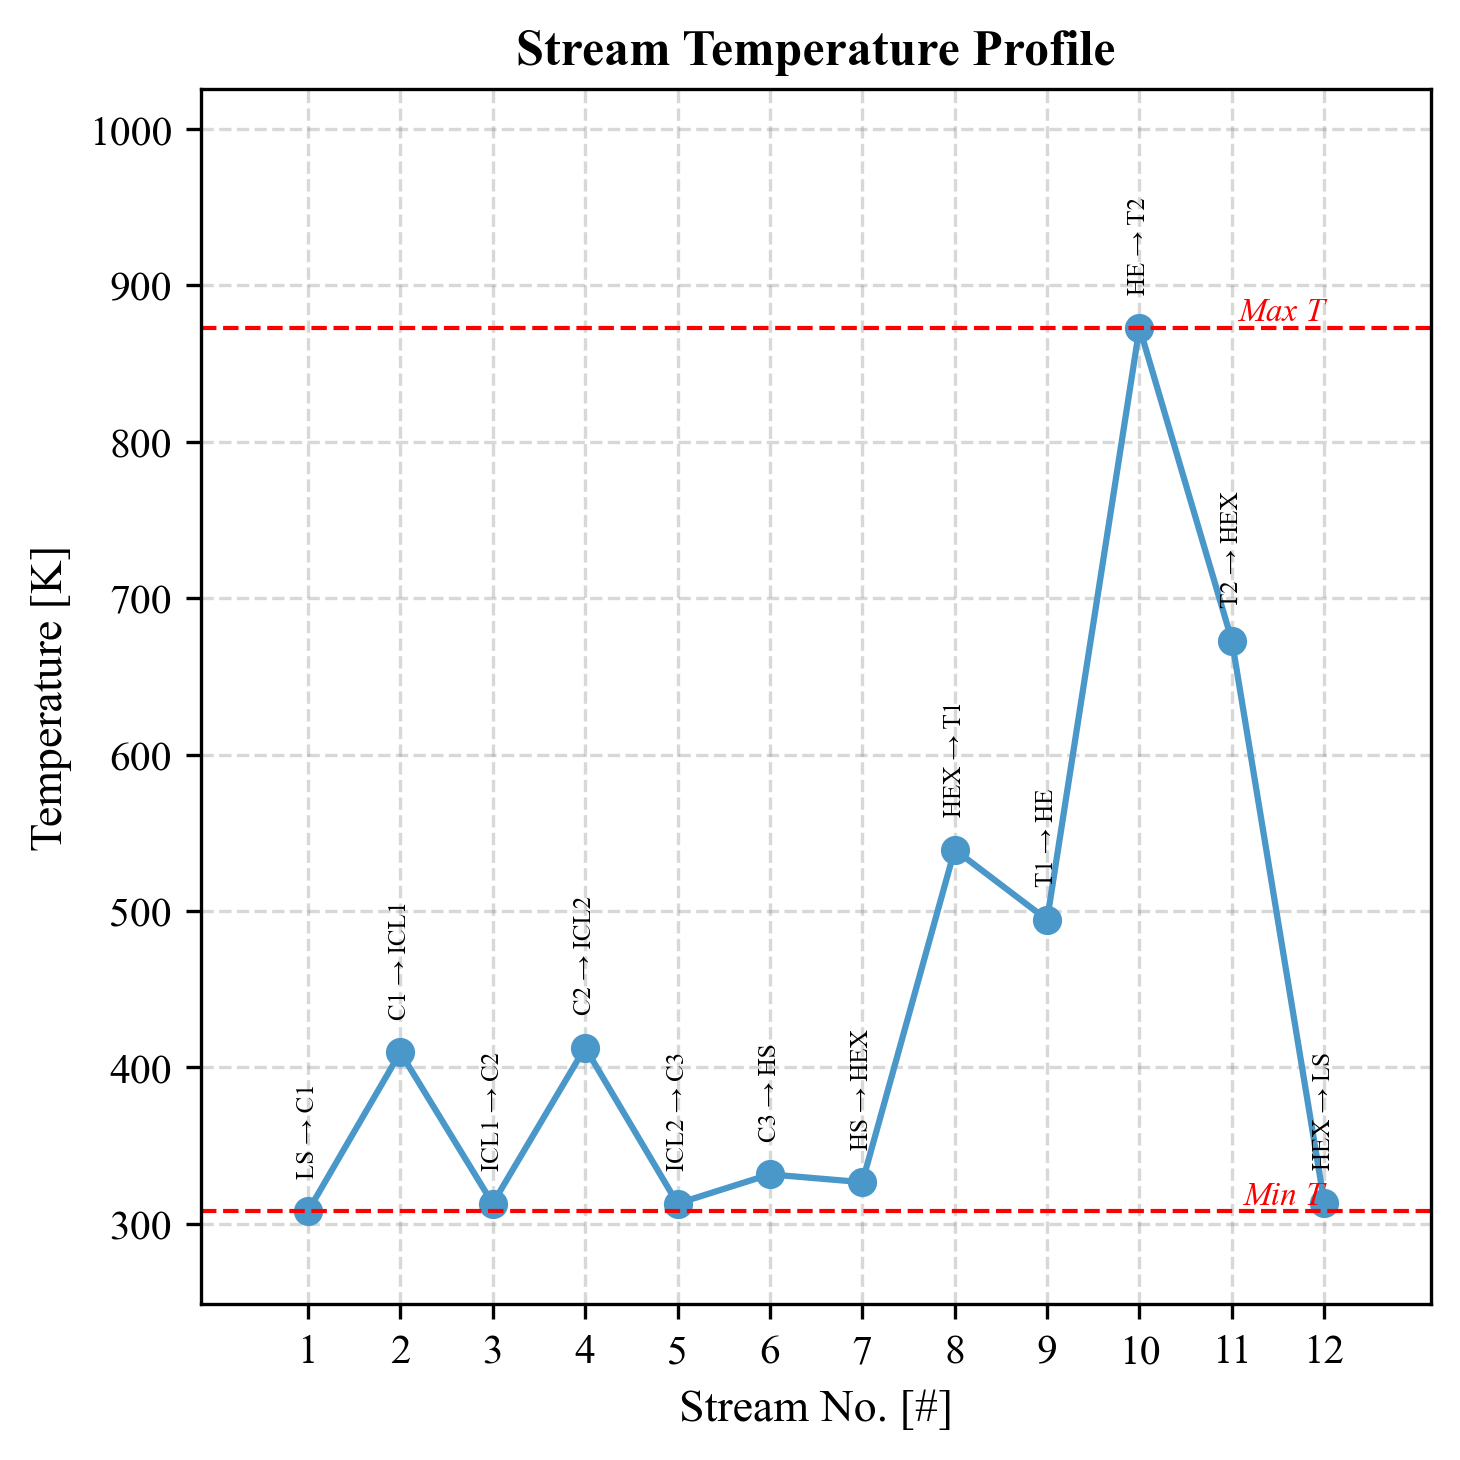

In [101]:
Thermodynamic_variable        = 'Temperature'
Thermodynamic_variable_symbol = 'T'
Units                         = 'K'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 10,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 10,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

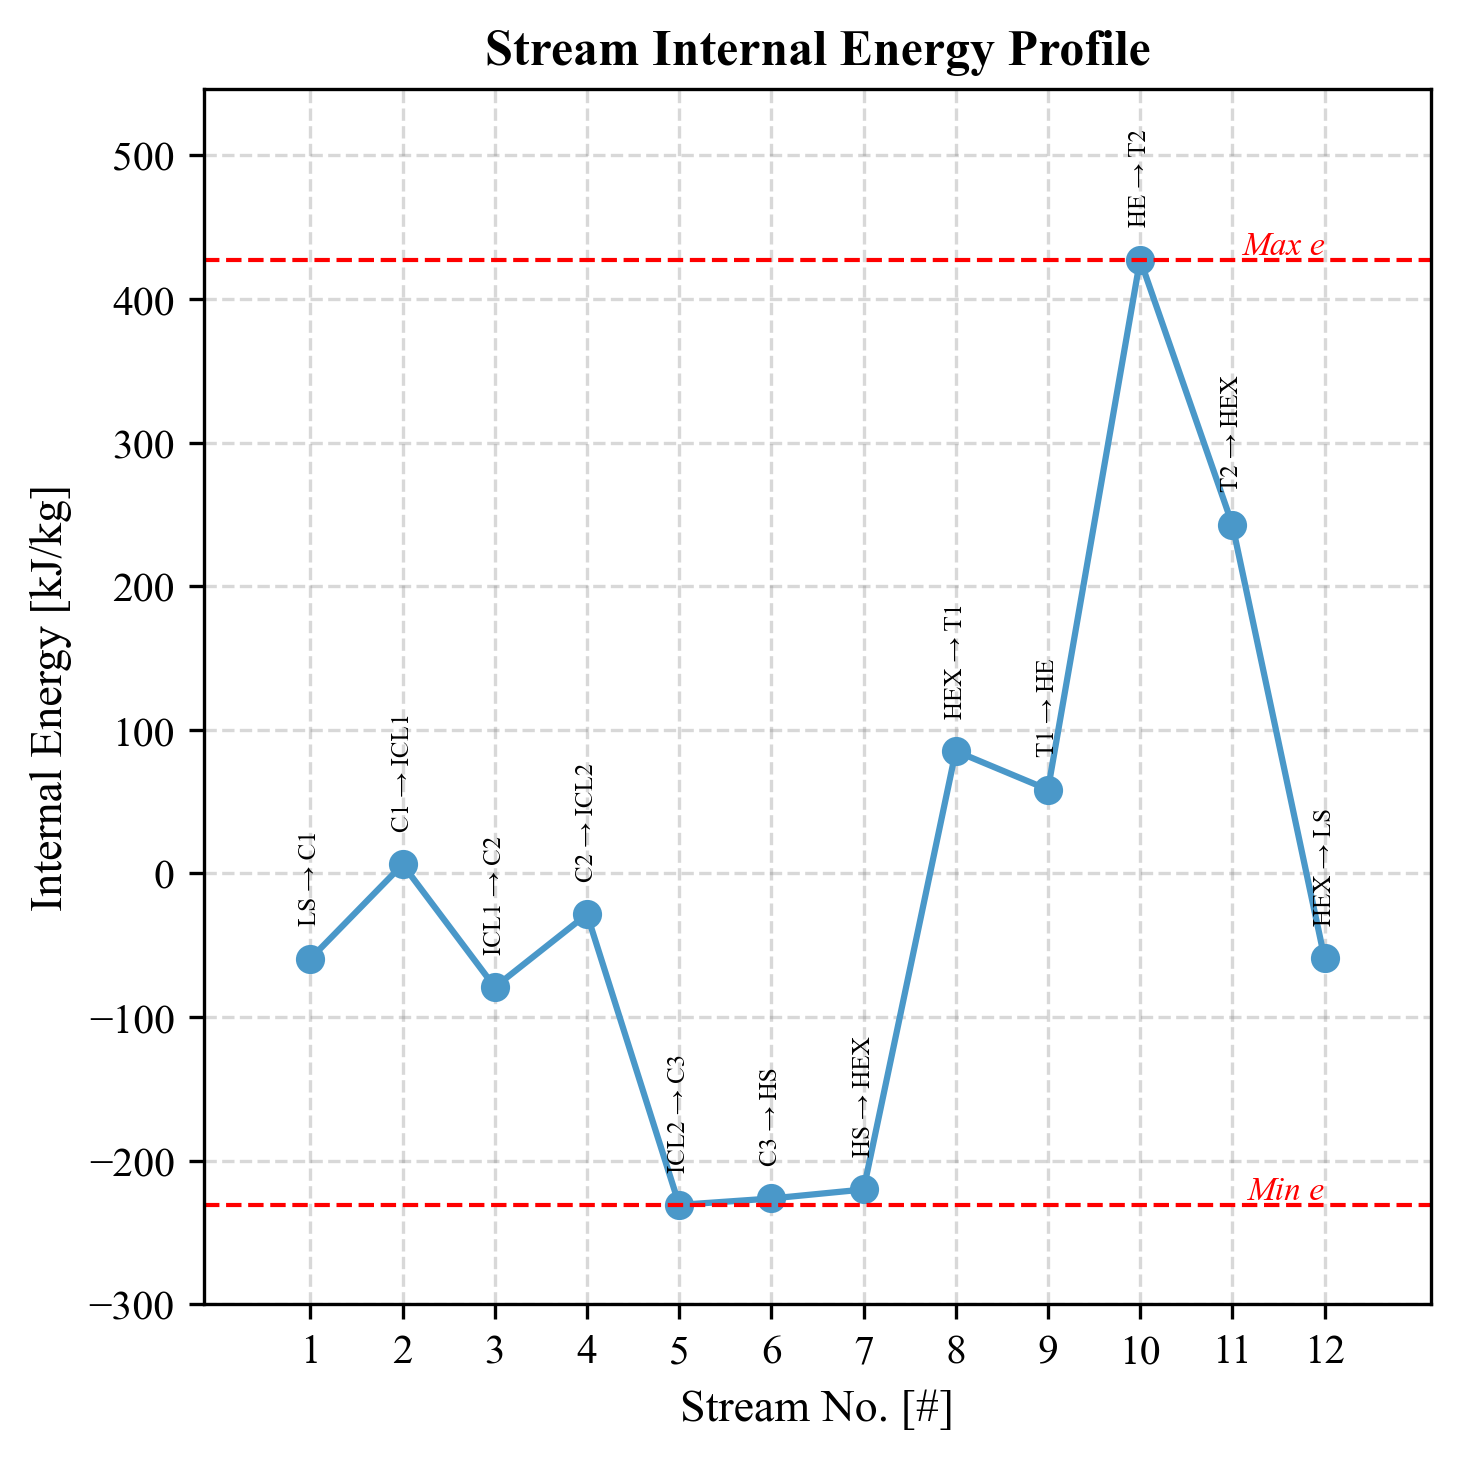

In [102]:
Thermodynamic_variable        = 'Internal Energy'
Thermodynamic_variable_symbol = 'e'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 10,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 10,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

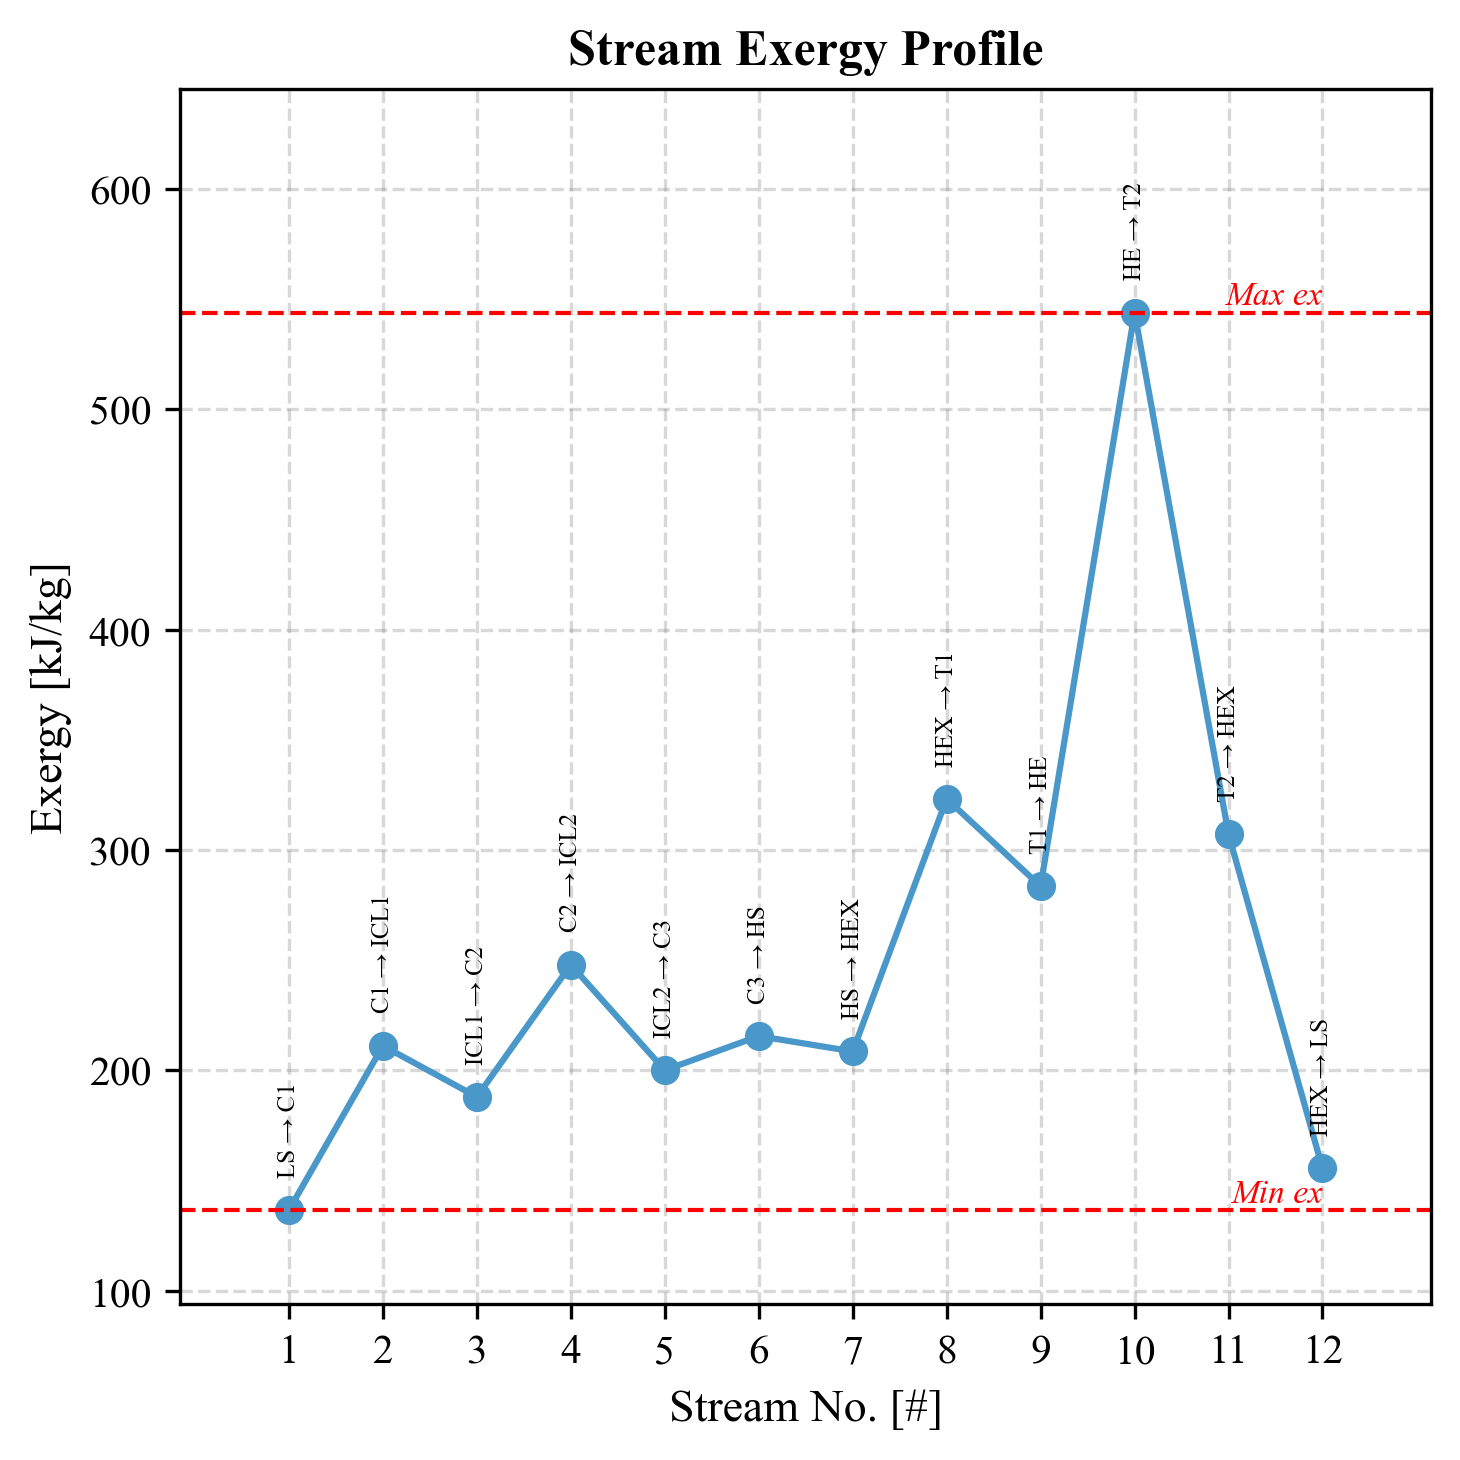

In [103]:
Thermodynamic_variable        = 'Exergy'
Thermodynamic_variable_symbol = 'ex'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 7.5,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 7.5,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

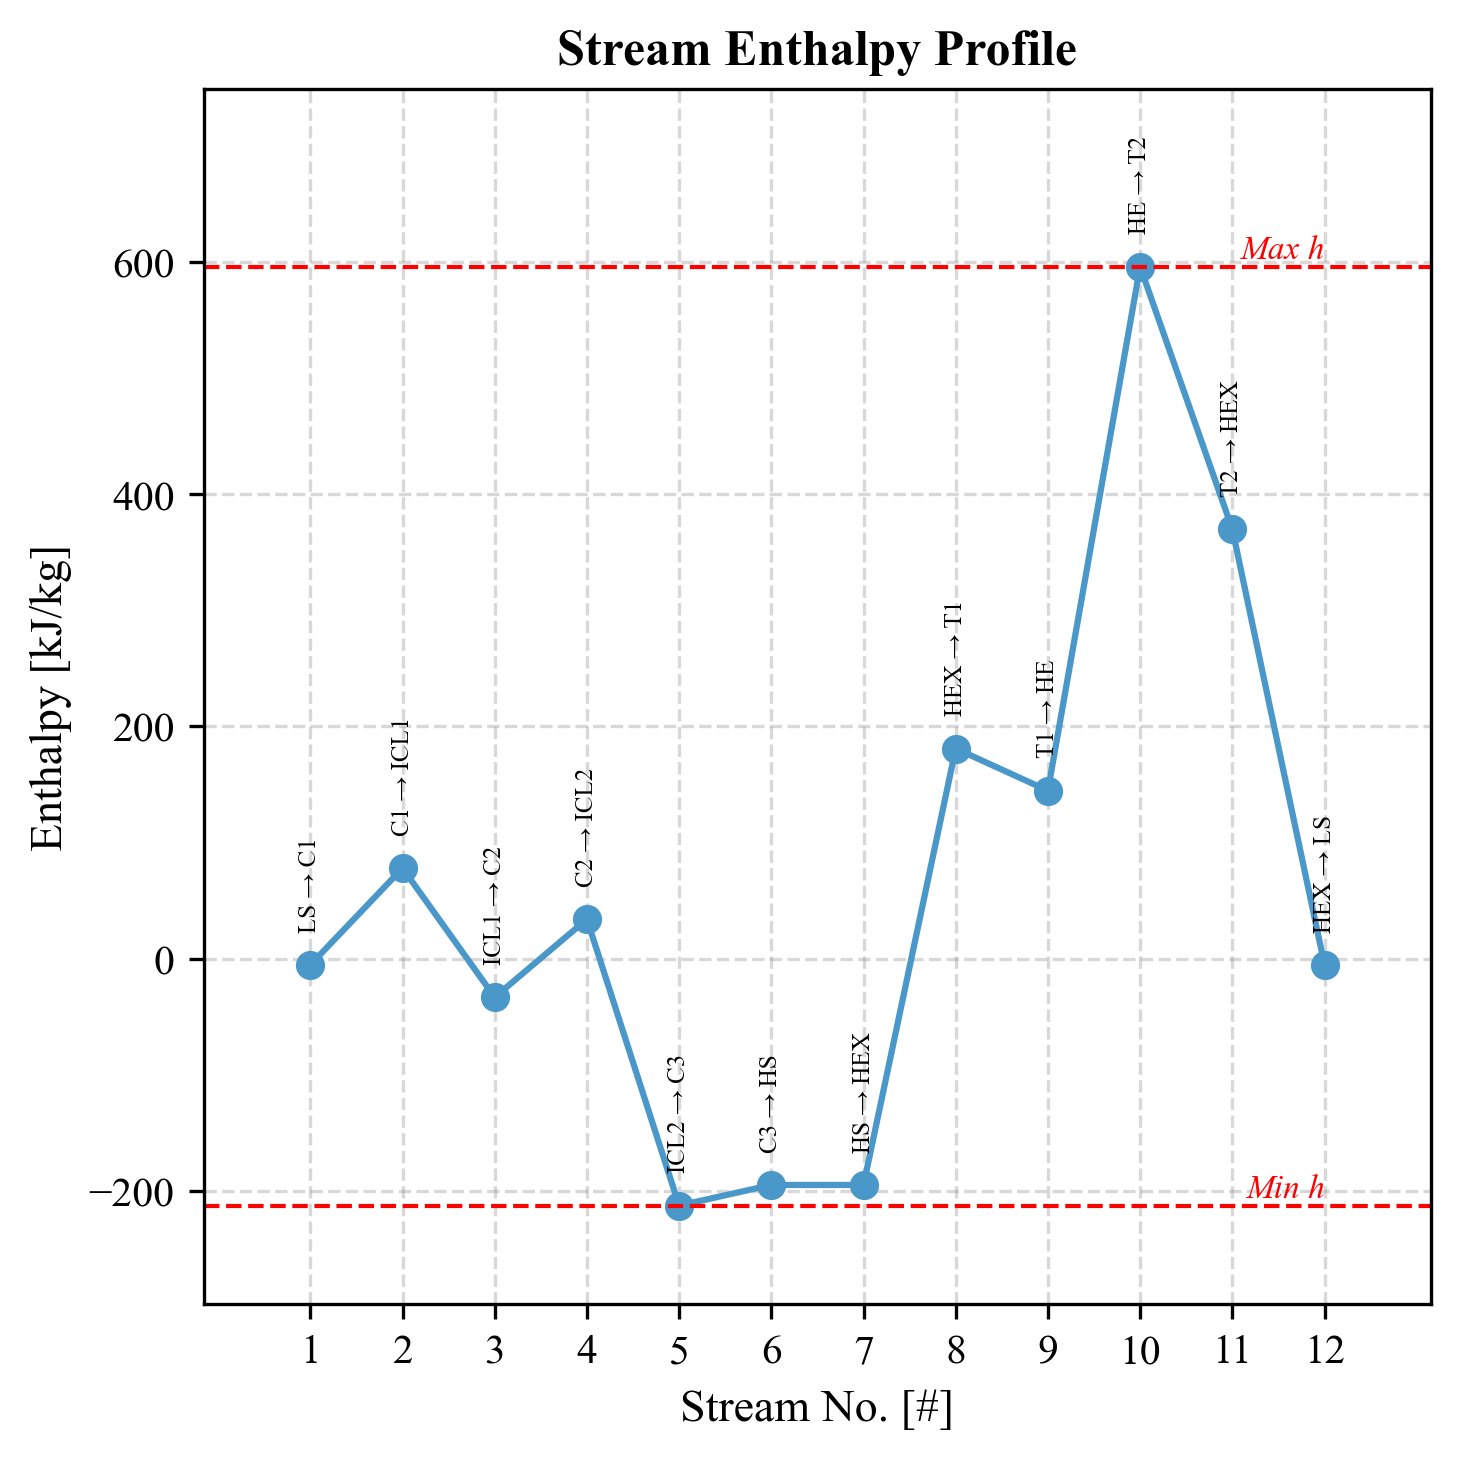

In [104]:
Thermodynamic_variable        = 'Enthalpy'
Thermodynamic_variable_symbol = 'h'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 15,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 15,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

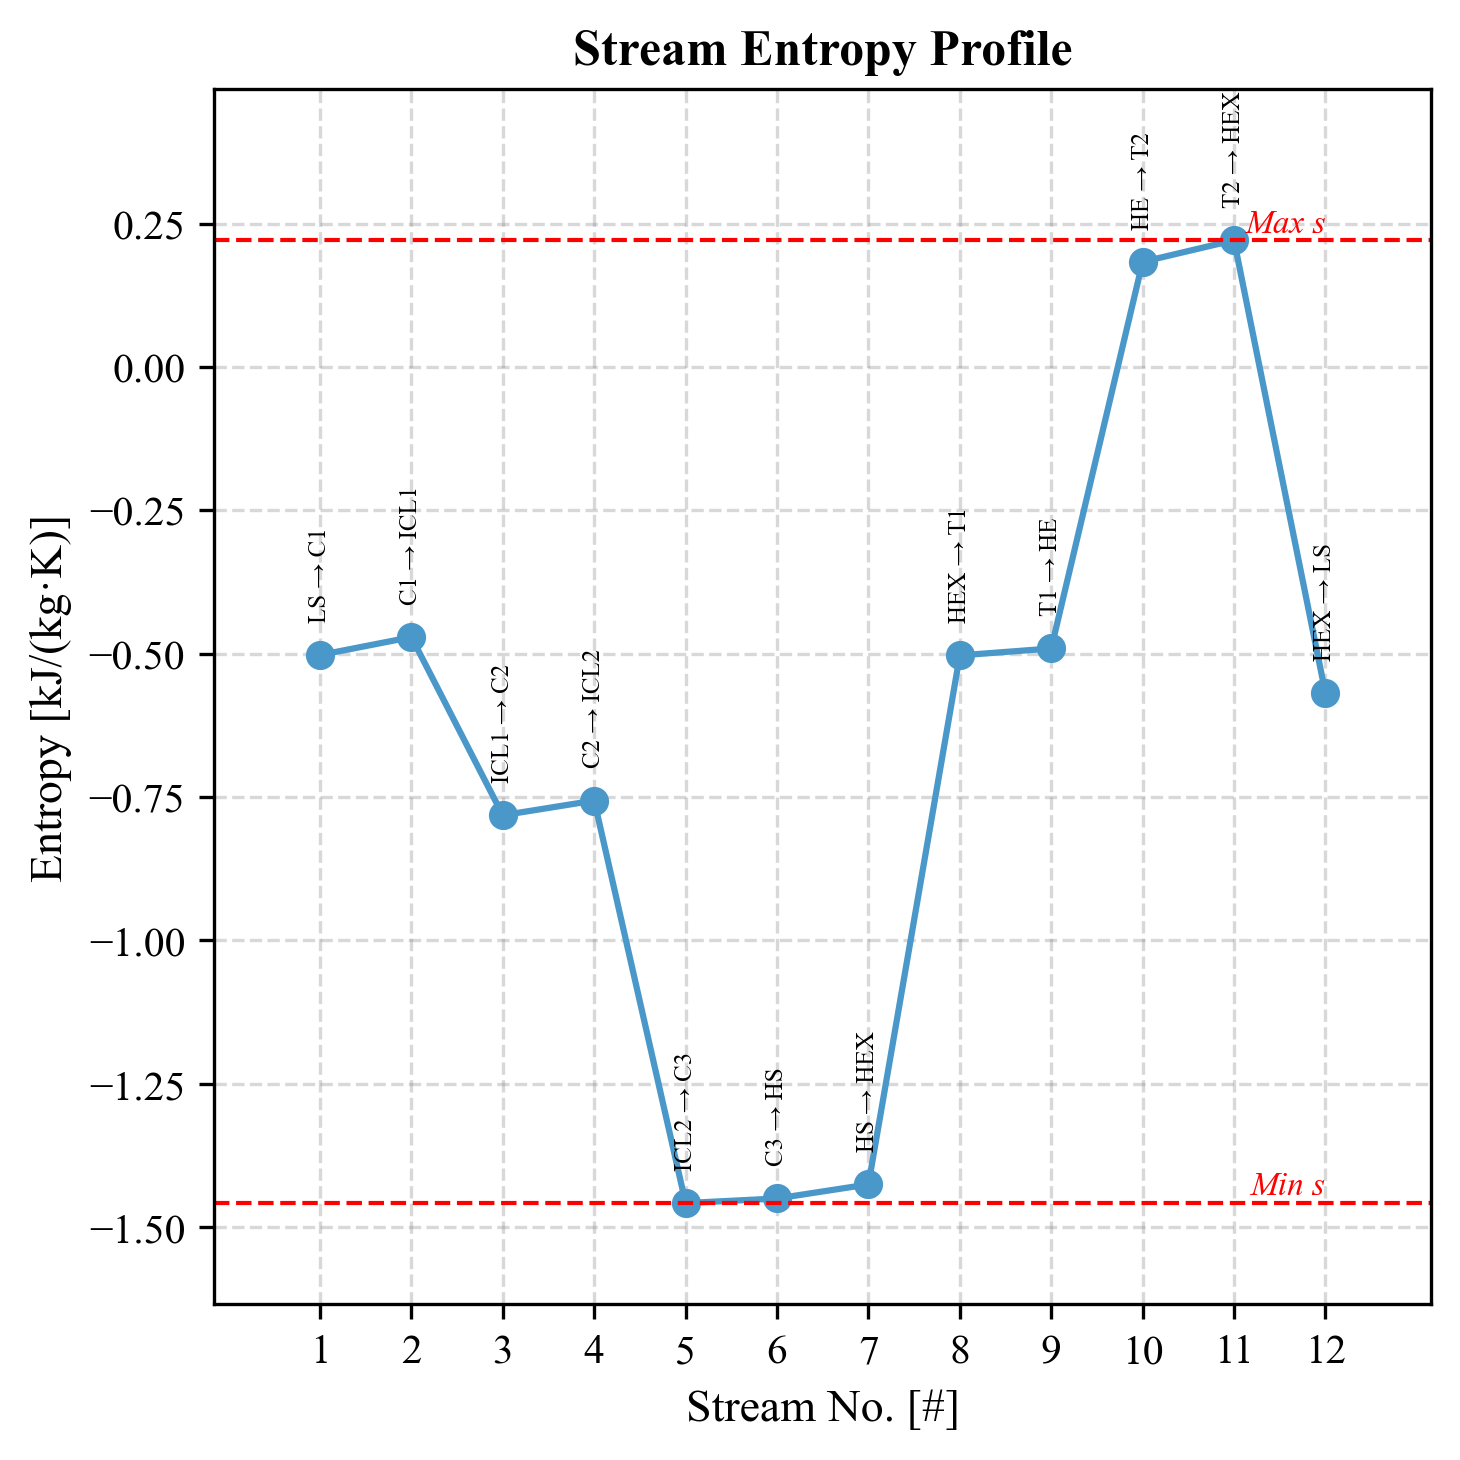

In [105]:
Thermodynamic_variable        = 'Entropy'
Thermodynamic_variable_symbol = 's'
Units                         = 'kJ/(kg·K)'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 0.03,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 0.03,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.22)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

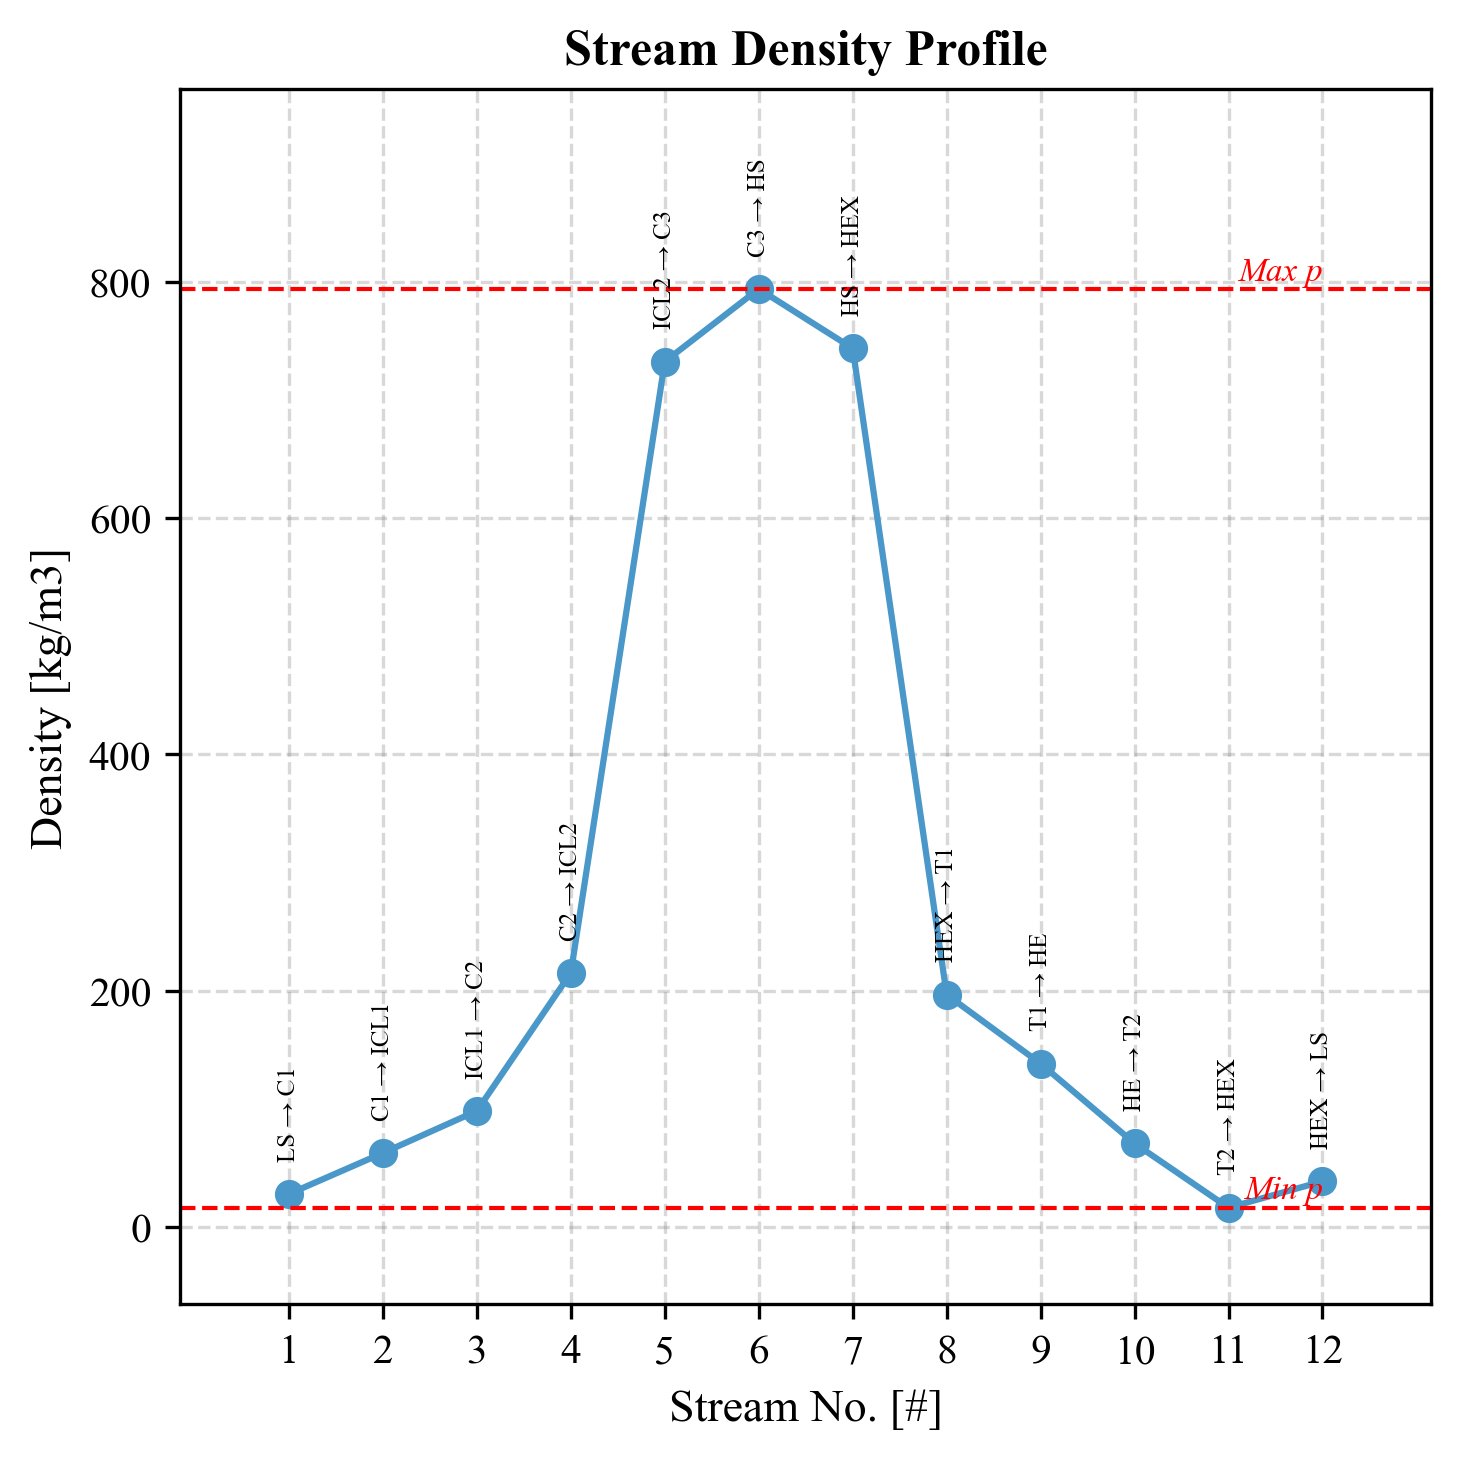

In [106]:
Thermodynamic_variable        = 'Density'
Thermodynamic_variable_symbol = 'p'
Units                         = 'kg/m3'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 15,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 15,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Cycle Visualizations

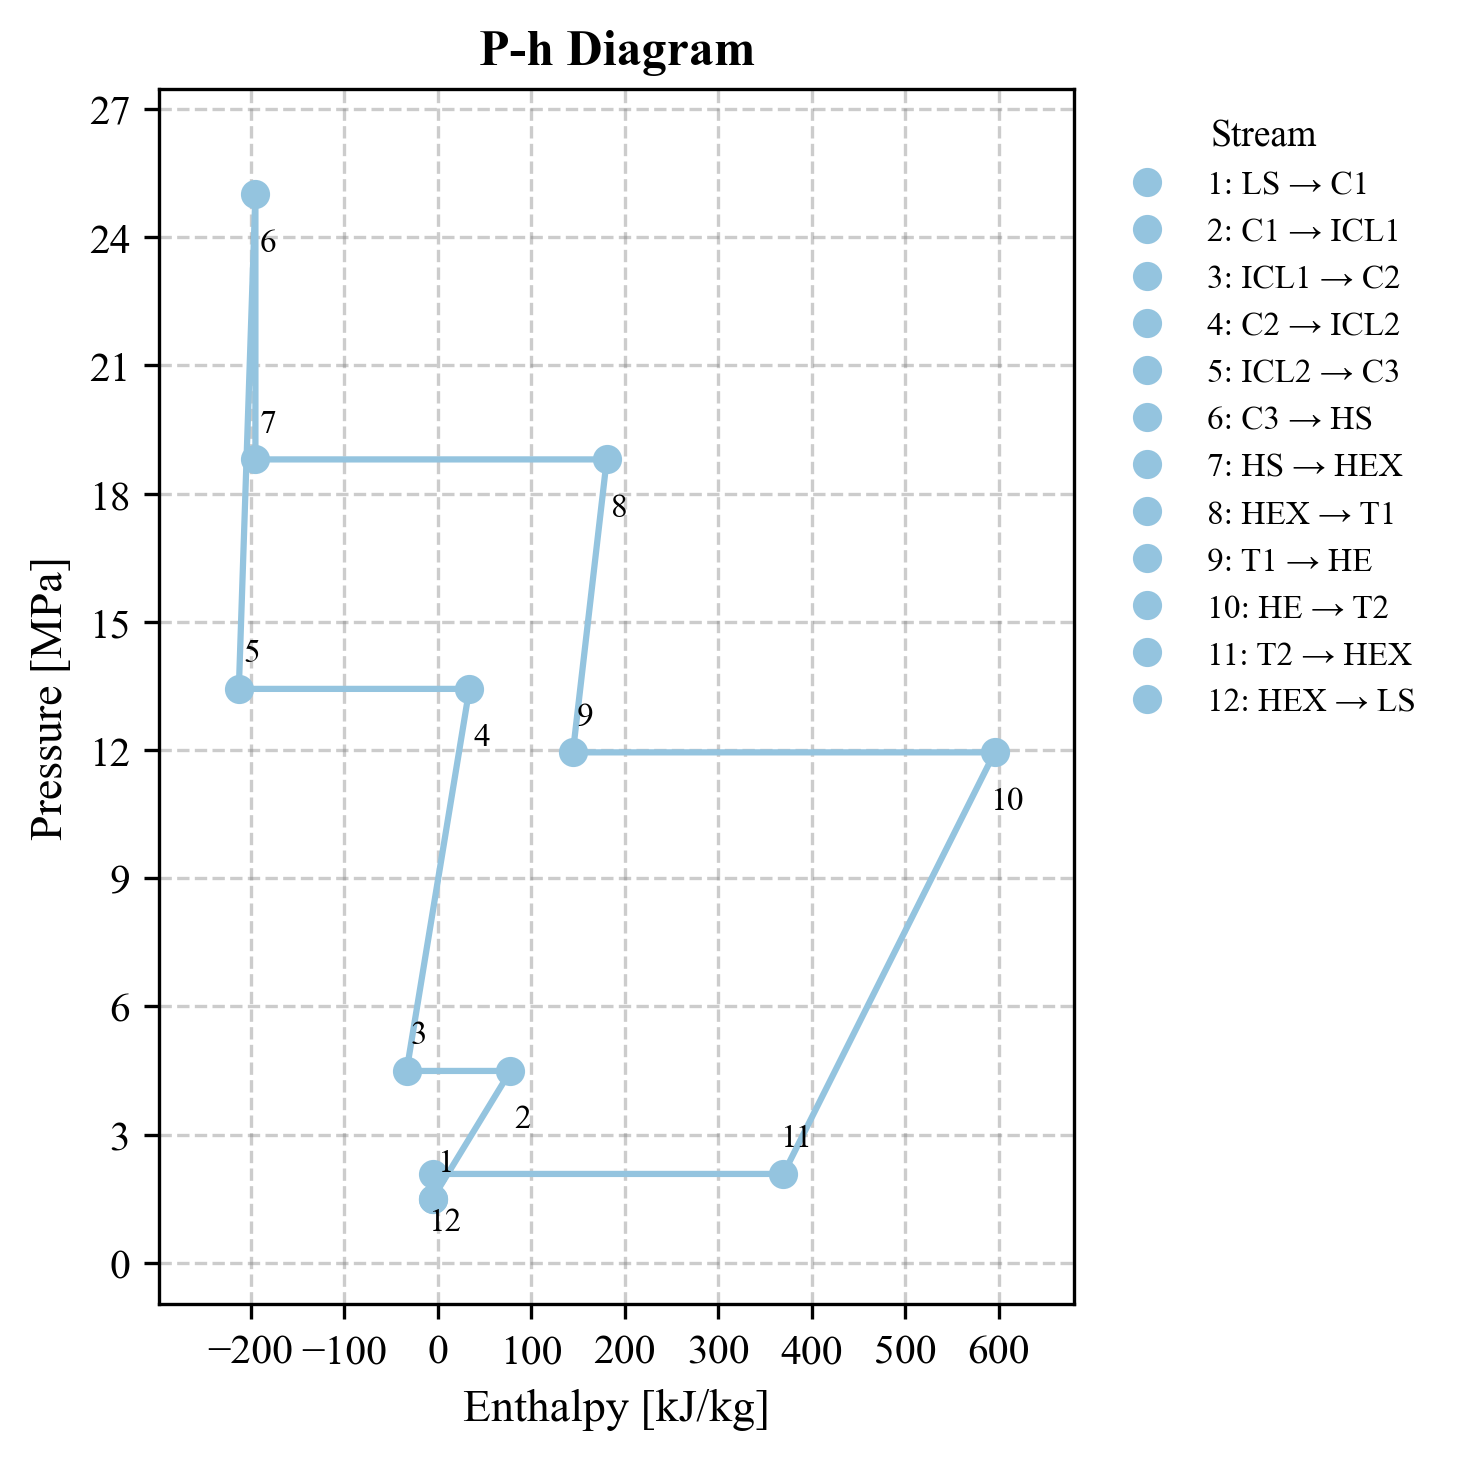

In [107]:
x_var         = 'Enthalpy'
x_var_sym     = 'h'
x_var_units   = 'kJ/kg'
y_var         = 'Pressure'
y_var_sym     = 'P'
y_var_units   = 'MPa'
Figure_title  = f'{y_var_sym}-{x_var_sym} Diagram'


x_orig      = df[x_var_sym].values; y_orig      = df[y_var_sym].values; x_data      = np.append(x_orig, x_orig[0]); y_data      = np.append(y_orig, y_orig[0])
stream_nums   = df['Stream_#'].astype(int).values; stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap      = plt.get_cmap('Blues'); line_color = cmap(0.4)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel=f'{x_var} [{x_var_units}]',ylabel=f'{y_var} [{y_var_units}]',title=Figure_title,figsize=figsize_std,dpi=300)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax.yaxis.set_major_locator(MaxNLocator(nbins=10)); ax.grid(True, which='major', linestyle='--', alpha=0.4); offsets = [(3, 5), (3, -8)]
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dx, dy = offsets[i % len(offsets)]
    ax.annotate(str(sn),xy=(xi, yi),xytext=(dx, dy),textcoords='offset points',fontsize=8,color='black',ha='center',va='bottom' if dy > 0 else 'top')
handles = [Line2D([0], [0], marker='o', color=line_color, linestyle='') for _ in stream_nums]
legend_labels = [f"{sn}: {lbl}" for sn, lbl in zip(stream_nums, stream_labels)]; ax.legend(handles,legend_labels,title='Stream',loc='upper left',bbox_to_anchor=(1.01, 1),fontsize=8,title_fontsize=9,frameon=False)
plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

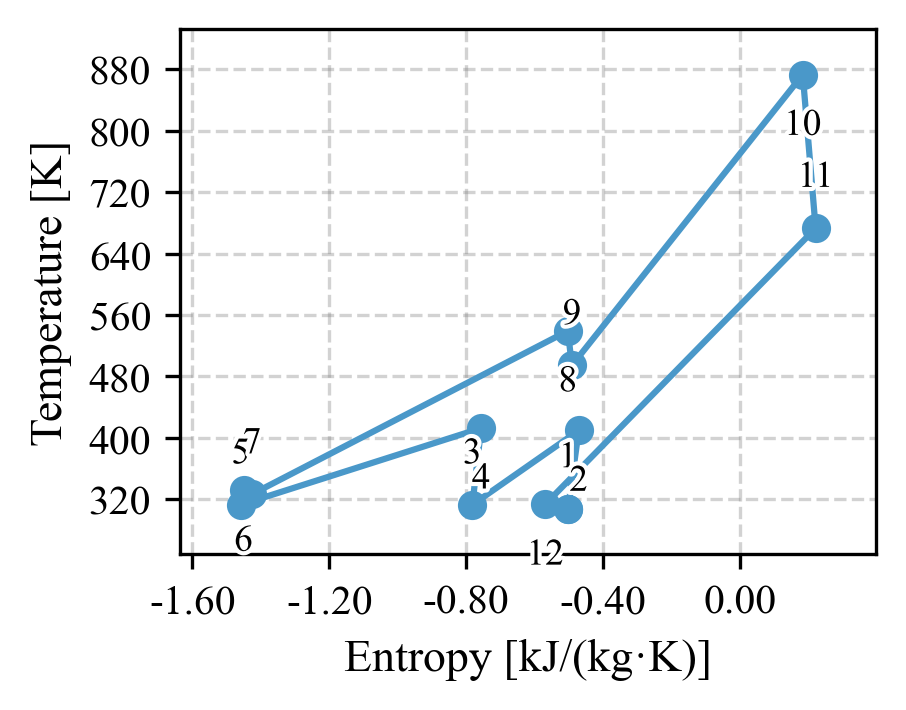

In [108]:
x_var         = 'Entropy'
x_var_sym     = 's'
x_var_units   = 'kJ/(kg·K)'
y_var         = 'Temperature'
y_var_sym     = 'T'
y_var_units   = 'K'
Figure_title  = f'{y_var_sym}-{x_var_sym} Diagram'

x_orig      = df[x_var_sym].values
y_orig      = df[y_var_sym].values
x_data      = np.append(x_orig, x_orig[0])
y_data      = np.append(y_orig, y_orig[0])
stream_nums = df['Stream_#'].astype(int).values
stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap        = plt.get_cmap('Blues')
line_color  = cmap(0.6)

# Plot
ax = quant_vis(
    x=x_data, y=y_data, kind='line', marker='o', color=line_color,
    xlabel=f'{x_var} [{x_var_units}]',
    ylabel=f'{y_var} [{y_var_units}]',
    title="",   # remove figure title
    figsize=(3.15, 2.5), dpi=300
)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.patheffects as pe

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))                 
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:.2f}"))
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

ax.grid(True, which='major', linestyle='--', alpha=0.35)

LABEL_OFFSET = 8  
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dy = LABEL_OFFSET if (i % 2 == 0) else -LABEL_OFFSET   
    txt = ax.annotate(
        str(sn), xy=(xi, yi), xytext=(0, dy),
        textcoords='offset points', fontsize=9, color='black',
        ha='center', va='bottom' if dy > 0 else 'top', clip_on=False
    )
    txt.set_path_effects([pe.withStroke(linewidth=2, foreground='white')])

ax.legend([], [], frameon=False)

plt.tight_layout()

out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


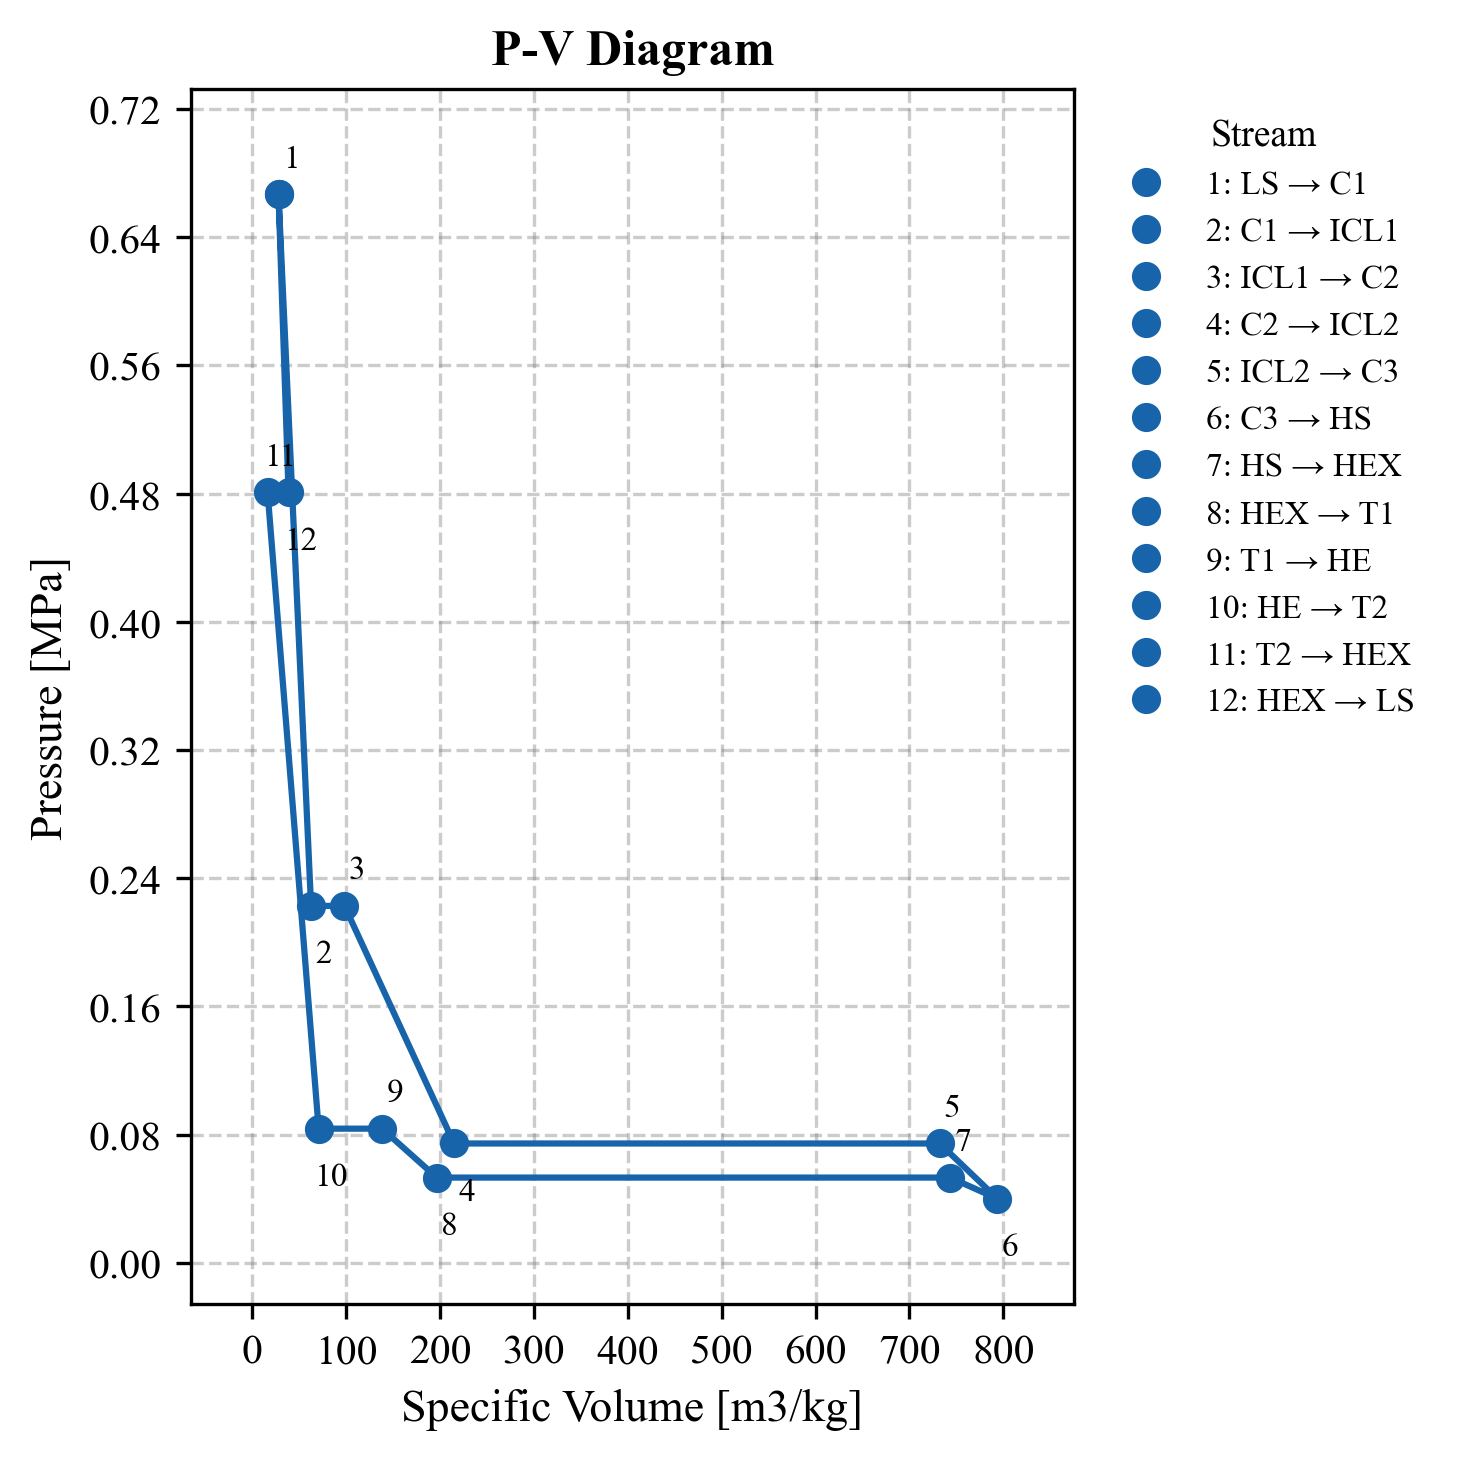

In [109]:
x_var         = 'Specific Volume'
x_var_sym     = 'p'
x_var_units   = 'm3/kg'
y_var         = 'Pressure'
y_var_sym     = 'P'
y_var_units   = 'MPa'
Figure_title  = f'{y_var_sym}-V Diagram'


x_orig      = df[x_var_sym].values; y_orig      = df[y_var_sym].values; y_orig = 1/y_orig; x_data      = np.append(x_orig, x_orig[0]); y_data      = np.append(y_orig, y_orig[0])
stream_nums   = df['Stream_#'].astype(int).values; stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap      = plt.get_cmap('Blues'); line_color = cmap(0.8)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel=f'{x_var} [{x_var_units}]',ylabel=f'{y_var} [{y_var_units}]',title=Figure_title,figsize=figsize_std,dpi=300)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax.yaxis.set_major_locator(MaxNLocator(nbins=10)); ax.grid(True, which='major', linestyle='--', alpha=0.4); offsets = [(3, 5), (3, -8)]
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dx, dy = offsets[i % len(offsets)]
    ax.annotate(str(sn),xy=(xi, yi),xytext=(dx, dy),textcoords='offset points',fontsize=8,color='black',ha='center',va='bottom' if dy > 0 else 'top')
handles = [Line2D([0], [0], marker='o', color=line_color, linestyle='') for _ in stream_nums]
legend_labels = [f"{sn}: {lbl}" for sn, lbl in zip(stream_nums, stream_labels)]; ax.legend(handles,legend_labels,title='Stream',loc='upper left',bbox_to_anchor=(1.01, 1),fontsize=8,title_fontsize=9,frameon=False)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Storage Visualizations

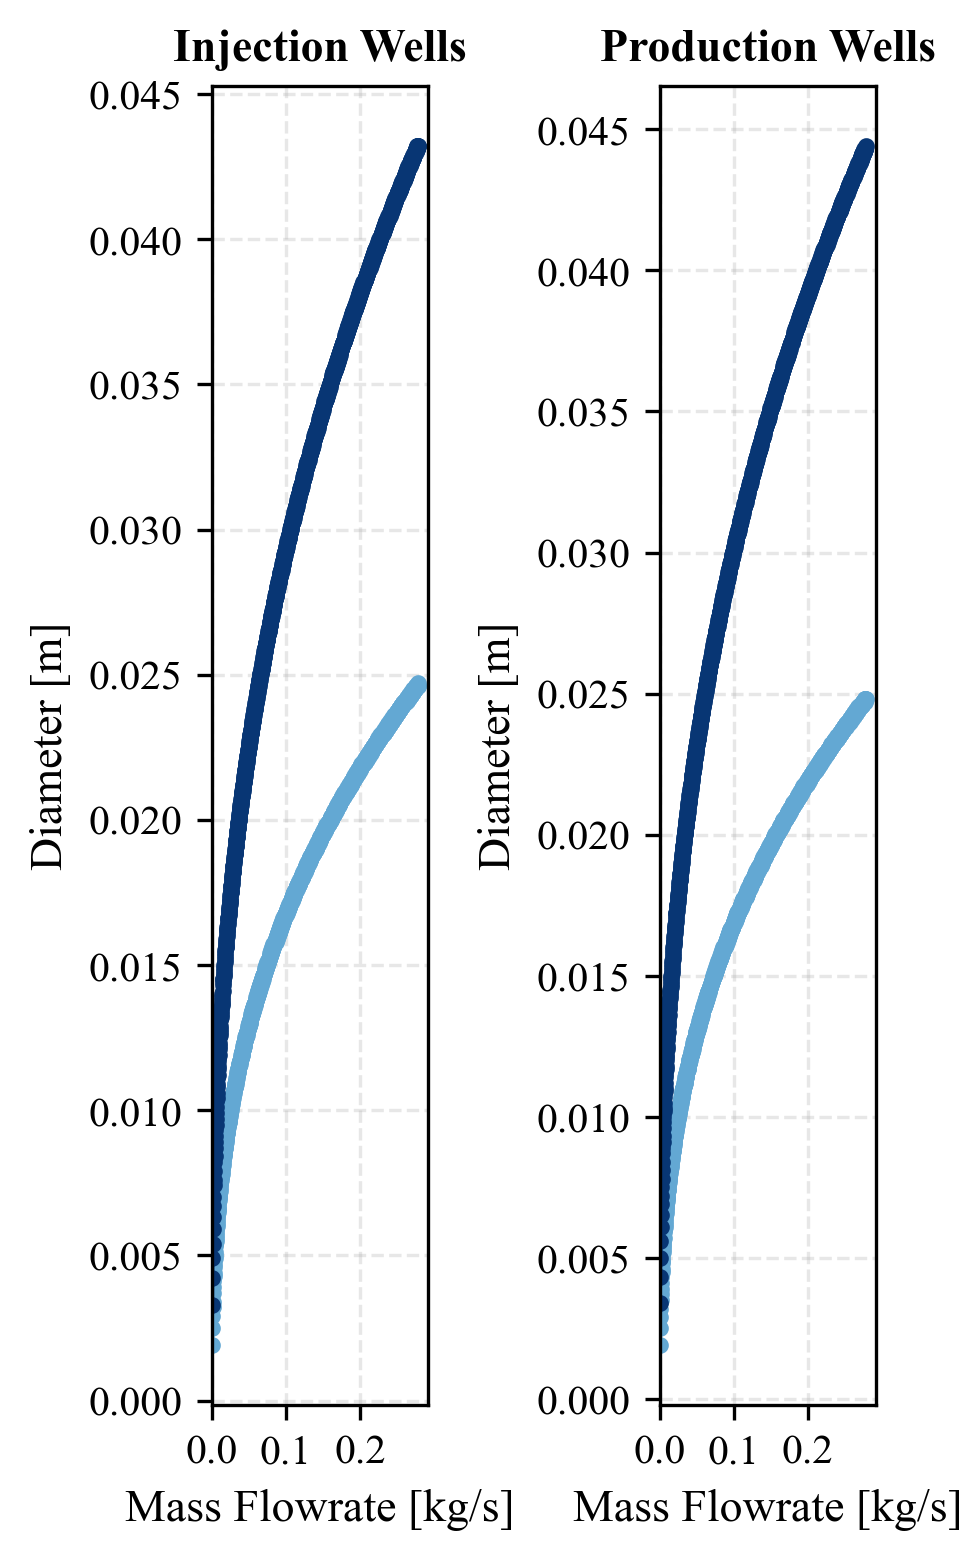

In [110]:
from matplotlib.ticker import MaxNLocator

Figure_title = f'Required Well Diameters - fric:{gradP} MPa/m'
File_title   = 'Required_Well_Diameters'

fig, axs = plt.subplots(ncols=2, figsize=(3.15, 5.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap   = plt.get_cmap('Blues')
hues   = np.linspace(0.3, 0.975, 4)
colors = cmap(hues)
hs_color = colors[1]
ls_color = colors[3]

ax = axs[0]
ax.plot(dfDm_HS_inj_well['mdot'], dfDm_HS_inj_well['Dsol'],
        marker='o', markersize=3, linewidth=1, color=hs_color)
ax.plot(dfDm_LS_inj_well['mdot'], dfDm_LS_inj_well['Dsol'],
        marker='o', markersize=3, linewidth=1, color=ls_color)
ax.set_xlabel('Mass Flowrate [kg/s]')
ax.set_ylabel('Diameter [m]')
ax.set_title('Injection Wells', fontsize=11)
ax.grid(True, which='both', linestyle='--', alpha=0.3)
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))  # fewer ticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
ax.set_xlim(left=0.00)

ax = axs[1]
ax.plot(dfDm_HS_prod_well['mdot'], dfDm_HS_prod_well['Dsol'],
        marker='o', markersize=3, linewidth=1, color=hs_color)
ax.plot(dfDm_LS_prod_well['mdot'], dfDm_LS_prod_well['Dsol'],
        marker='o', markersize=3, linewidth=1, color=ls_color)
ax.set_xlabel('Mass Flowrate [kg/s]')
ax.set_ylabel('Diameter [m]')
ax.set_title('Production Wells', fontsize=11)
ax.grid(True, which='both', linestyle='--', alpha=0.3)
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))  # fewer ticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
ax.set_xlim(left=0.00)

for ax in axs:
    ax.legend([], [], frameon=False)

fig.suptitle("")

plt.tight_layout()

out_path = fig_dir / f"{File_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


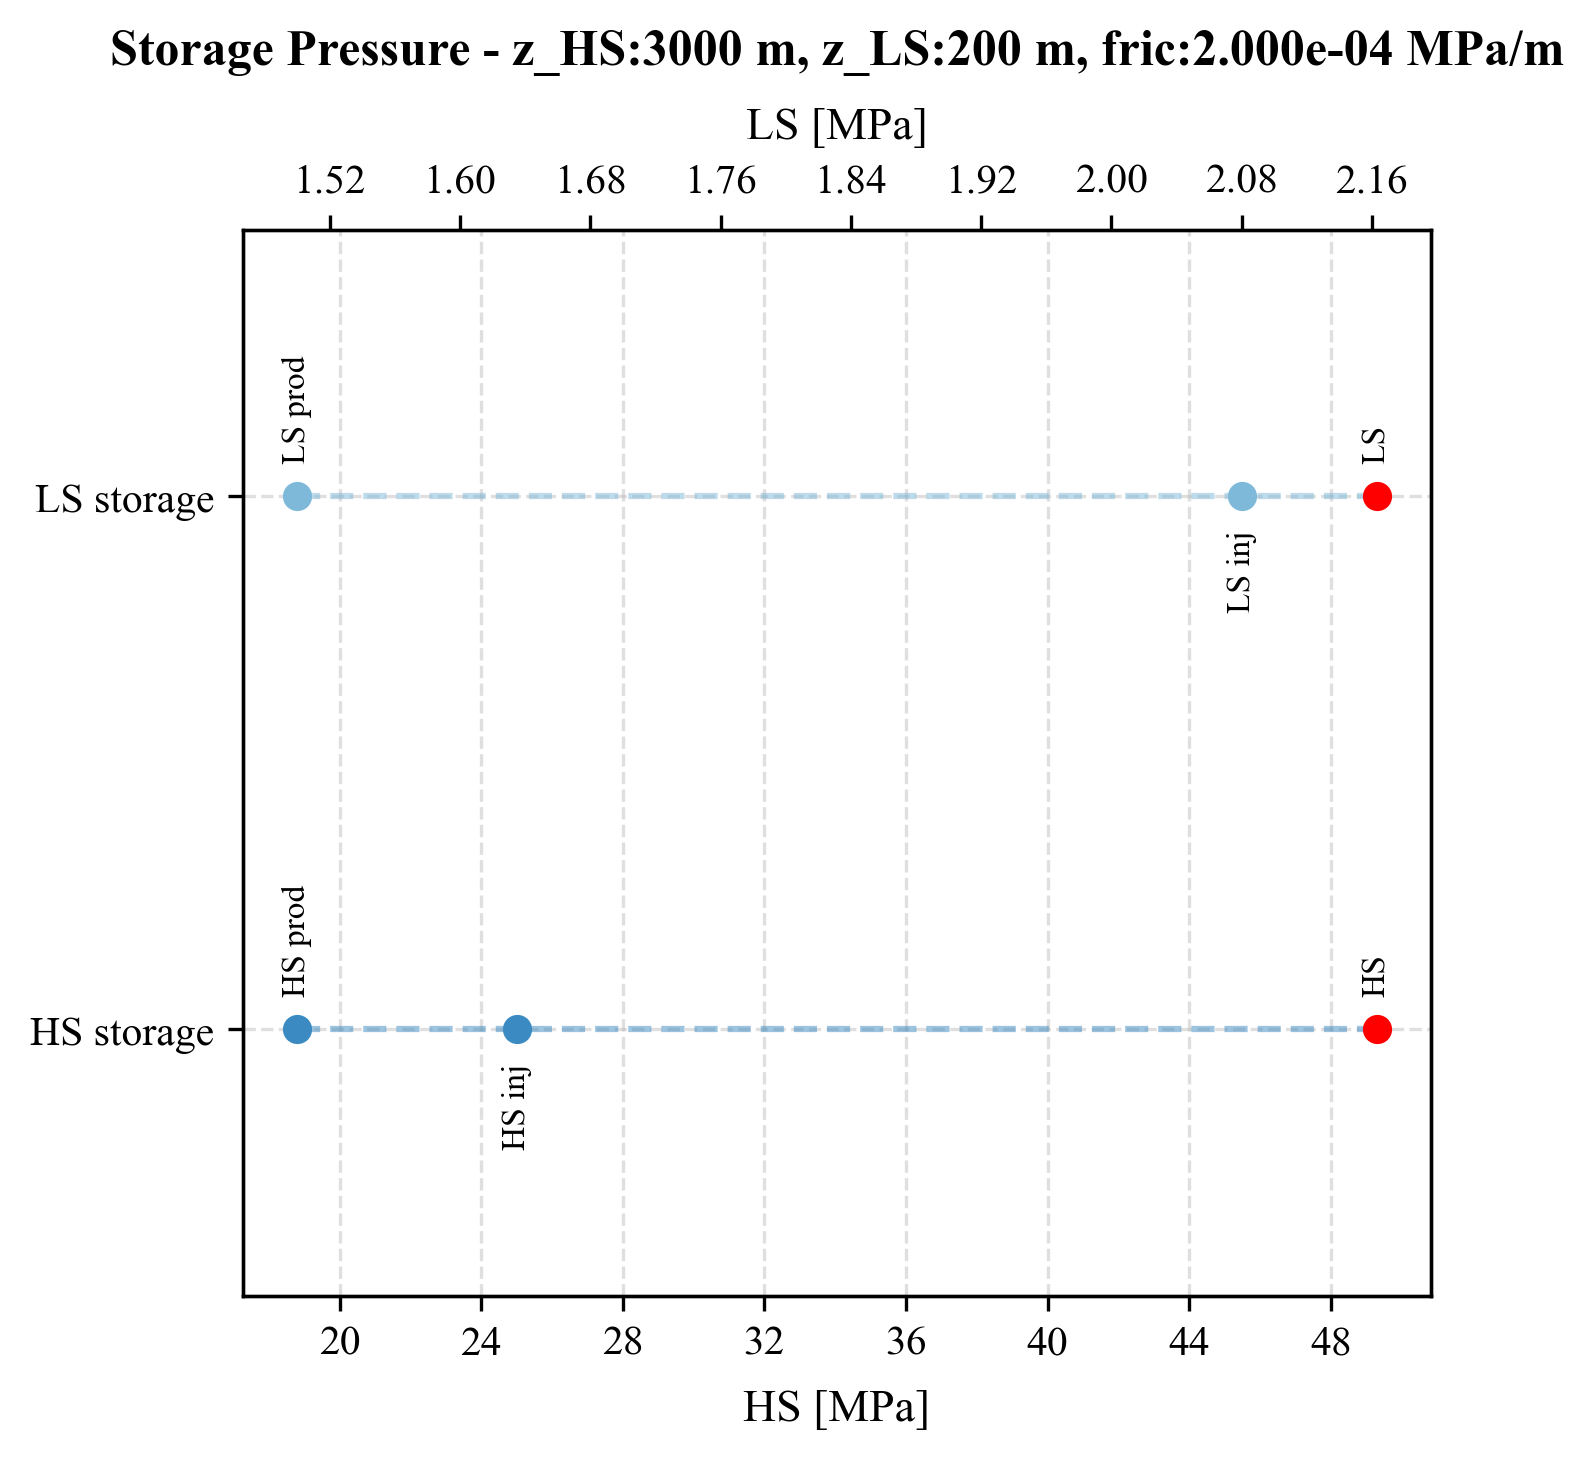

In [111]:
x_var       = 'Pressure'        
x_var_sym   = 'P'               
x_var_units = 'MPa'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

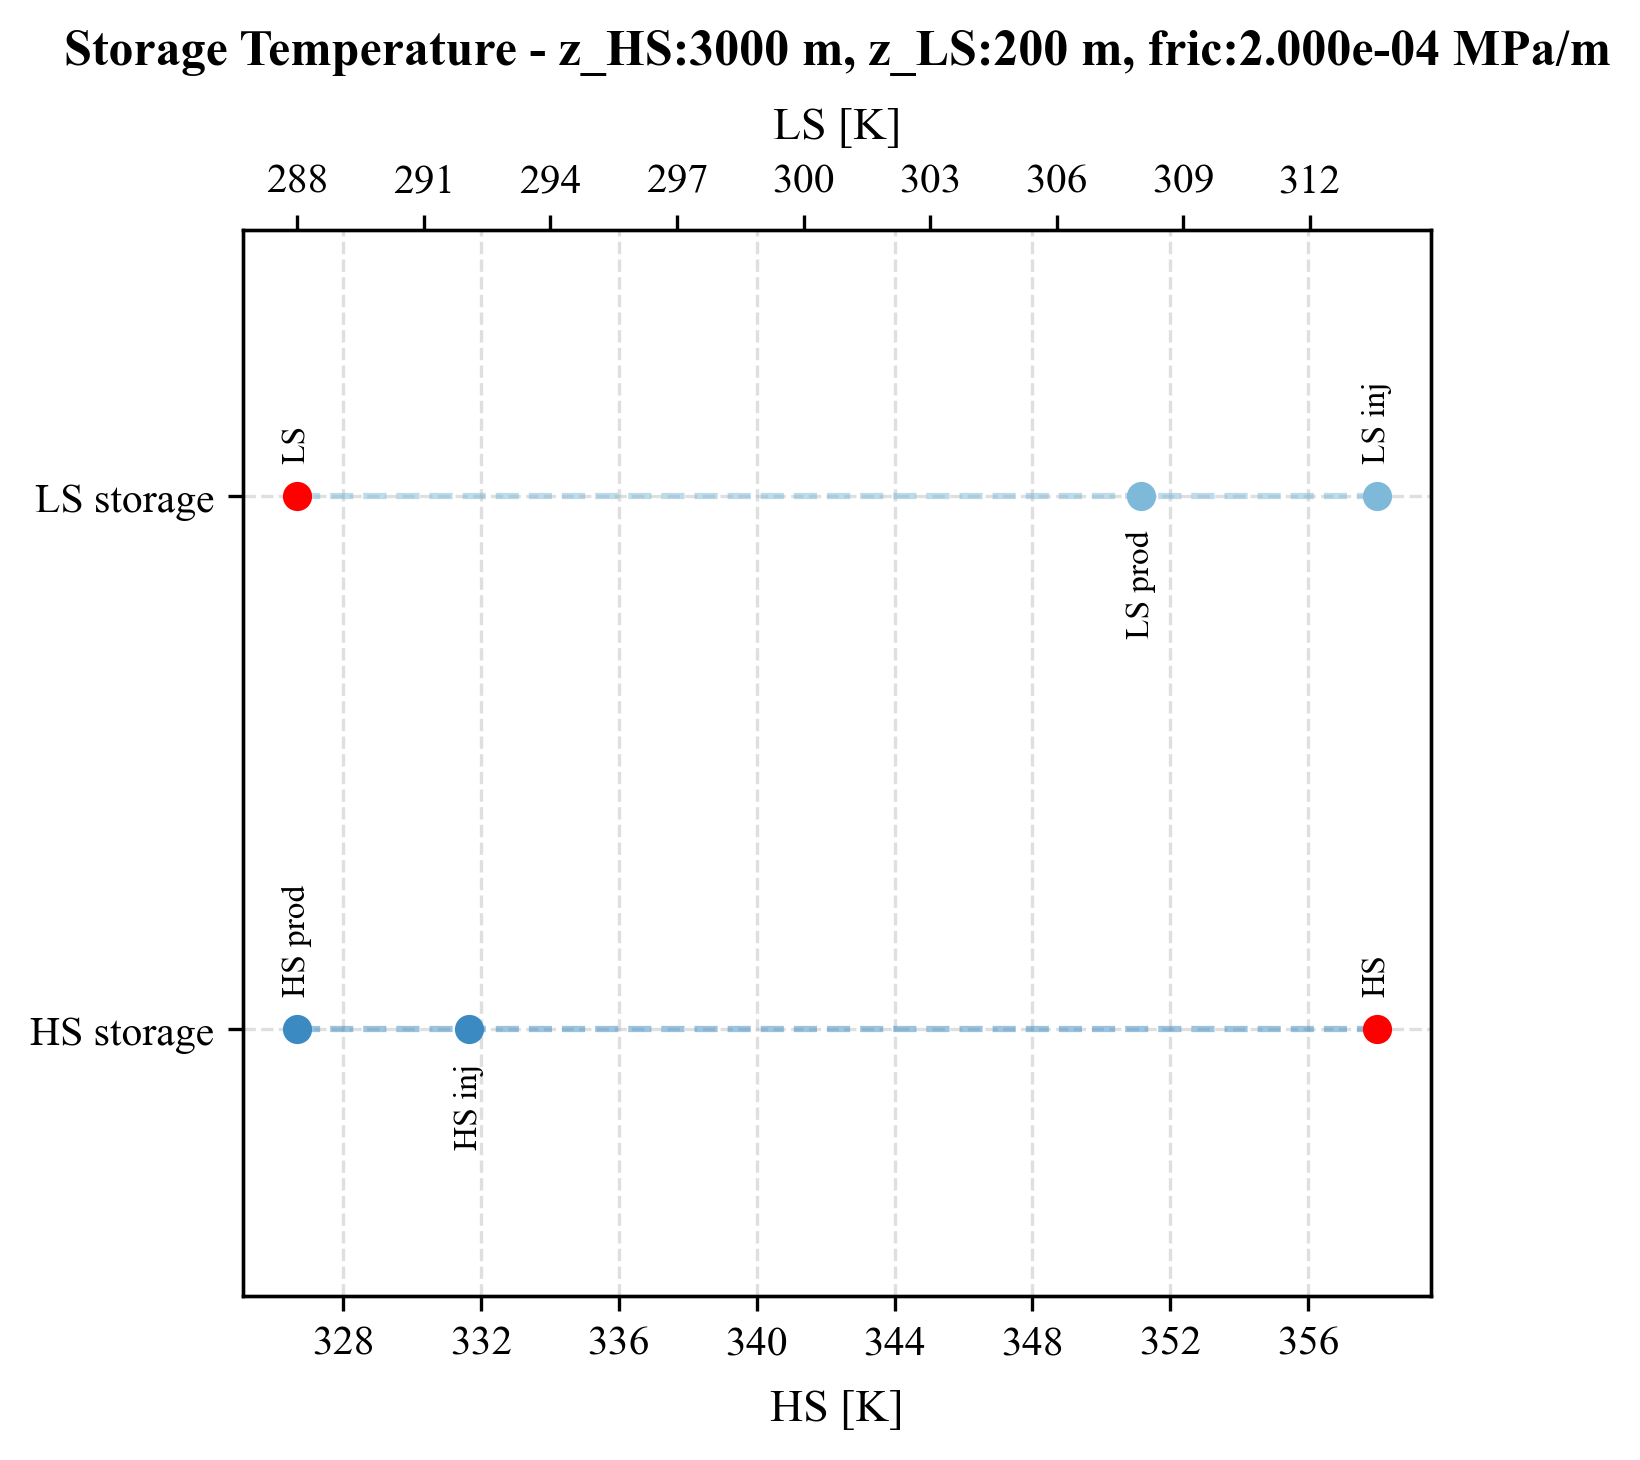

In [112]:
x_var       = 'Temperature'        
x_var_sym   = 'T'               
x_var_units = 'K'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

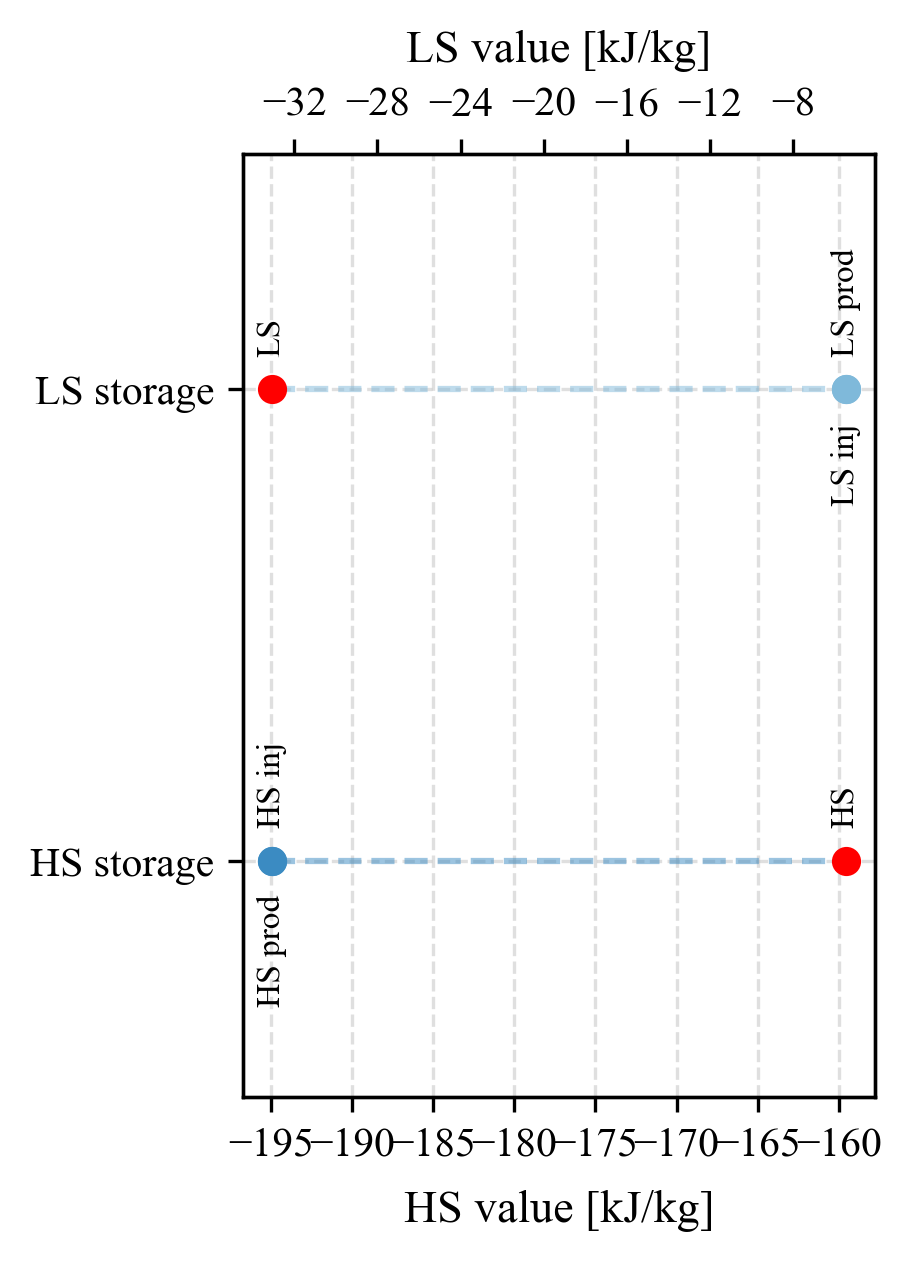

In [113]:
x_var       = 'Enthalpy'        
x_var_sym   = 'h'               
x_var_units = 'kJ/kg'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title   = f'Storage_{x_var}s'

# Streams
ls_inj    = dffull.loc[dffull.To_component=='LS', 'Stream_#'].iat[0]
ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS', 'Stream_#'].iat[0]
hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#'])
dfi       = dffull.set_index('Stream_#')

hs_streams = [hs_inj, hs_char, hs_prod]
ls_streams = [ls_inj, ls_char, ls_prod]

x_hs = dfi.loc[hs_streams, x_var_sym].values
x_ls = dfi.loc[ls_streams, x_var_sym].values

def expand(vals):
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng

hs_xlim = expand(x_hs)
ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=(3.15, 4.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap     = plt.get_cmap('Blues')
hs_base  = cmap(0.65)
ls_base  = cmap(0.45)
hs_cols  = [hs_base, 'red', hs_base]
ls_cols  = [ls_base, 'red', ls_base]

role     = {
    hs_inj: 'HS inj', hs_char: 'HS', hs_prod: 'HS prod',
    ls_inj: 'LS inj', ls_char: 'LS', ls_prod: 'LS prod'
}
offsets  = [8, -8]

ax_ls = ax_hs.twiny()

ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]
    ax_hs.annotate(role[s], xy=(xx, 0), xytext=(0, dy), textcoords='offset points',
                   rotation=90, va='bottom' if dy > 0 else 'top', ha='center', fontsize=8)

ax_hs.set_xlim(*hs_xlim)
ax_hs.set_xlabel(f"HS value [{x_var_units}]", labelpad=6)

ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]
    ax_ls.annotate(role[s], xy=(xx, 1), xytext=(0, dy), textcoords='offset points',
                   rotation=90, va='bottom' if dy > 0 else 'top', ha='center', fontsize=8)

ax_ls.set_xlim(*ls_xlim)
ax_ls.xaxis.set_label_position('top')
ax_ls.xaxis.set_ticks_position('top')
ax_ls.set_xlabel(f"LS value [{x_var_units}]", labelpad=6)

ax_hs.set_yticks([0, 1])
ax_hs.set_yticklabels(['HS storage', 'LS storage'])
ax_hs.set_ylim(-0.5, 1.5)

ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=8))   # 8 ticks bottom (HS)
ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=8))   # 8 ticks top (LS)

ax_hs.grid(True, which='major', linestyle='--', alpha=0.4)

ax_hs.set_title("")
fig.suptitle("")
ax_hs.legend([], [], frameon=False)

plt.tight_layout()

out_path = fig_dir / f"{File_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


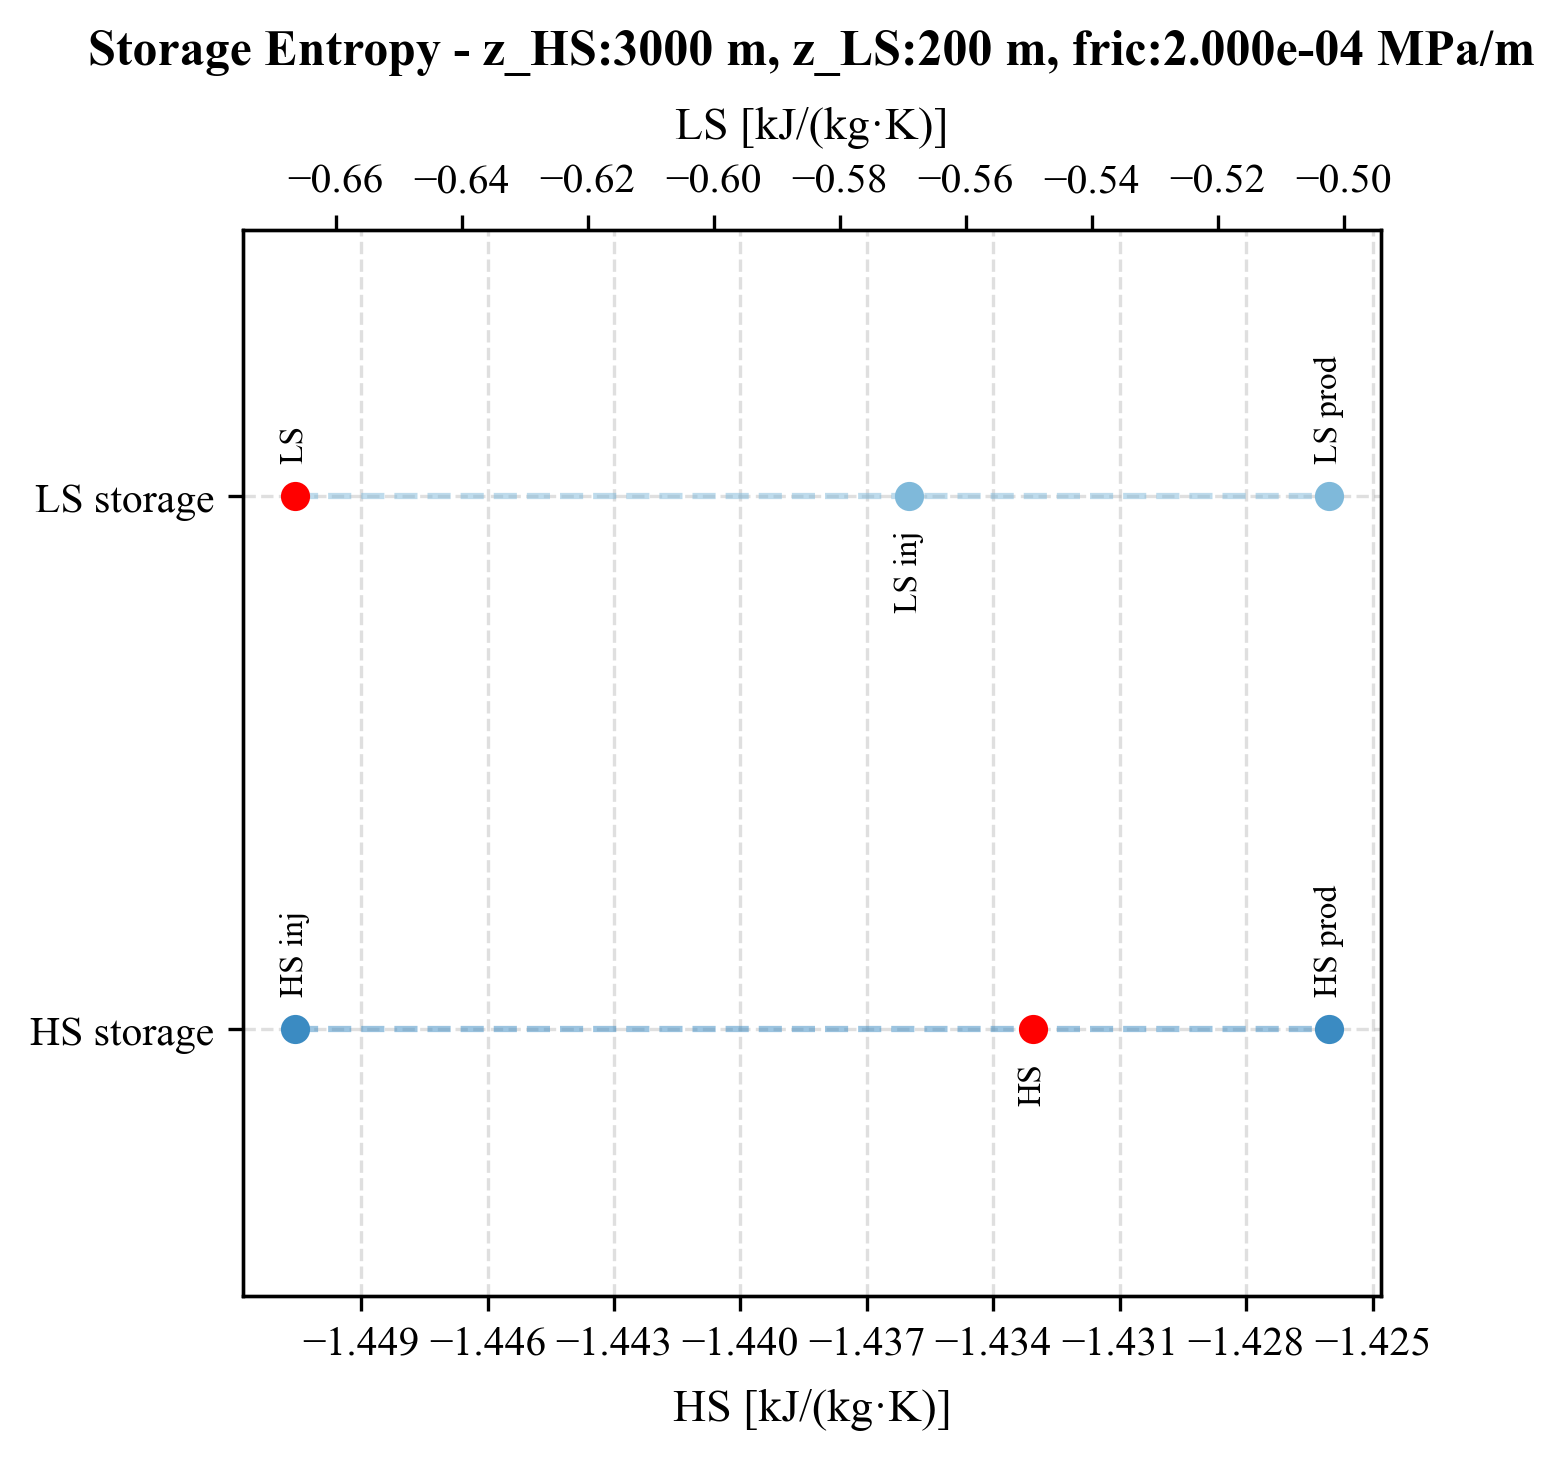

In [114]:
x_var       = 'Entropy'        
x_var_sym   = 's'               
x_var_units = 'kJ/(kg·K)'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)

plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

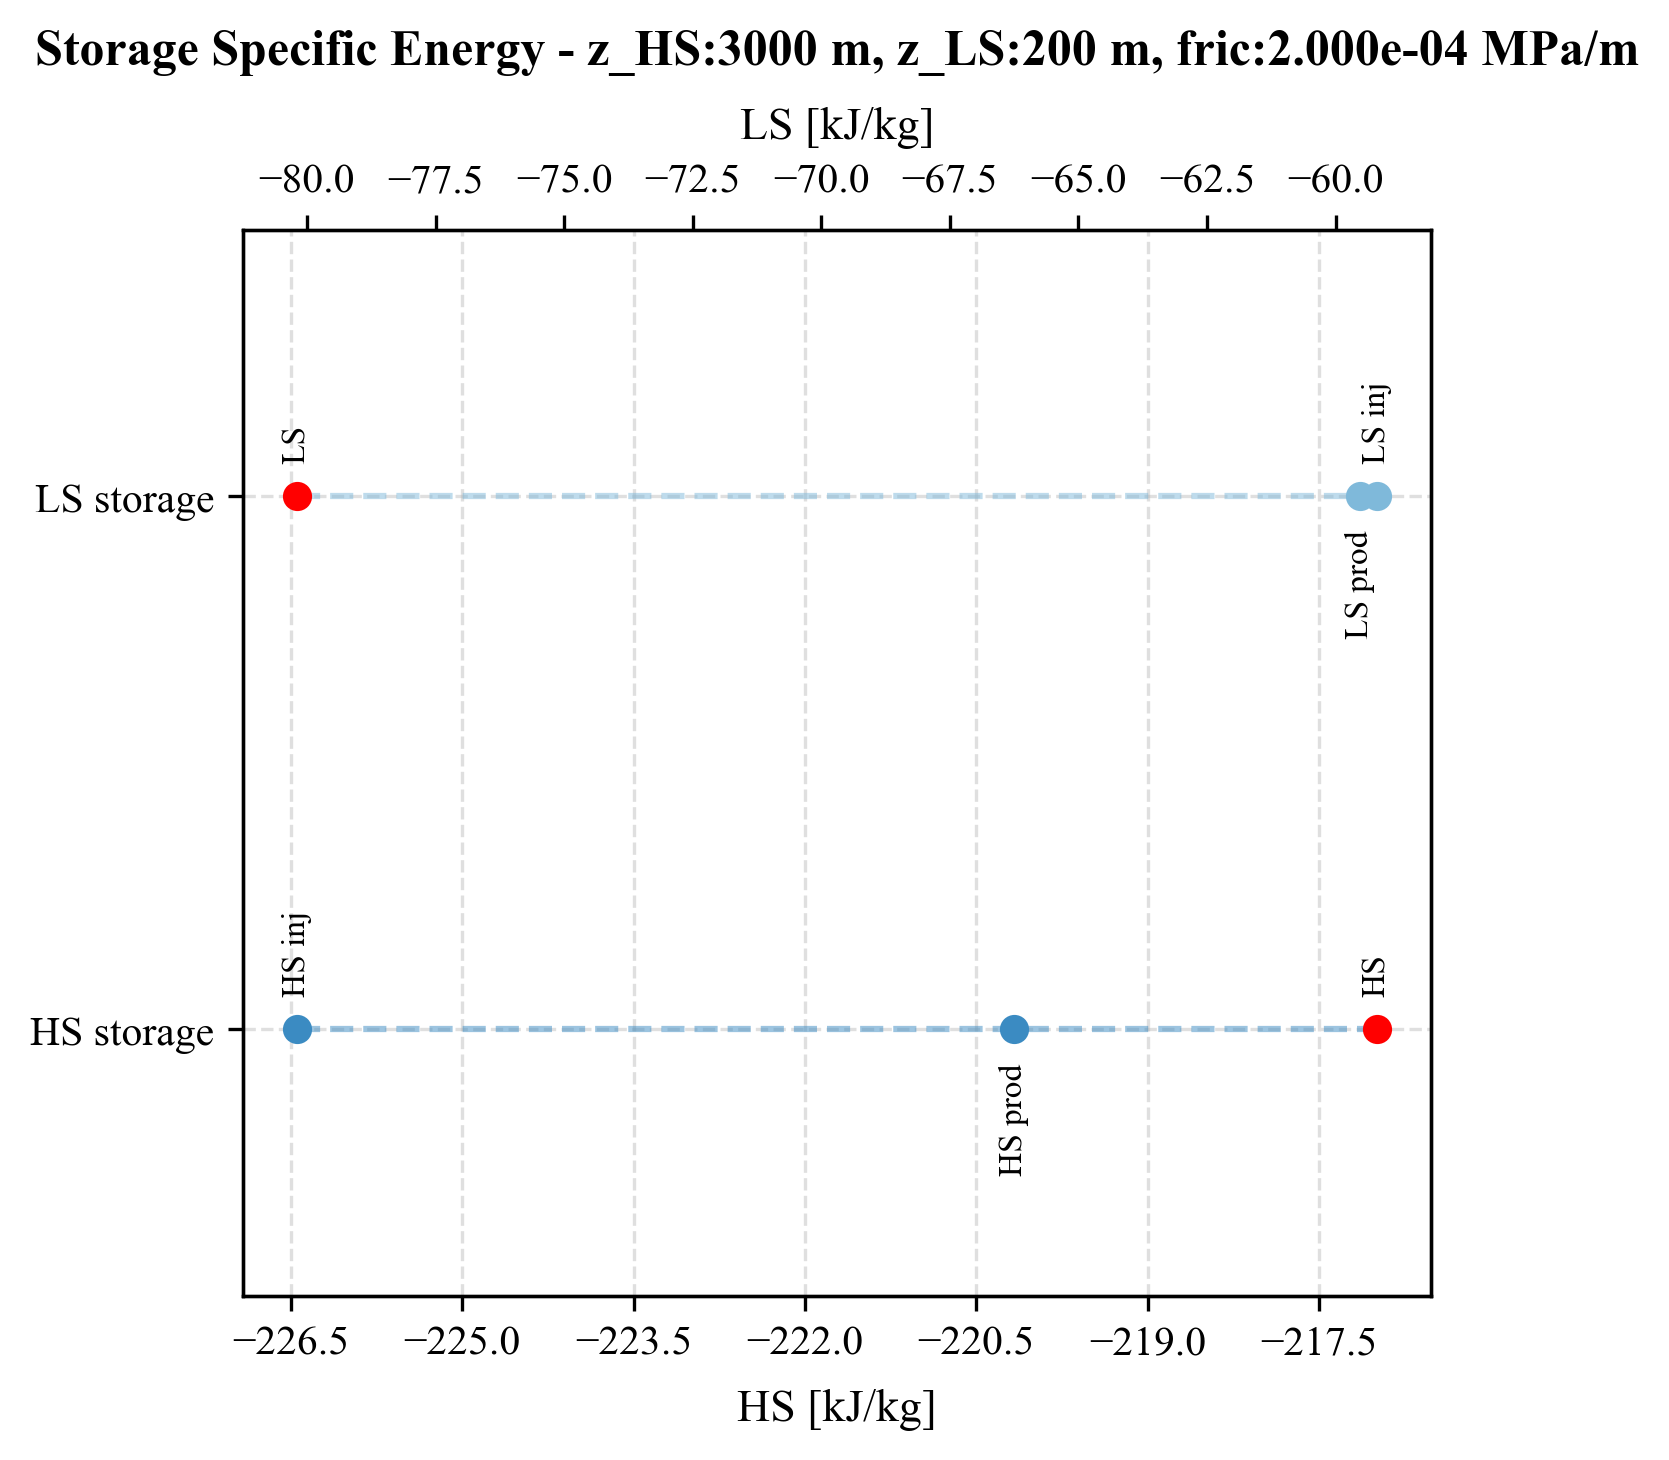

In [115]:
x_var       = 'Specific Energy'        
x_var_sym   = 'e'               
x_var_units = 'kJ/kg'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

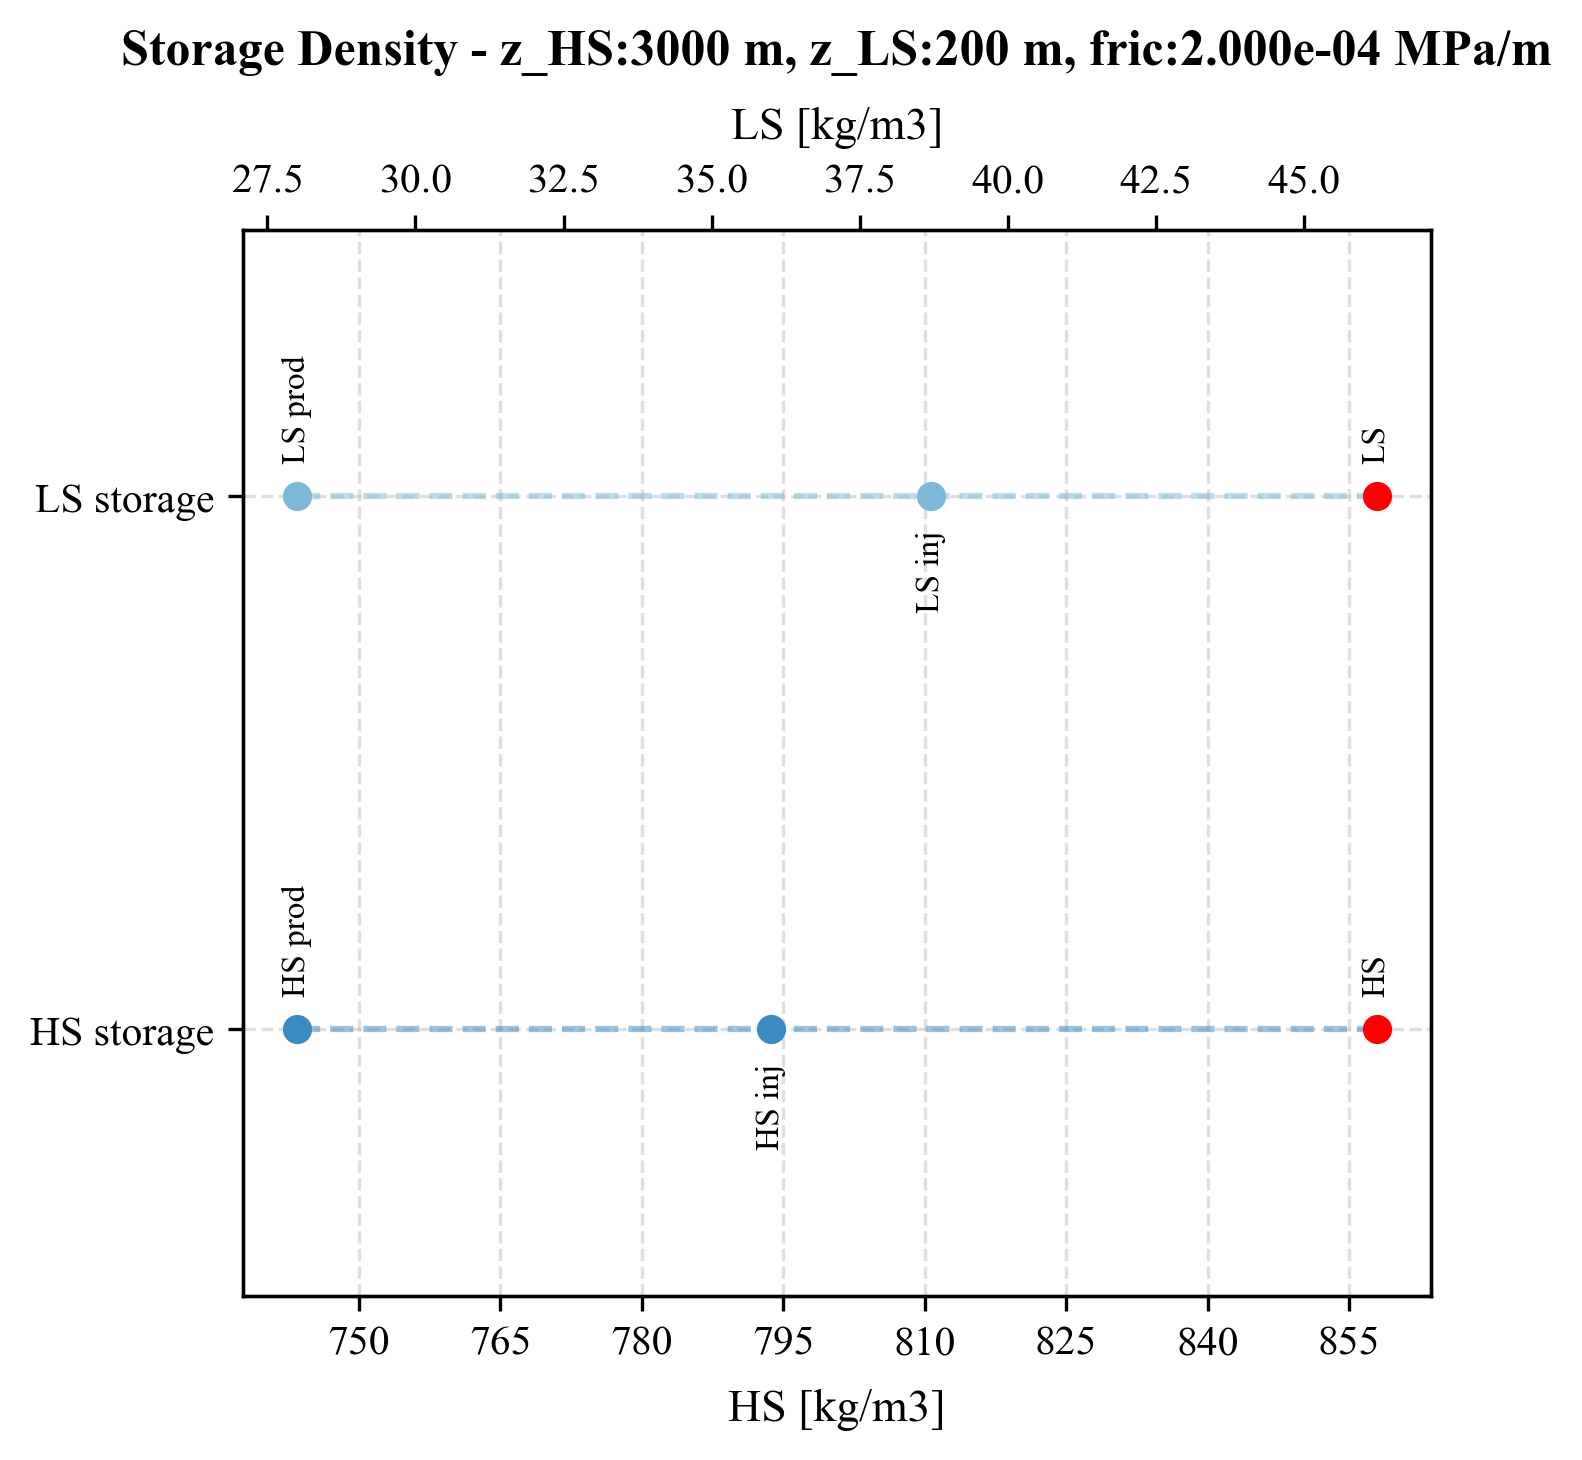

In [116]:
x_var       = 'Density'        
x_var_sym   = 'p'               
x_var_units = 'kg/m3'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

In [117]:
from matplotlib.ticker import FuncFormatter, MultipleLocator, LinearLocator
import math

def visualize_QSS(df, series_left, left_label, left_units,
                  series_right=None, right_label=None, right_units=None,
                  separate_axes=True, title="QSS Time Series",
                  figsize=(3.15, 5.8), dpi=300, cmap_name="Blues"):
    import numpy as np
    import matplotlib.pyplot as plt

    # Settlement periods (48 half-hours)
    sp = np.arange(1, 49)

    left_colors = plt.get_cmap(cmap_name)(np.linspace(0.60, 0.90, len(series_left)))
    right_colors = (plt.get_cmap('Greens')(
        np.linspace(0.45, 0.85, len(series_right))) if series_right else [])

    axis_left_color  = 'navy'
    axis_right_color = 'darkgreen'

    fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
    handles, labels = [], []

    for i, col in enumerate(series_left):
        h, = ax1.plot(sp, df[col], 'o-', color=left_colors[i], markersize=3, linewidth=1)
        handles.append(h); labels.append(col)
    ax1.set_ylabel(f"{left_label} {left_units}")
    
    def sci3_all(x, pos):
        if x == 0:
            return "0.00 e00"
        m, e = f"{x:.3e}".split('e')  # 3 sig figs
        e = int(e)
        # Two decimals in mantissa -> 3 sig figs total; exponent with sign only if negative
        return f"{float(m):.2f} e{'-' if e < 0 else ''}{abs(e):02d}"

    ax1.yaxis.set_major_formatter(FuncFormatter(sci3_all))
    ax1.yaxis.set_major_locator(LinearLocator(10))  # exactly 10 labels

    ax1.spines['left'].set_color(axis_left_color)
    ax1.yaxis.label.set_color(axis_left_color)
    ax1.tick_params(axis='y', colors=axis_left_color)

    ax2 = ax1
    if separate_axes and series_right:
        ax2 = ax1.twinx()
        for j, col in enumerate(series_right, start=len(series_left)):
            idx = j - len(series_left)
            h, = ax2.plot(sp, df[col], 'o-', color=right_colors[idx], markersize=3, linewidth=1)
            handles.append(h); labels.append(col)
        ax2.set_ylabel(f"{right_label} {right_units}")
        ax2.yaxis.set_major_formatter(FuncFormatter(sci3_all))
        ax2.yaxis.set_major_locator(LinearLocator(10))  # exactly 10 labels

        ax2.spines['right'].set_color(axis_right_color)
        ax2.yaxis.label.set_color(axis_right_color)
        ax2.tick_params(axis='y', colors=axis_right_color)

    ax1.grid(True, which='both', linestyle='--', alpha=0.3)

    ax1.set_xlim(1, 48)
    ax1.set_xlabel('Time [hour]')
    ax1.set_xticks(np.arange(1, 49, 2))                   # 1,3,5,...,47
    ax1.set_xticklabels([str(h) for h in range(1, 25)])   # 1..24
    ax1.xaxis.set_major_locator(MultipleLocator(2))

    legend = ax1.legend(
        handles, labels,
        ncol=2, fontsize=11, title_fontsize=11,
        frameon=False, loc='upper center',
        bbox_to_anchor=(0.5, -0.06)
    )
    for idx, text in enumerate(legend.get_texts()):
        text.set_color(handles[idx].get_color())

    plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 11})

    fig.suptitle("")
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    return fig, ax1


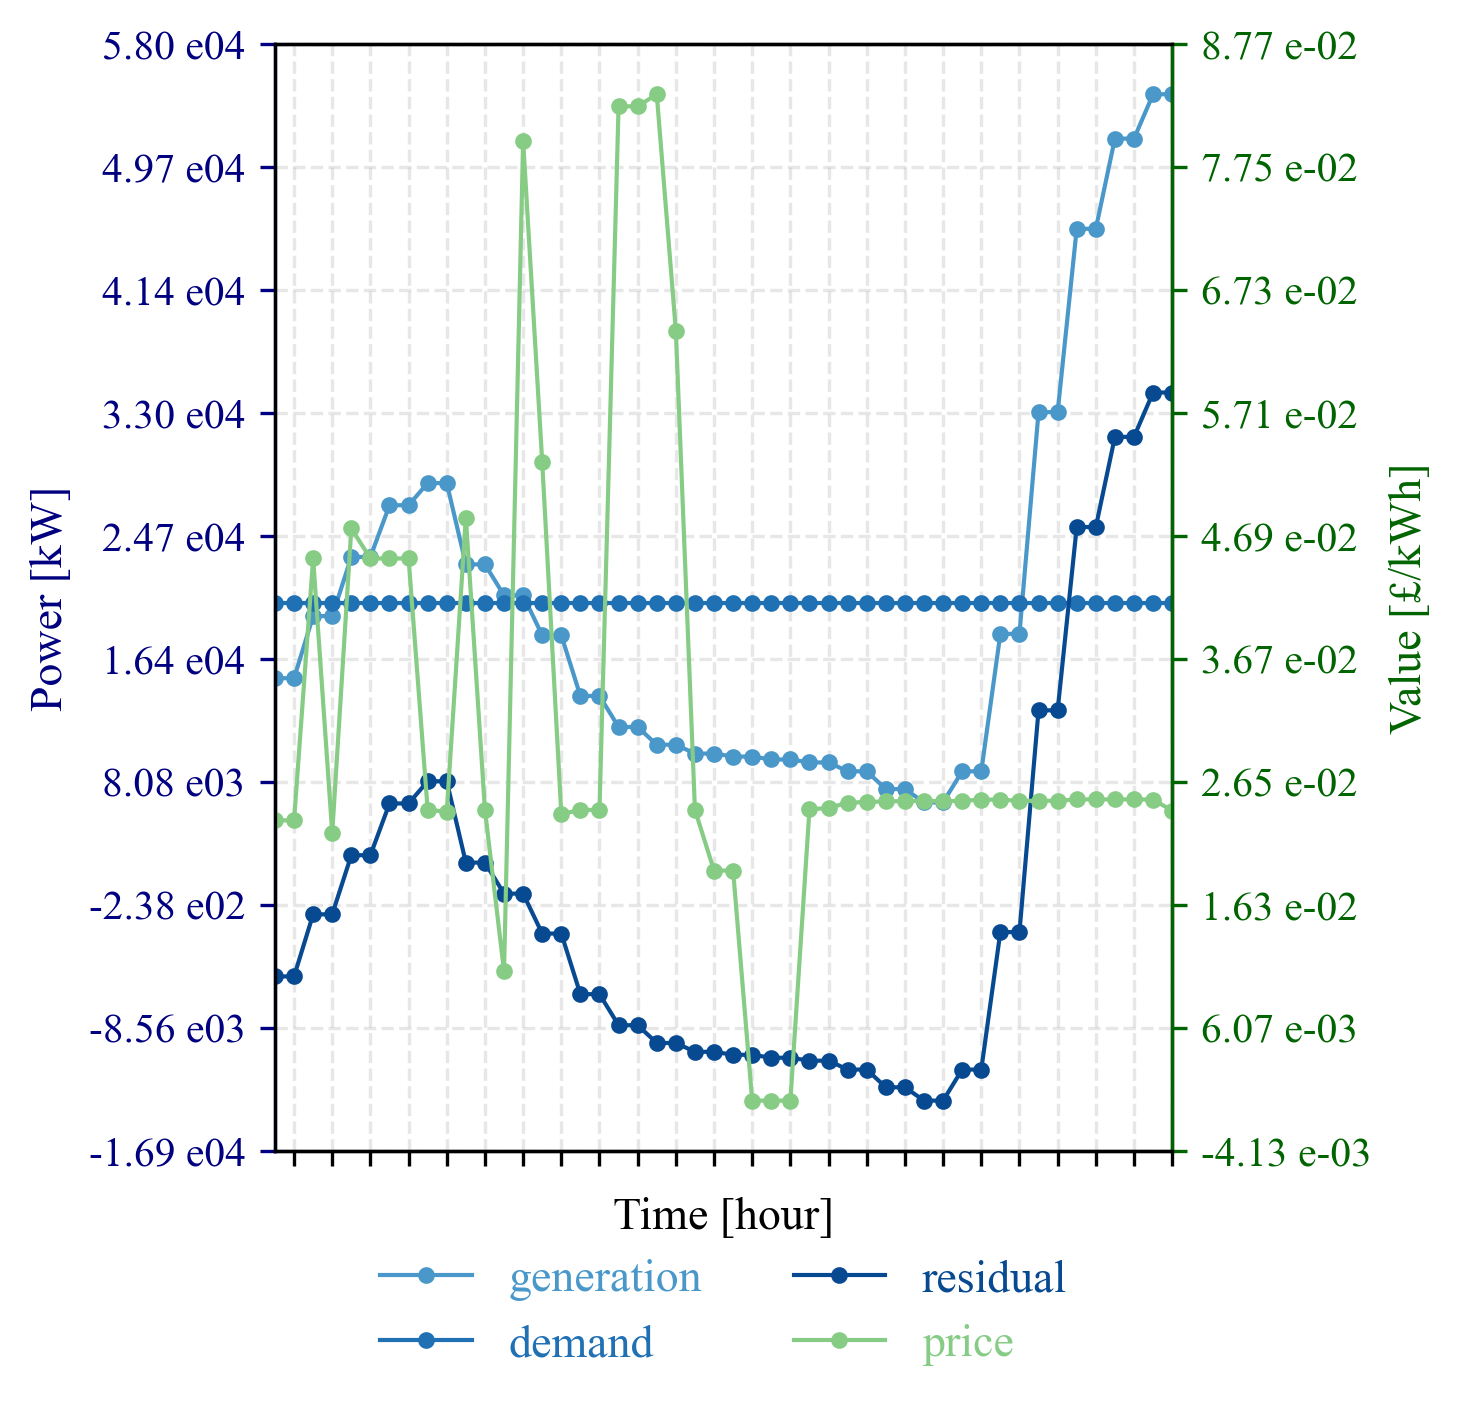

In [118]:
Figure_title = 'Residual Generation'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['generation', 'demand', 'residual'],
    left_label='Power',
    left_units='[kW]',
    series_right = ['price'],
    right_label = 'Value',
    right_units = '[£/kWh]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

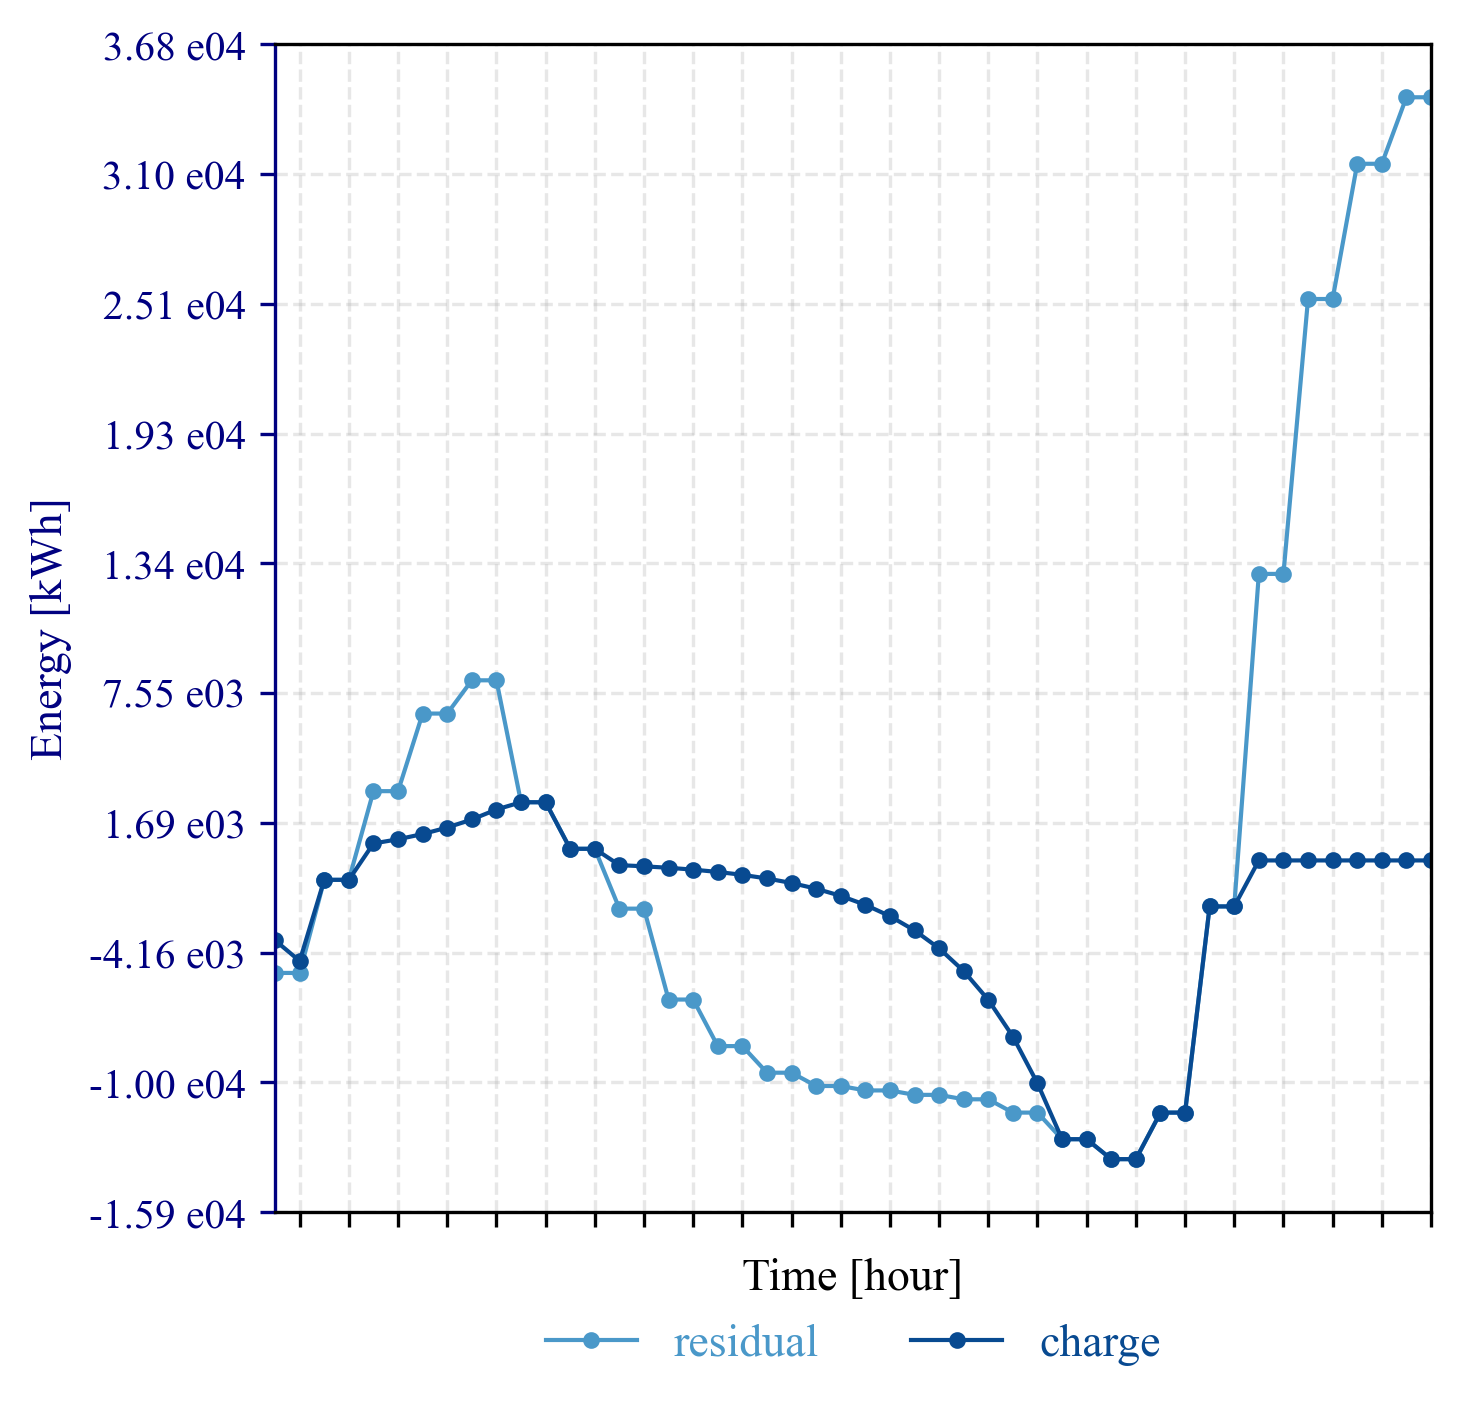

In [119]:
Figure_title = 'Operational Restriction of QSS Approximation - Energy Flow'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['residual', 'charge'],
    left_label='Energy',
    left_units='[kWh]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

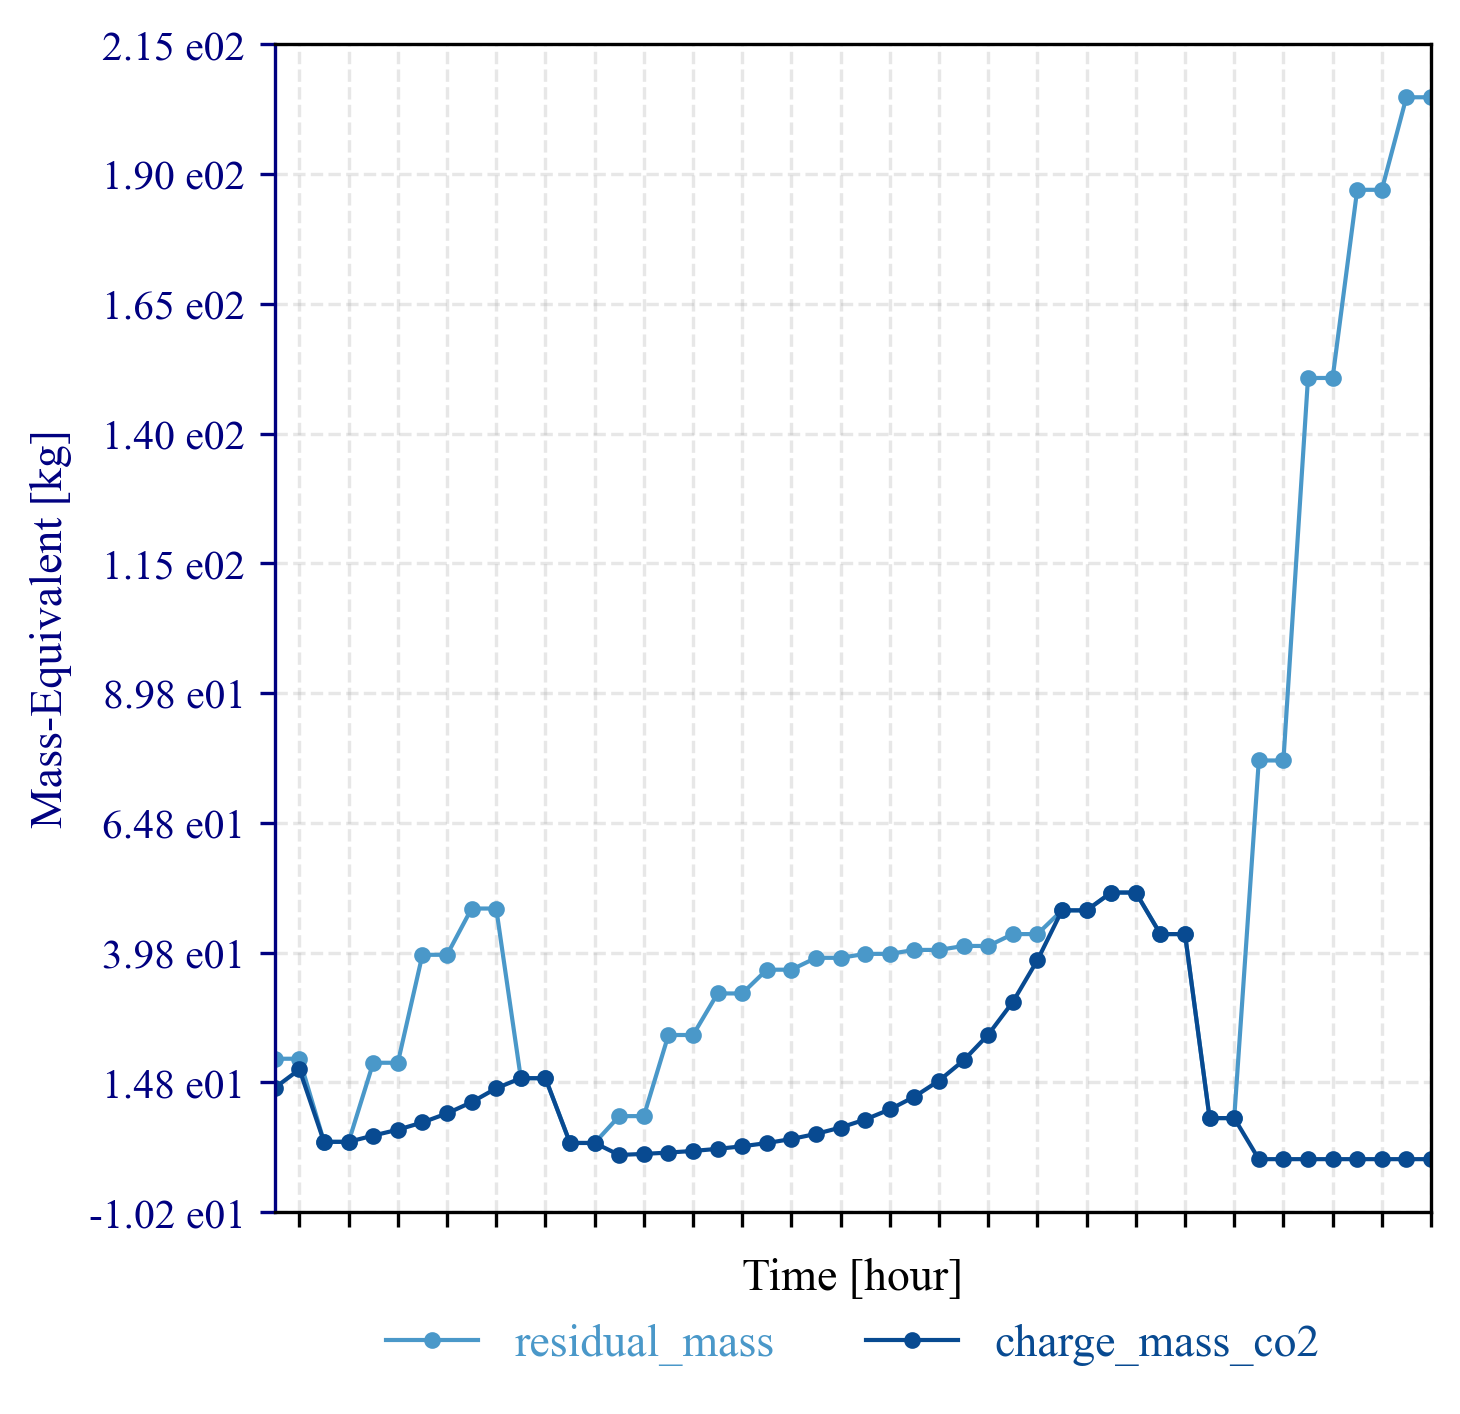

In [120]:
Figure_title = 'Operational Restriction of QSS Approximation - Material Flow'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['residual_mass','charge_mass_co2'],
    left_label='Mass-Equivalent',
    left_units='[kg]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

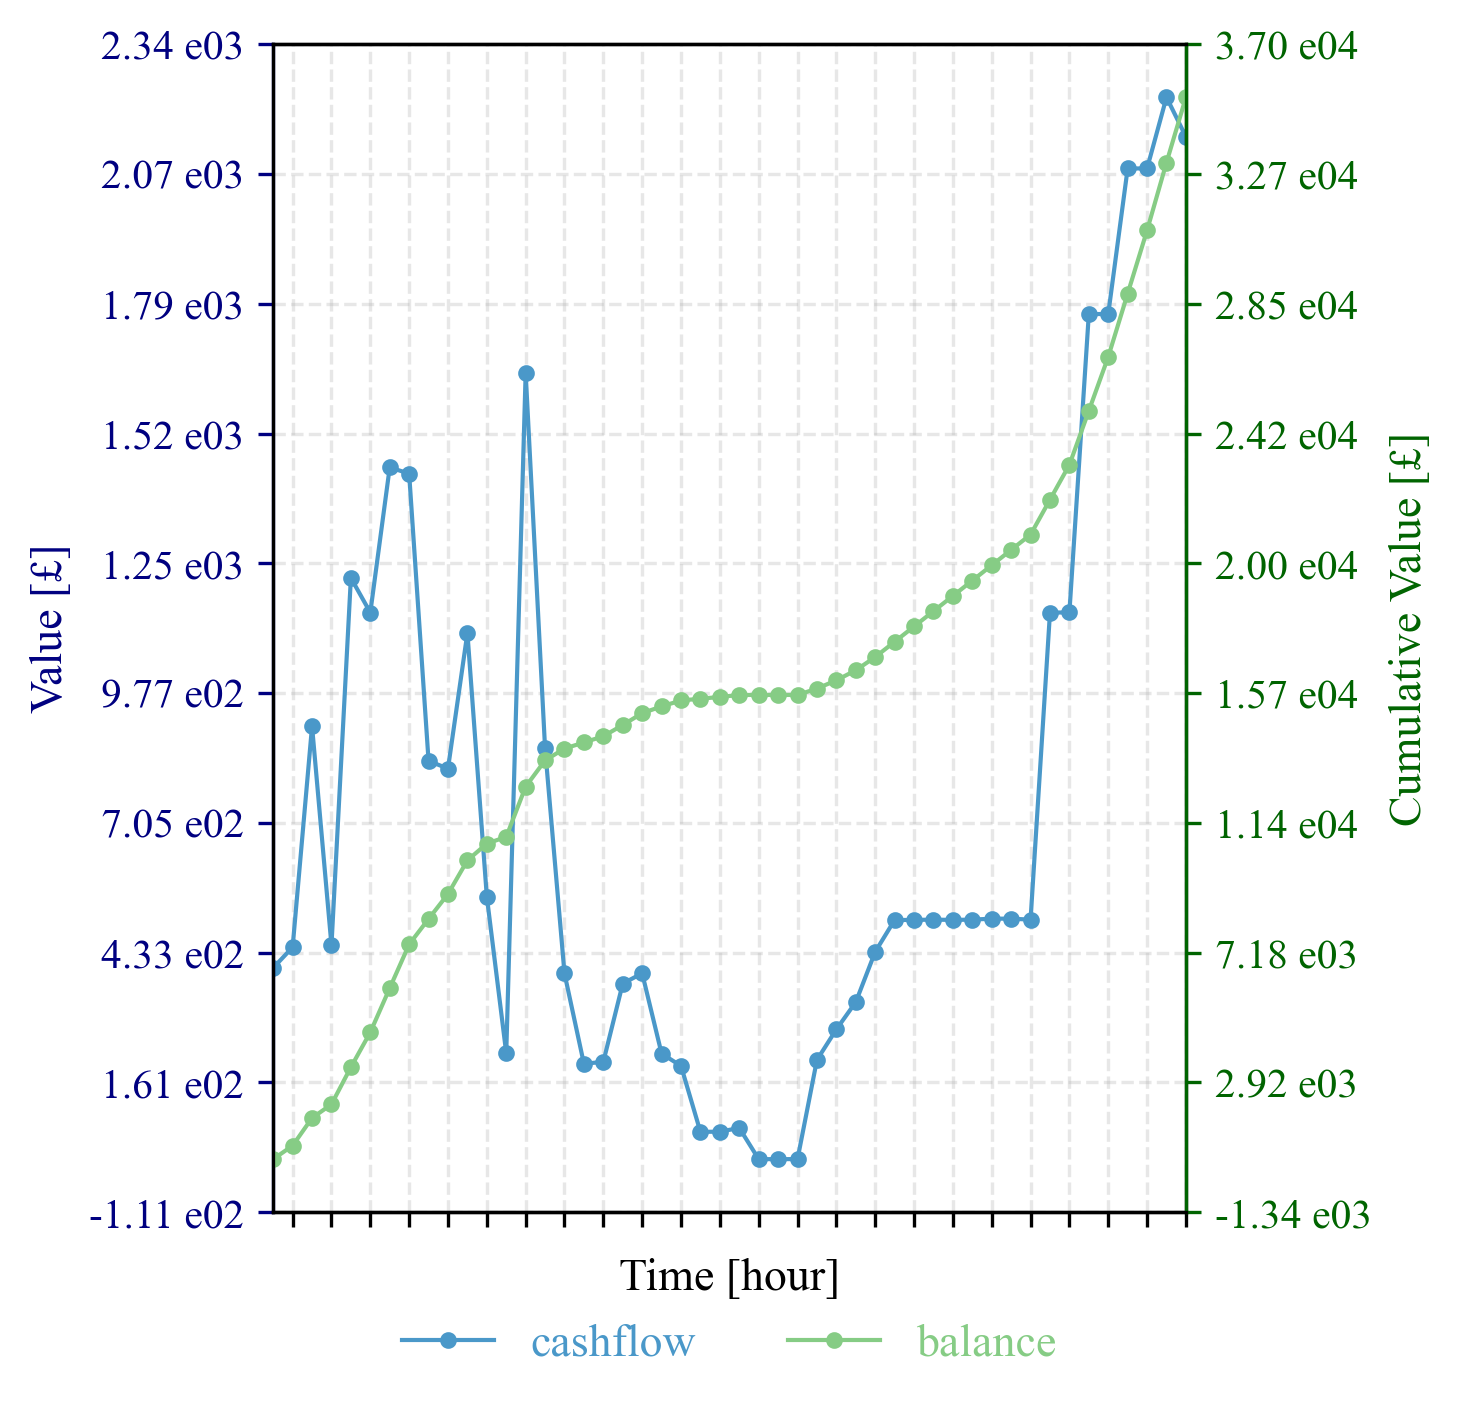

In [121]:
Figure_title = f'{Cycle} Balance Sheet'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['cashflow'],
    left_label='Value',
    left_units='[£]',
    series_right = ['balance'],
    right_label = 'Cumulative Value',
    right_units = '[£]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

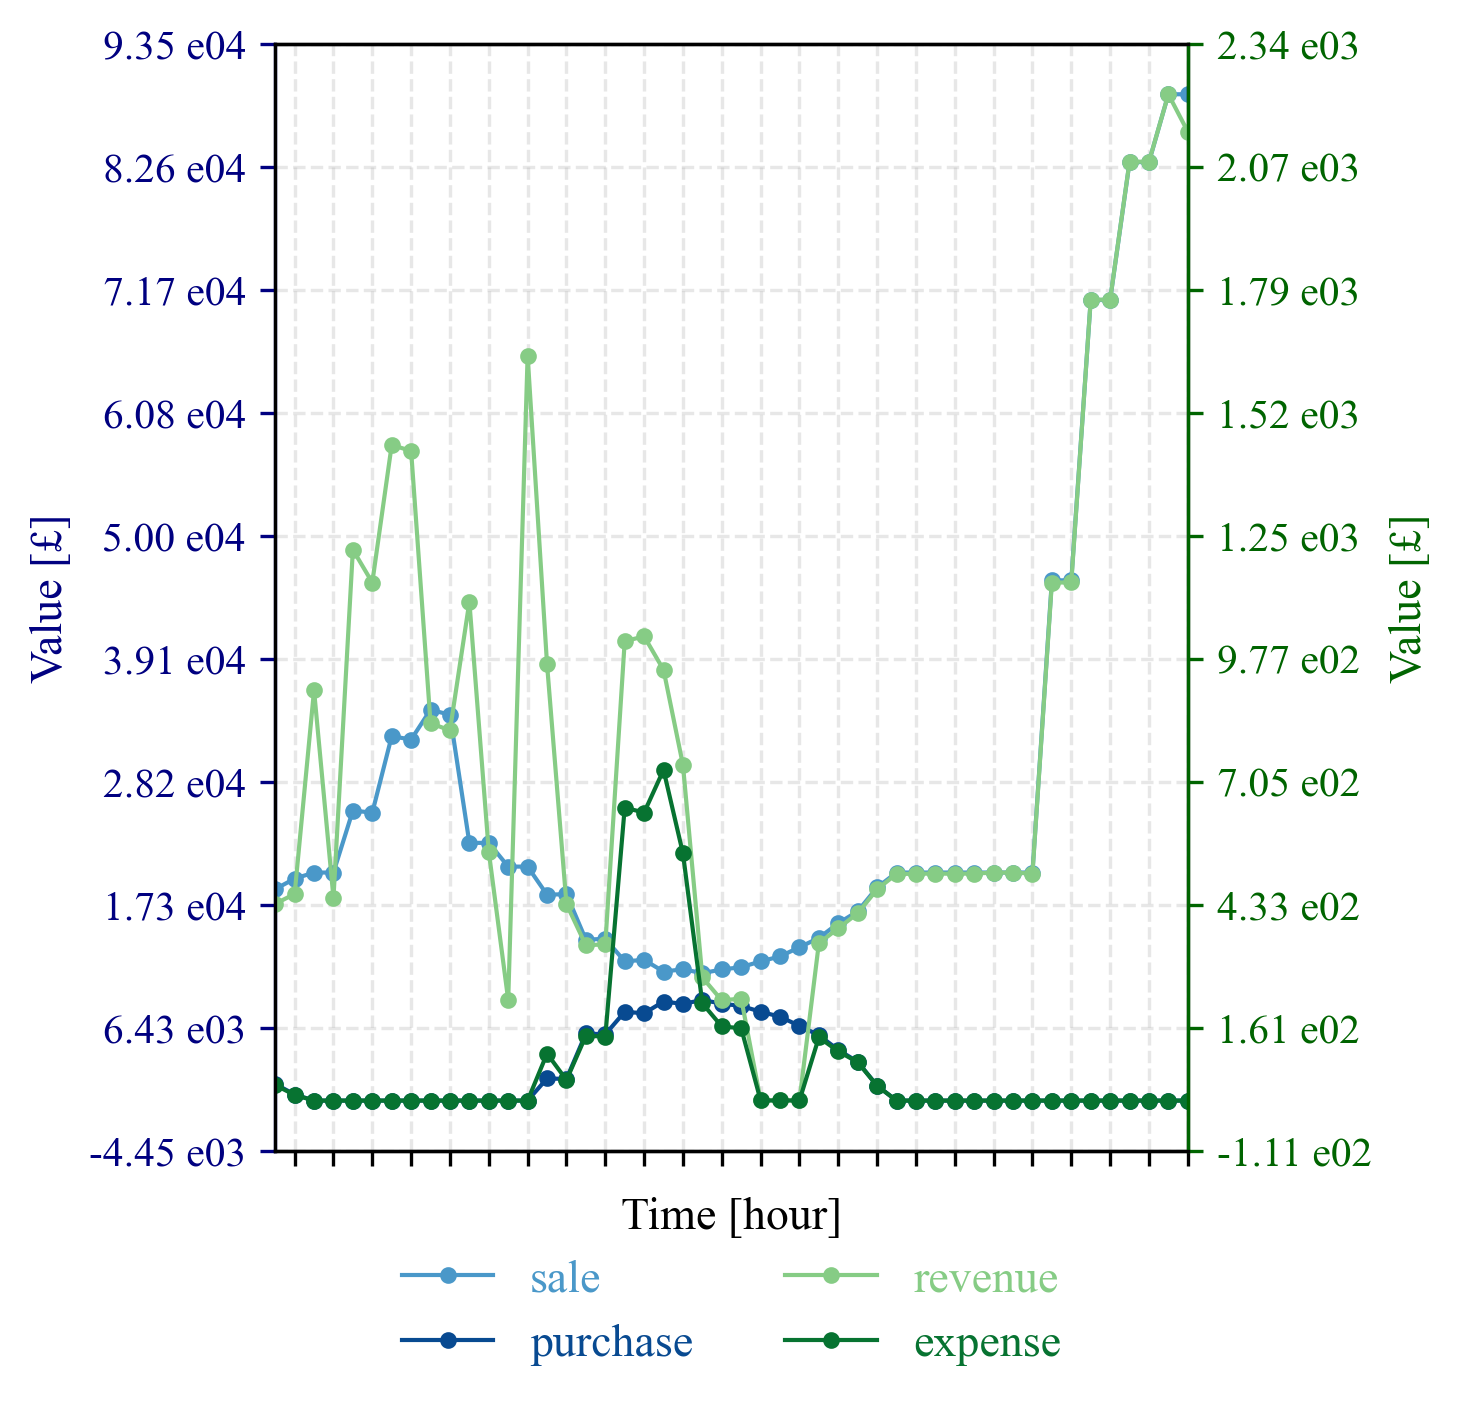

In [122]:
Figure_title = f'{Cycle} Power Trade'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['sale','purchase'],
    left_label='Value',
    left_units='[£]',
    series_right = ['revenue','expense'],
    right_label = 'Value',
    right_units = '[£]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

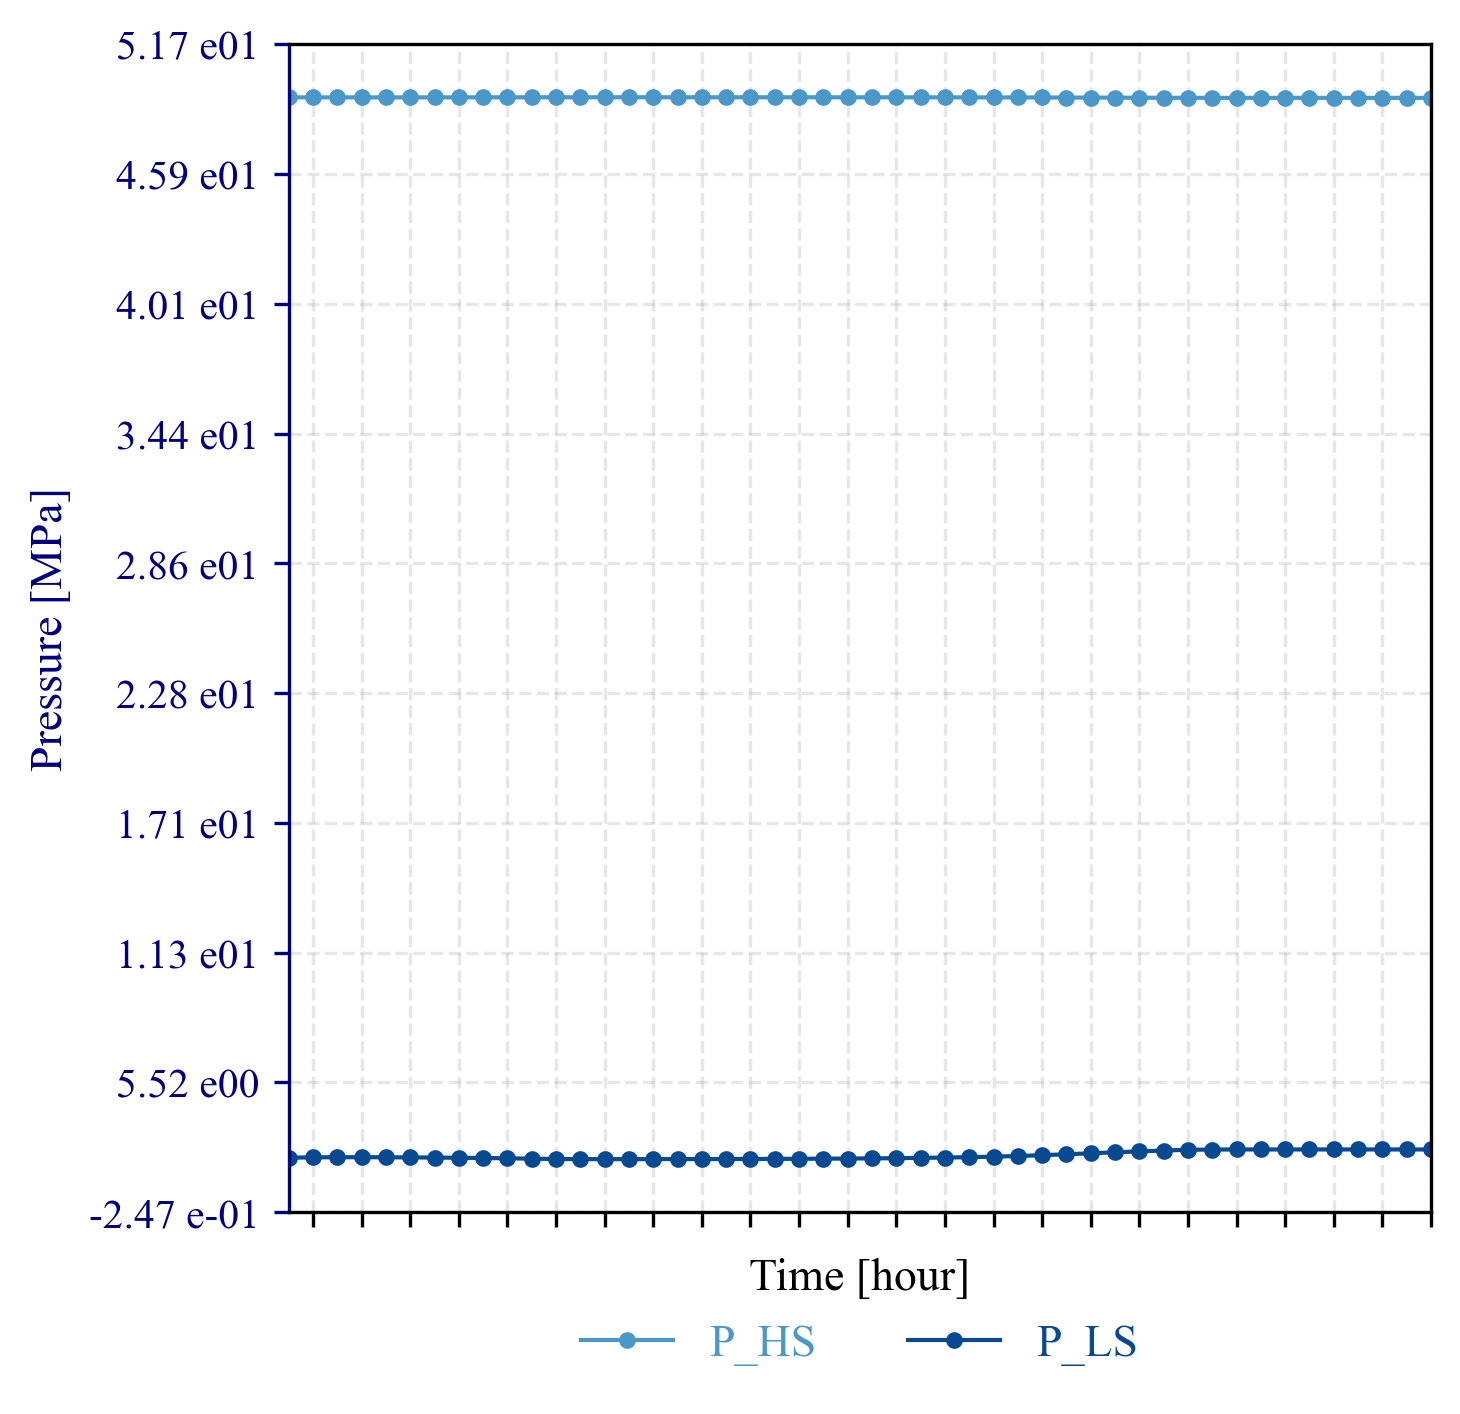

In [123]:
Figure_title = 'Storage Pressures'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['P_HS', 'P_LS'],
    left_label= 'Pressure',
    left_units='[MPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

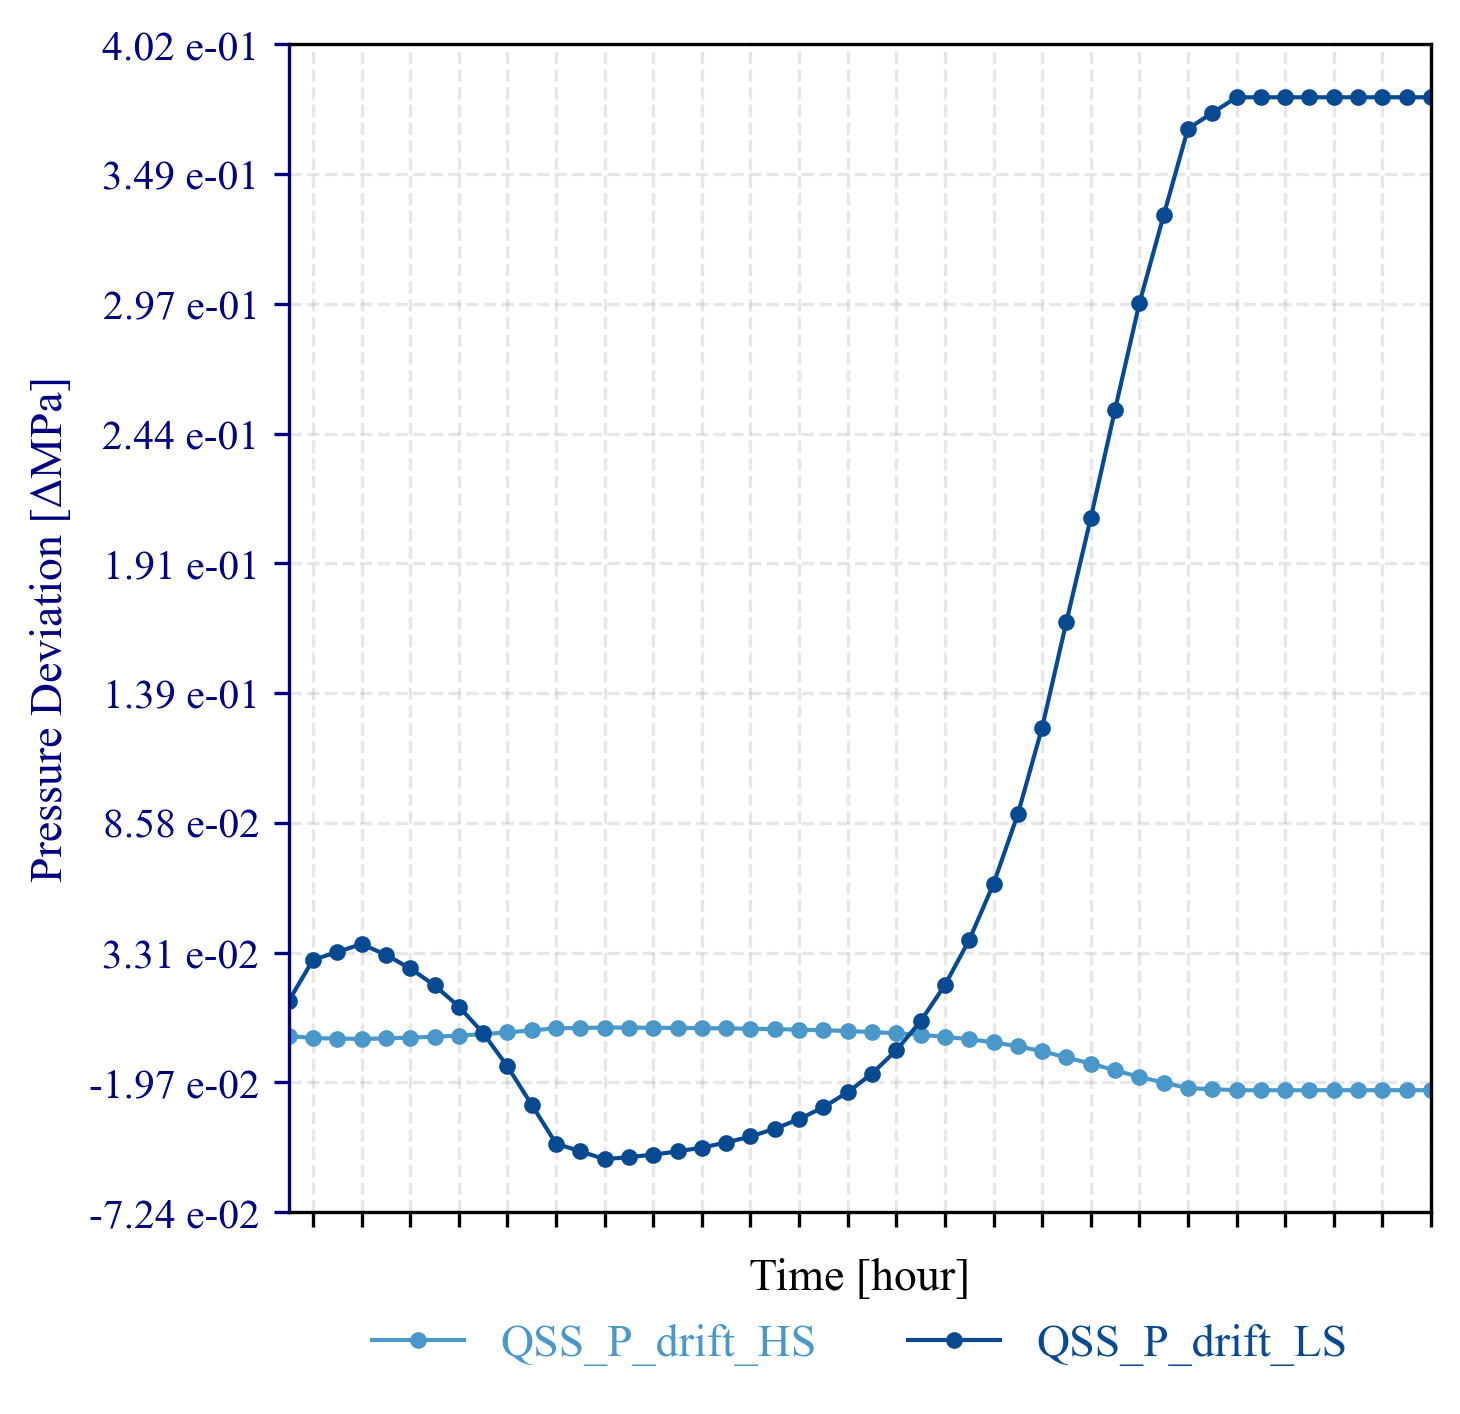

In [124]:
Figure_title = 'QSS Baseline Pressure Deviations'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['QSS_P_drift_HS','QSS_P_drift_LS'],
    left_label= 'Pressure Deviation',
    left_units='[ΔMPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

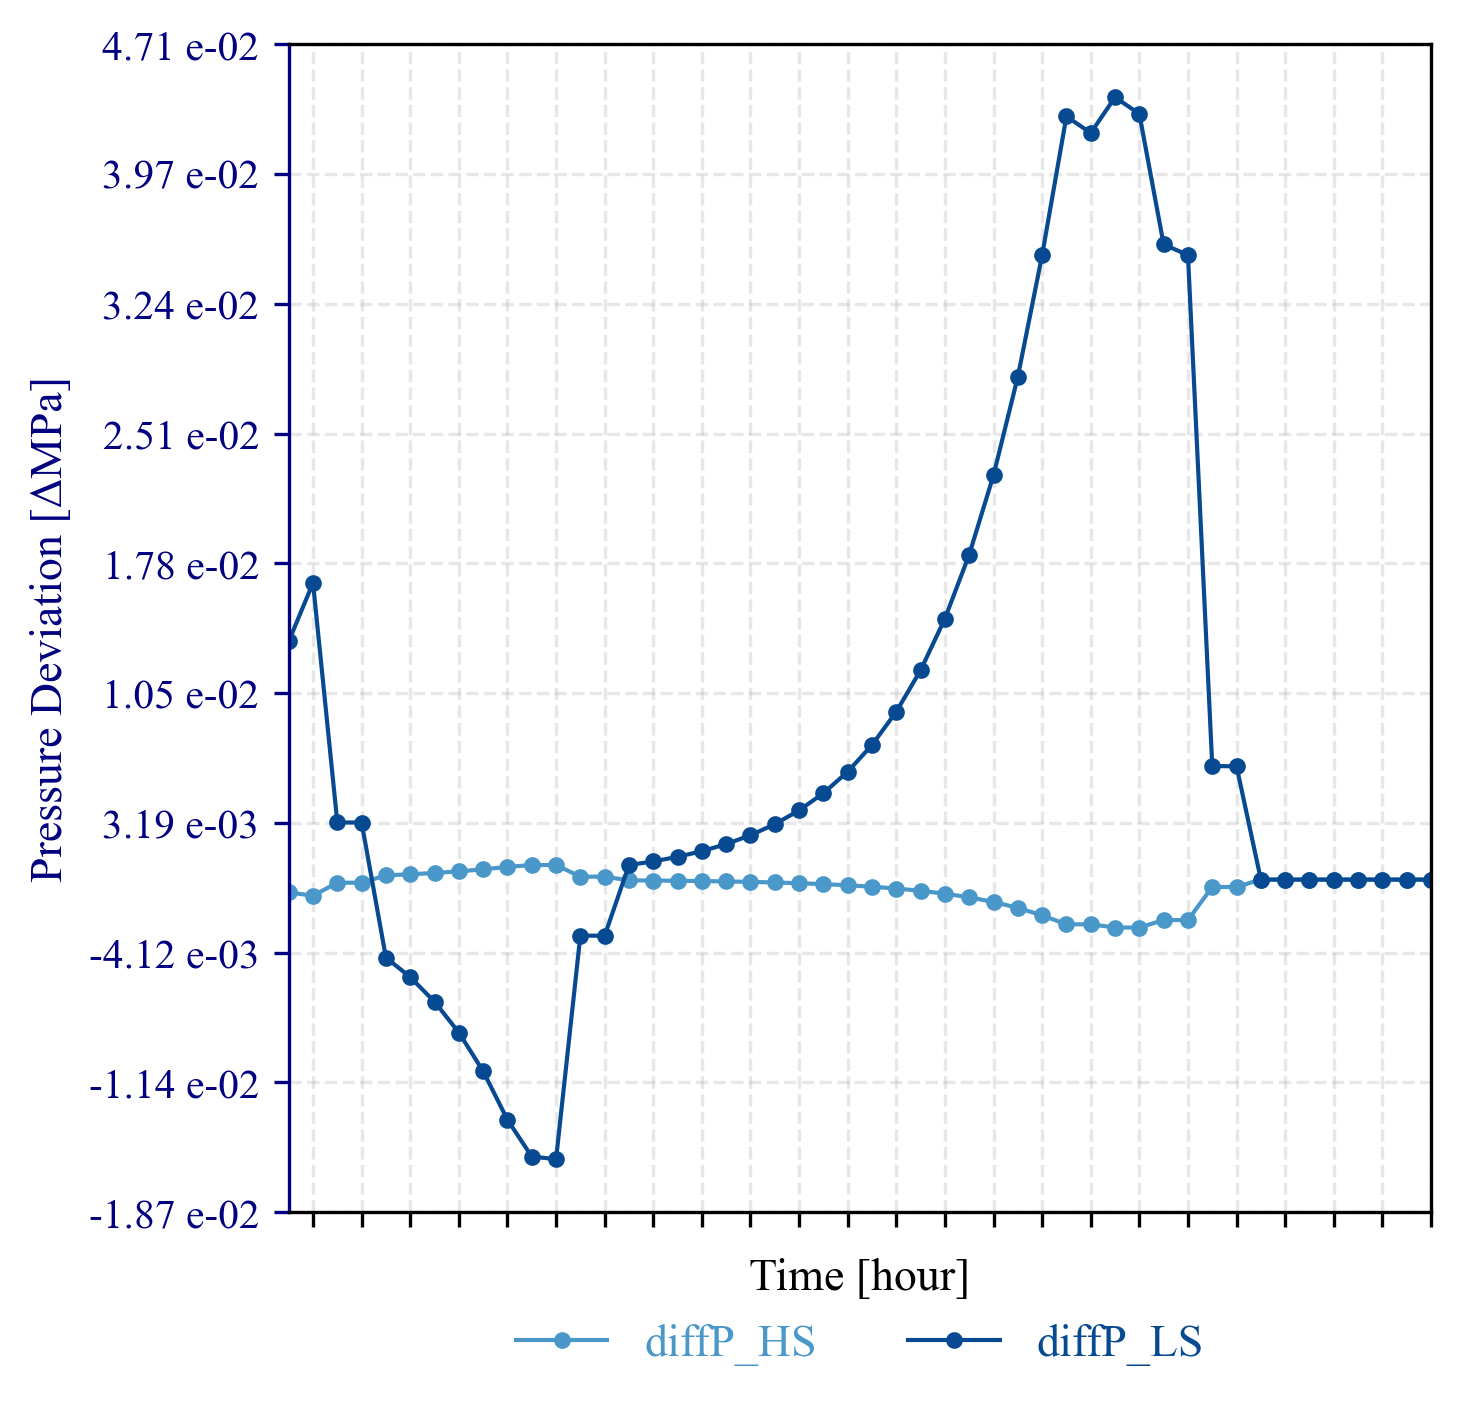

In [125]:
Figure_title = 'Consecutive Pressure Deviations'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['diffP_HS','diffP_LS'],
    left_label= 'Pressure Deviation',
    left_units='[ΔMPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

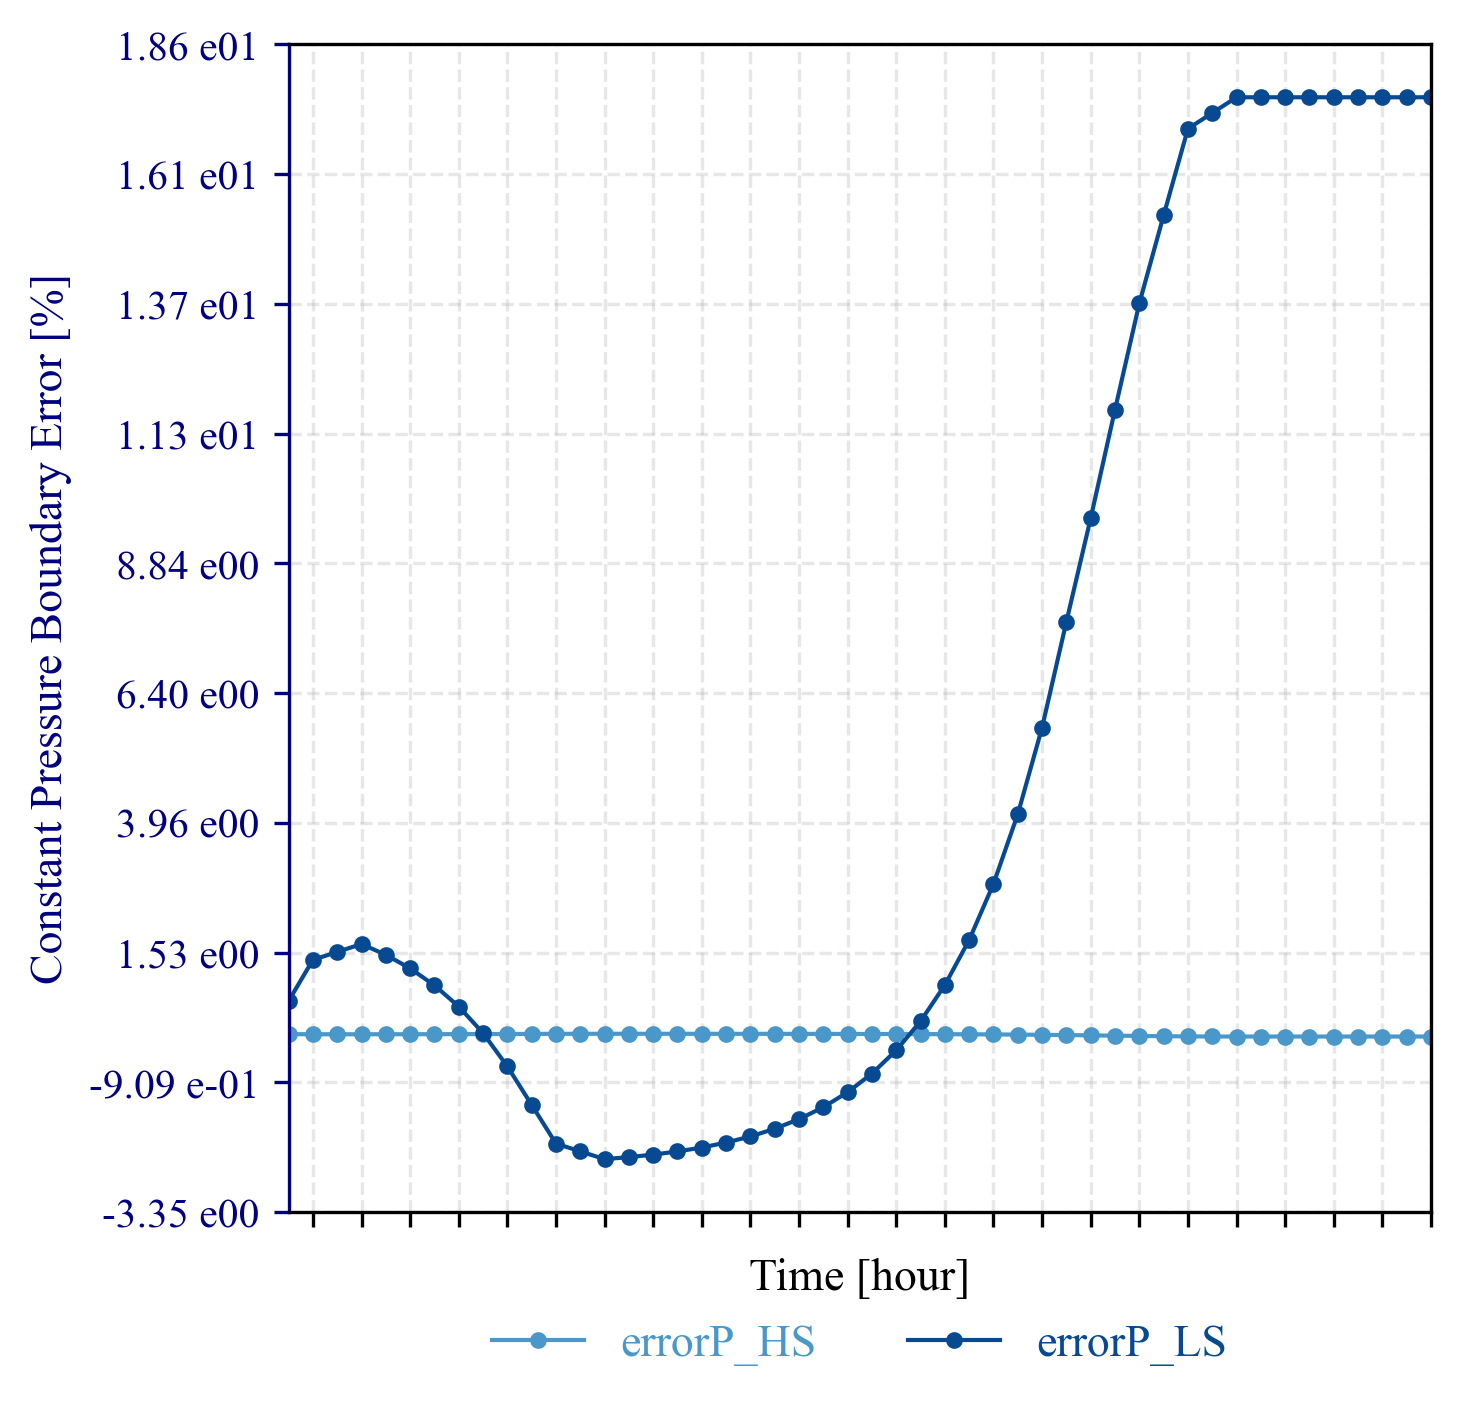

In [126]:
Figure_title = 'QSS Approximation Compliance'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['errorP_HS','errorP_LS'],
    left_label= 'Constant Pressure Boundary Error',
    left_units='[%]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

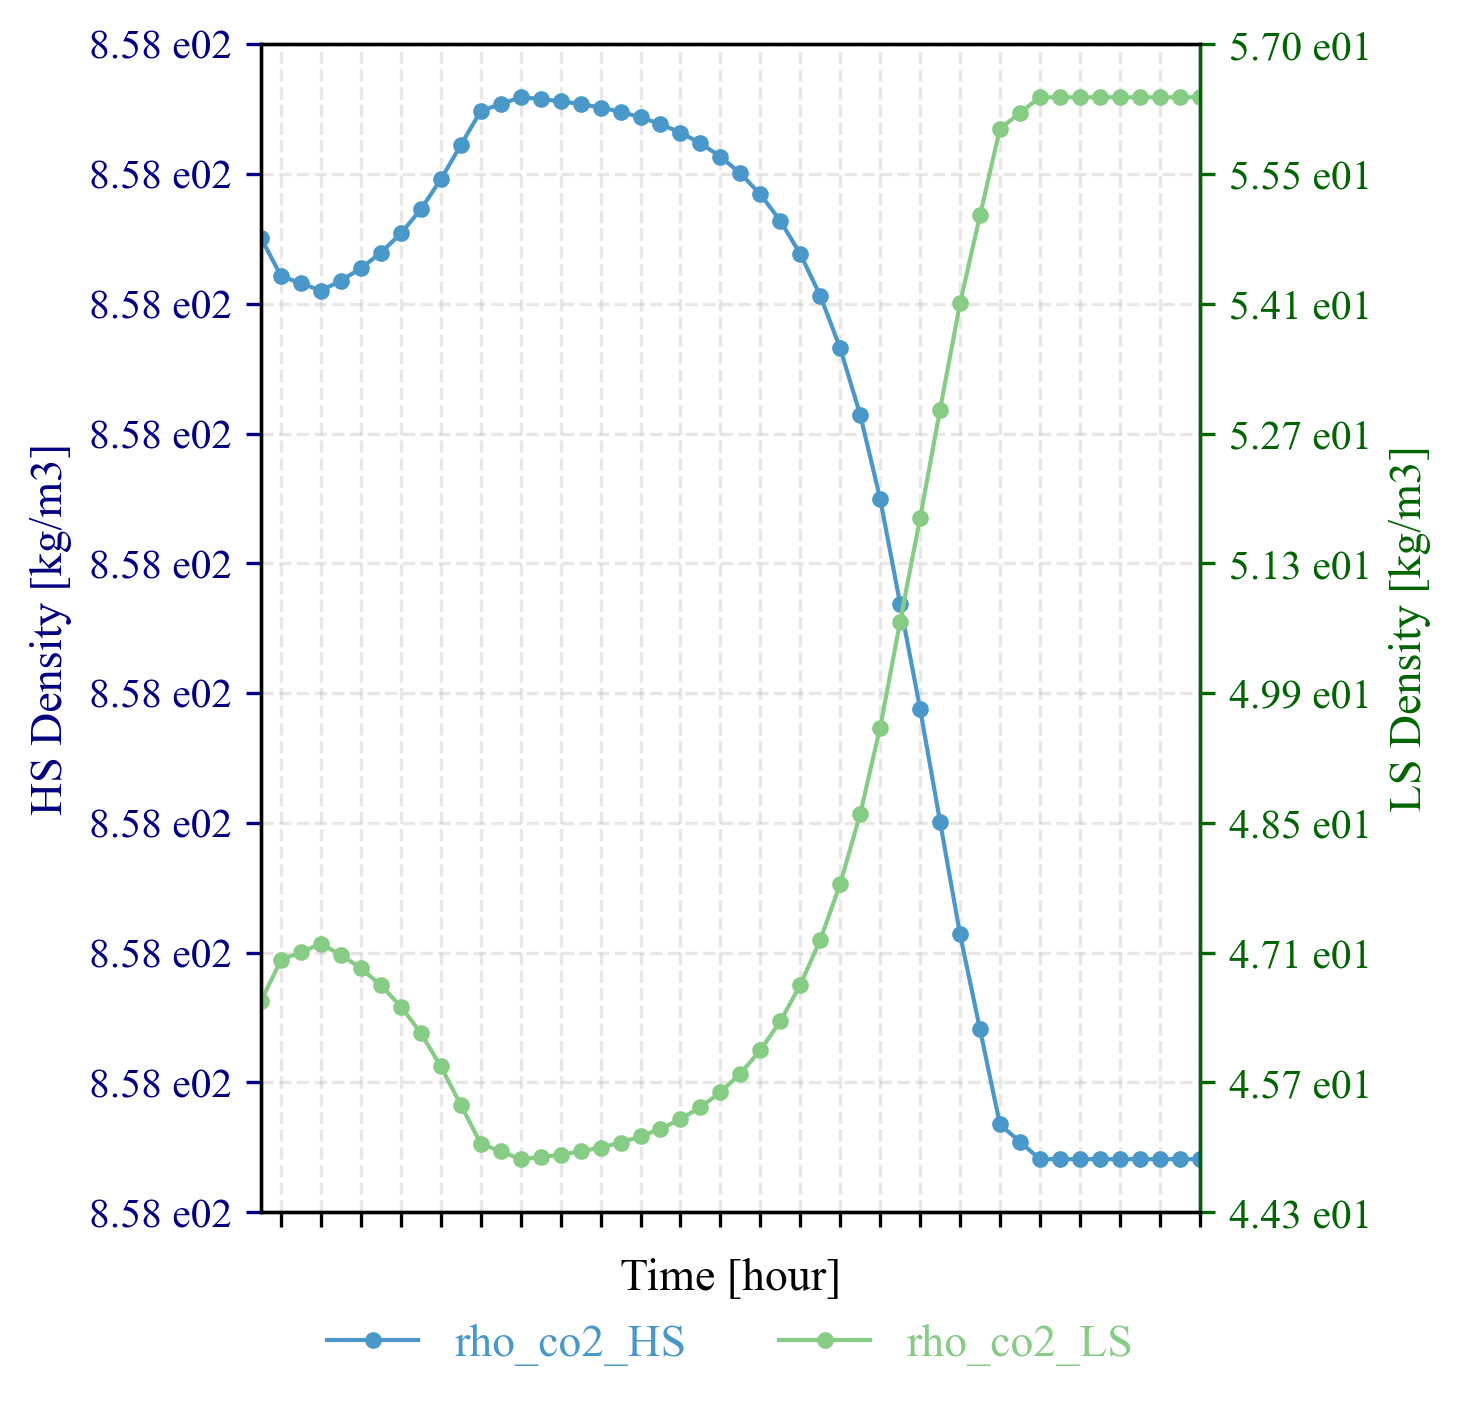

In [127]:
Figure_title = f'{Working_fluid} Density Evolution'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['rho_co2_HS'],
    left_label= 'HS Density',
    left_units='[kg/m3]',
    series_right = ['rho_co2_LS'],
    right_label= 'LS Density',             
    right_units='[kg/m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

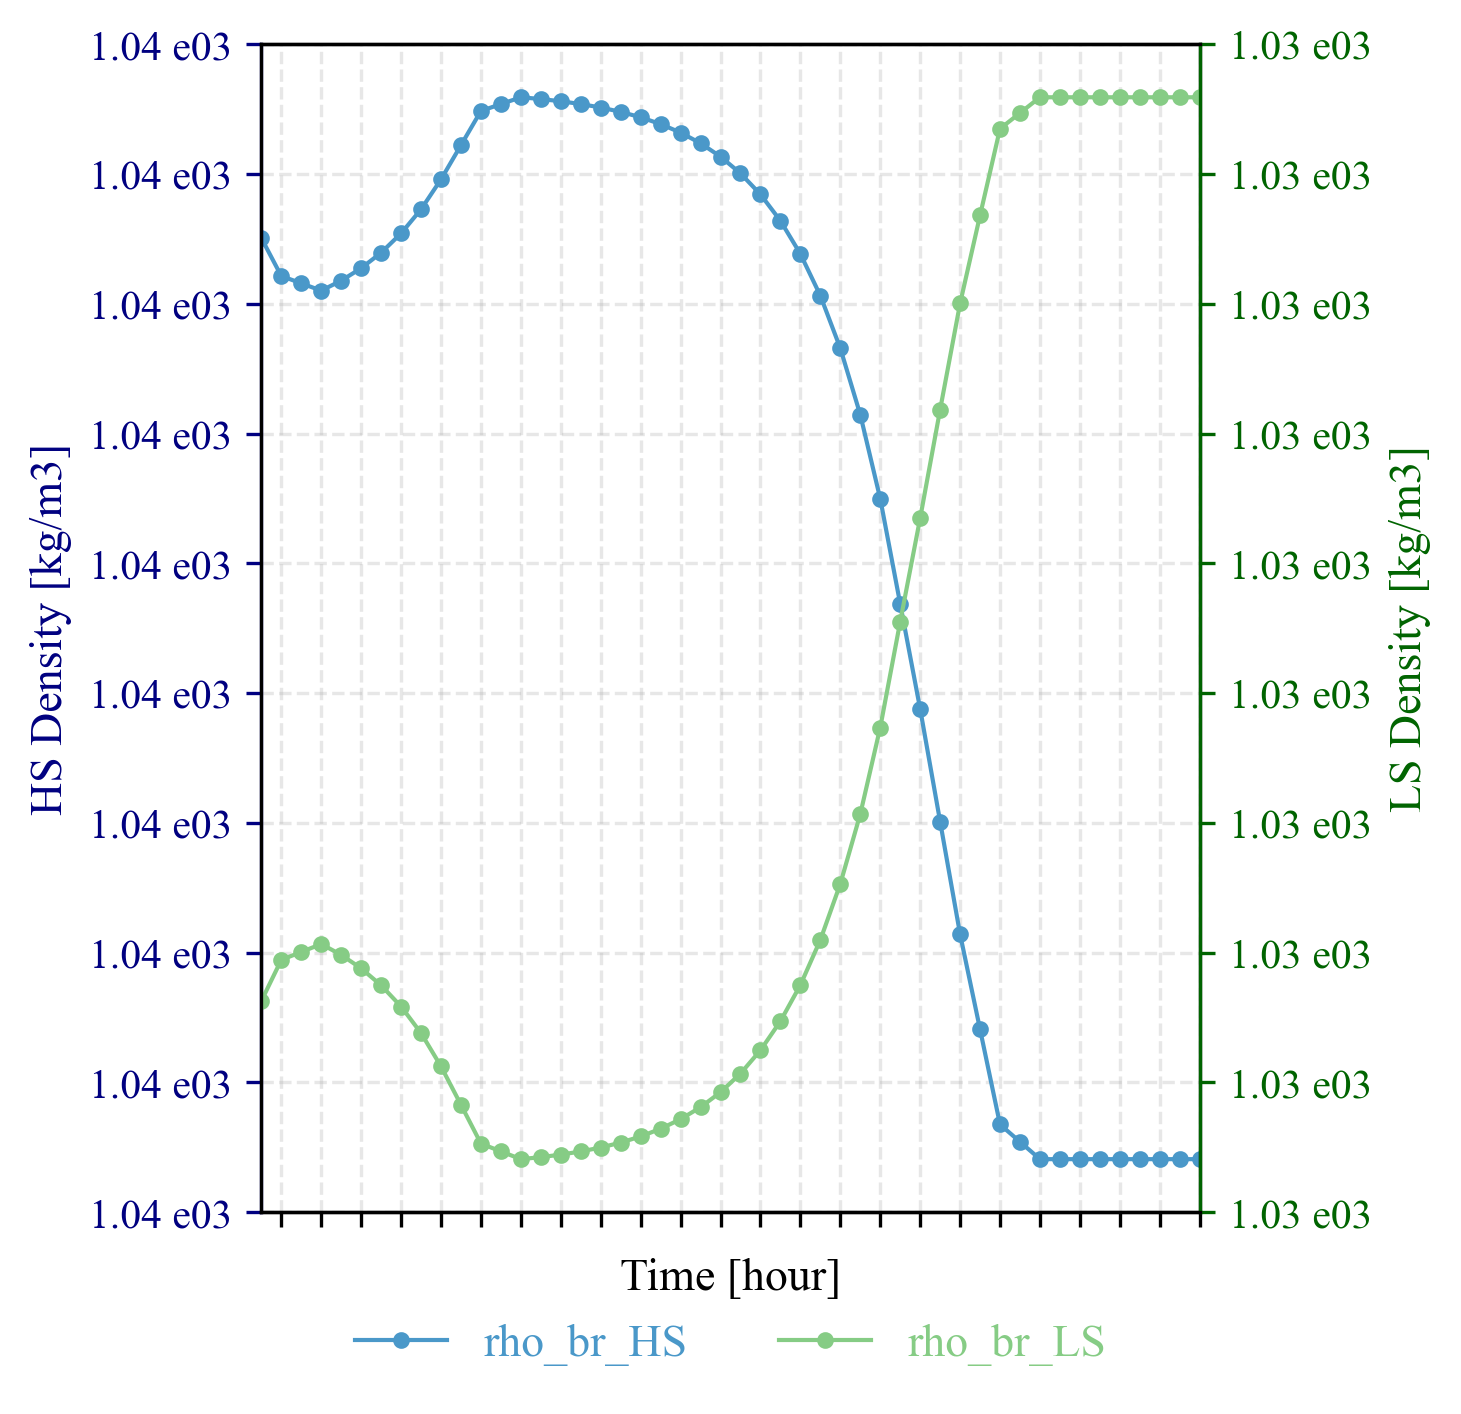

In [128]:
Figure_title = 'Brine Density Evolution'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['rho_br_HS'],
    left_label= 'HS Density',
    left_units='[kg/m3]',
    series_right = ['rho_br_LS'],
    right_label= 'LS Density',             
    right_units='[kg/m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

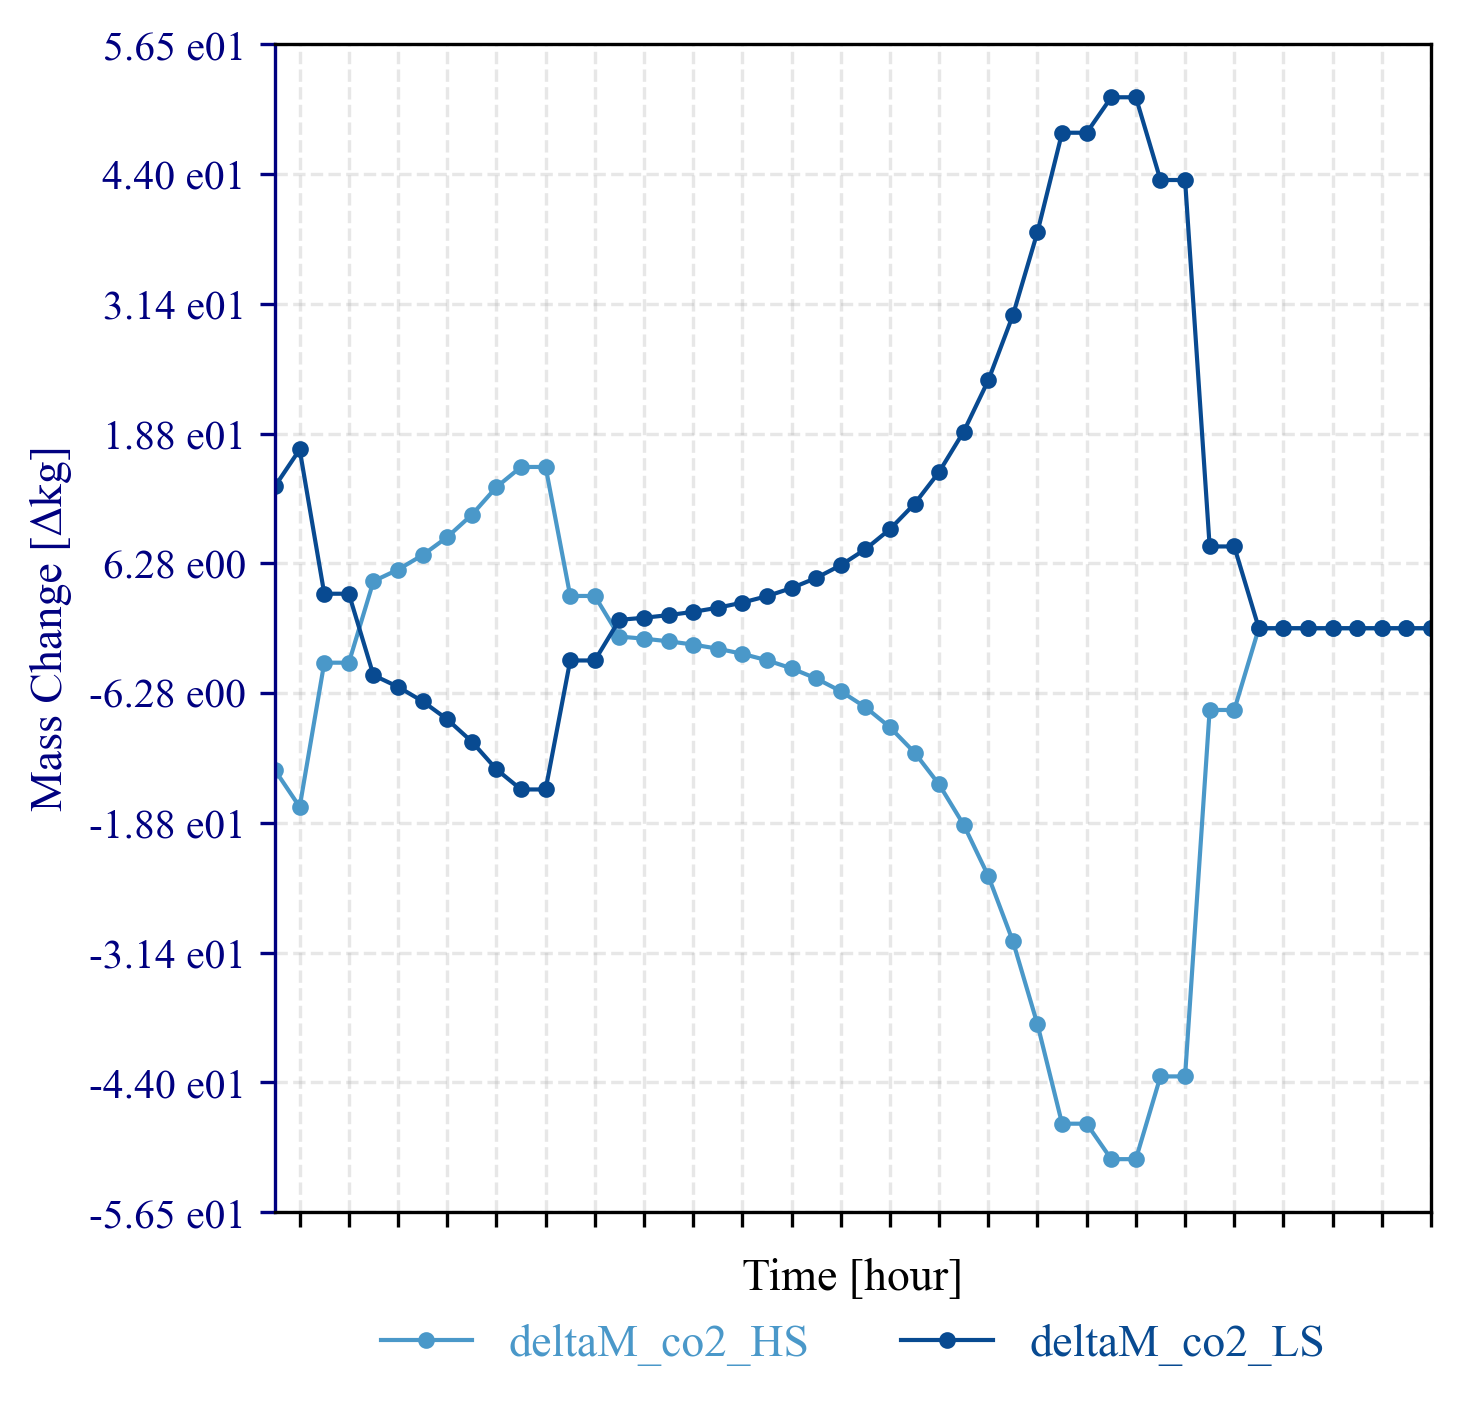

In [129]:
Figure_title = f'{Working_fluid} Storage Exchange'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['deltaM_co2_HS', 'deltaM_co2_LS'],
    left_label= 'Mass Change',
    left_units='[Δkg]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

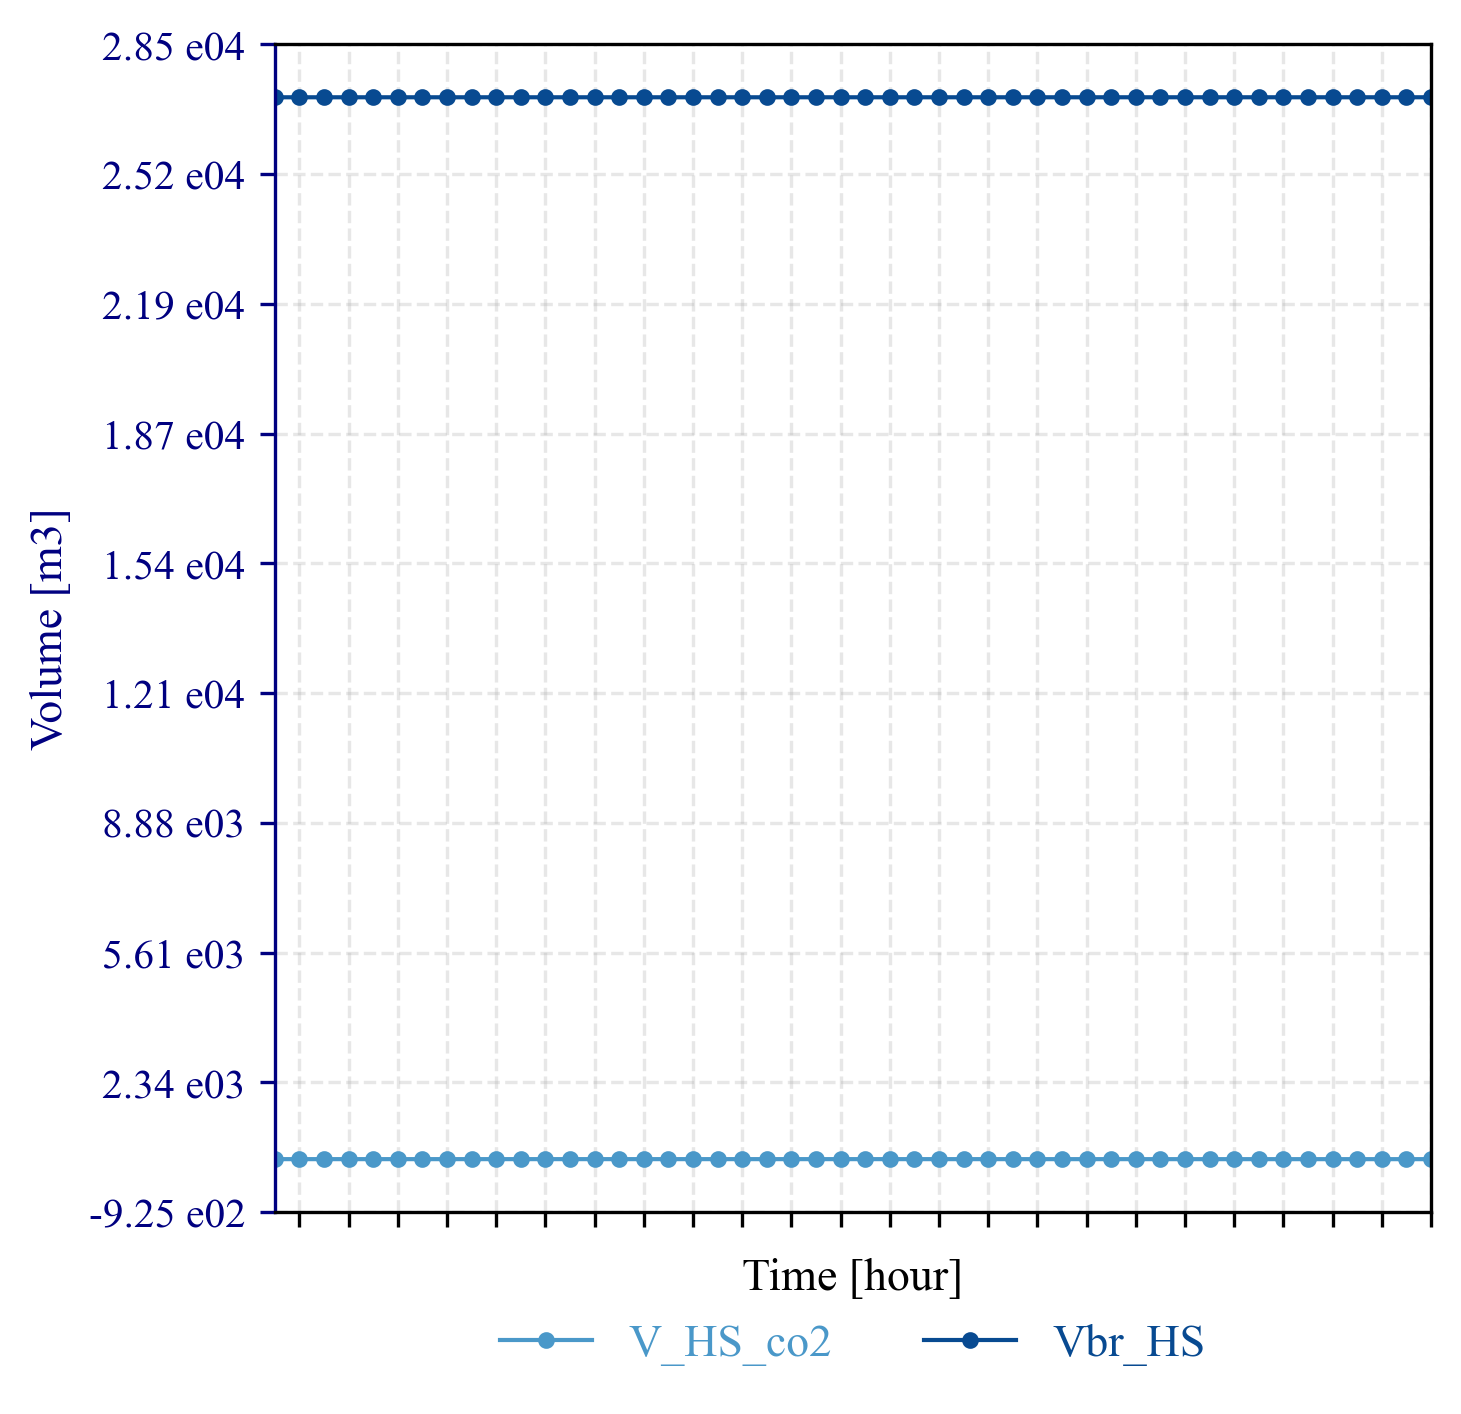

In [130]:
Figure_title = 'HS Volumetric Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['V_HS_co2', 'Vbr_HS'],
    left_label= 'Volume',
    left_units='[m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

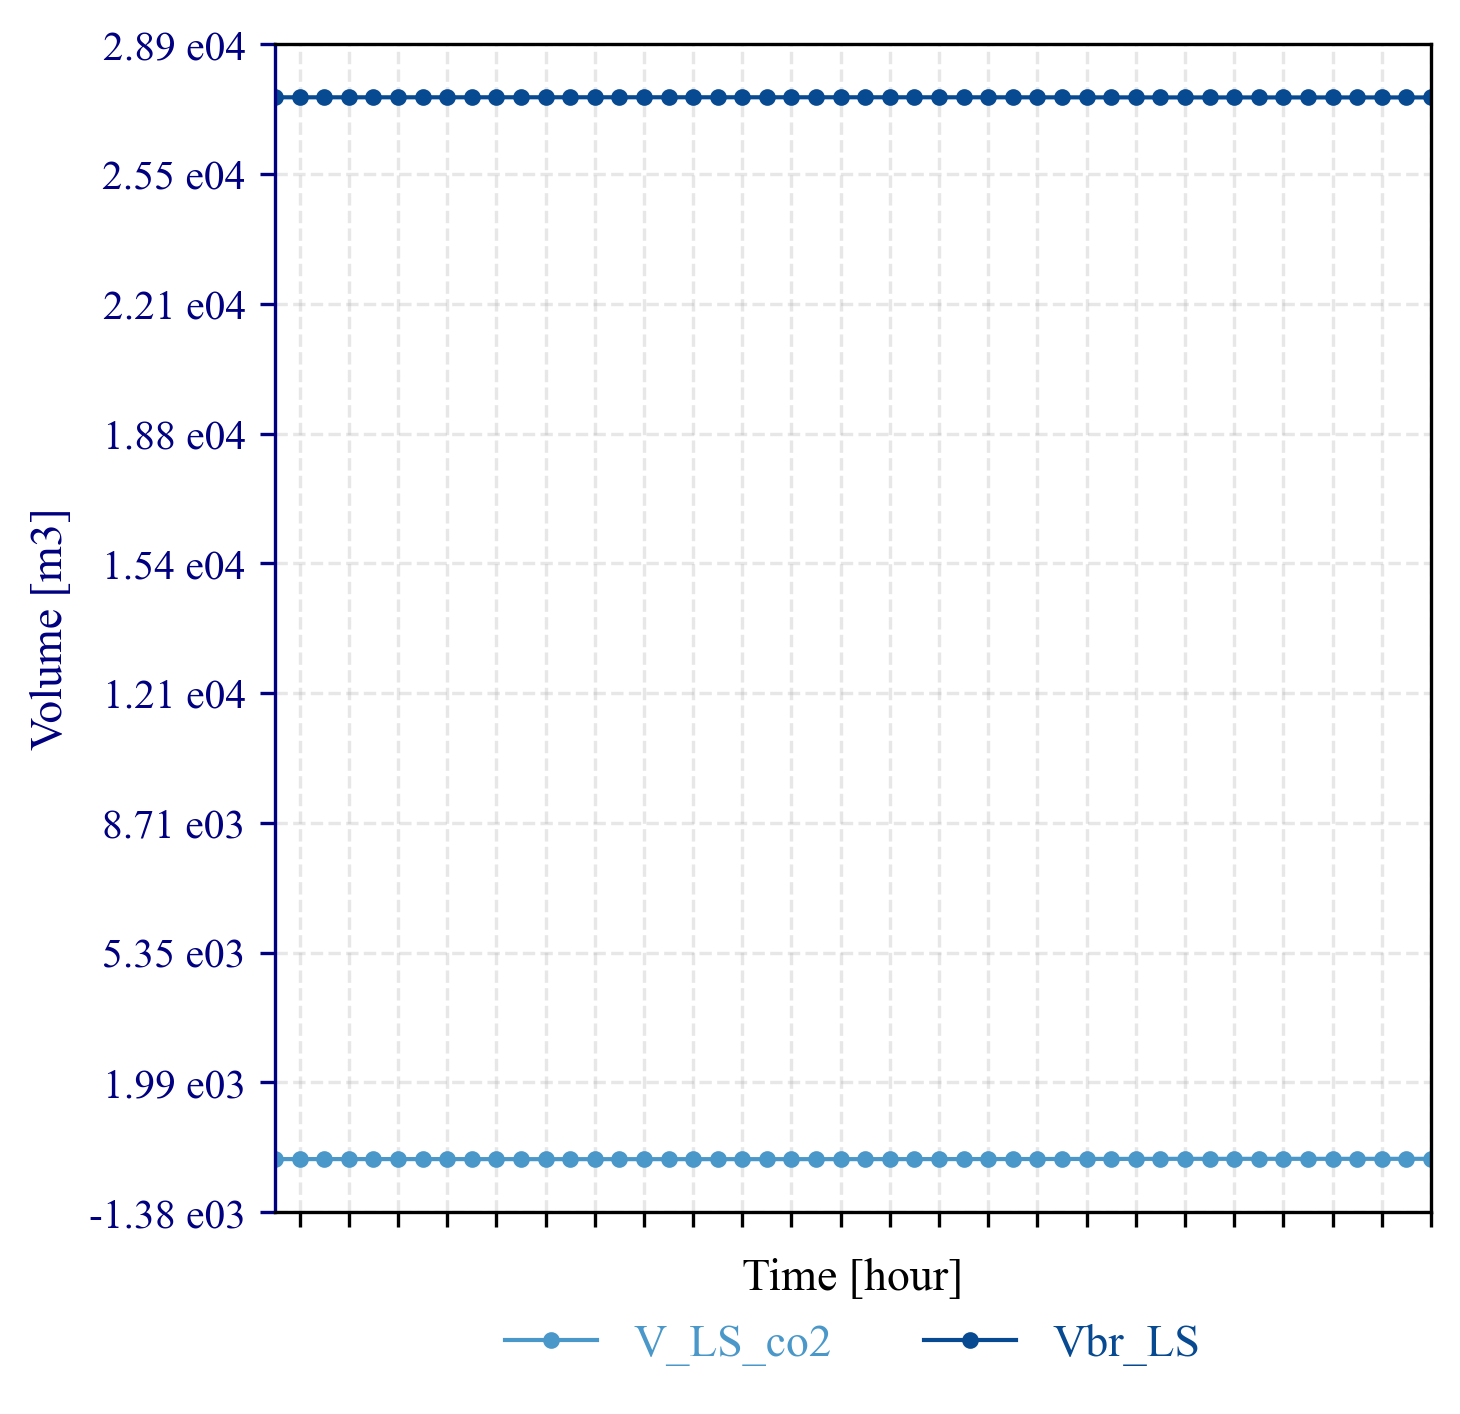

In [131]:
Figure_title = 'LS Volumetric Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['V_LS_co2', 'Vbr_LS'],
    left_label= 'Volume',
    left_units='[m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

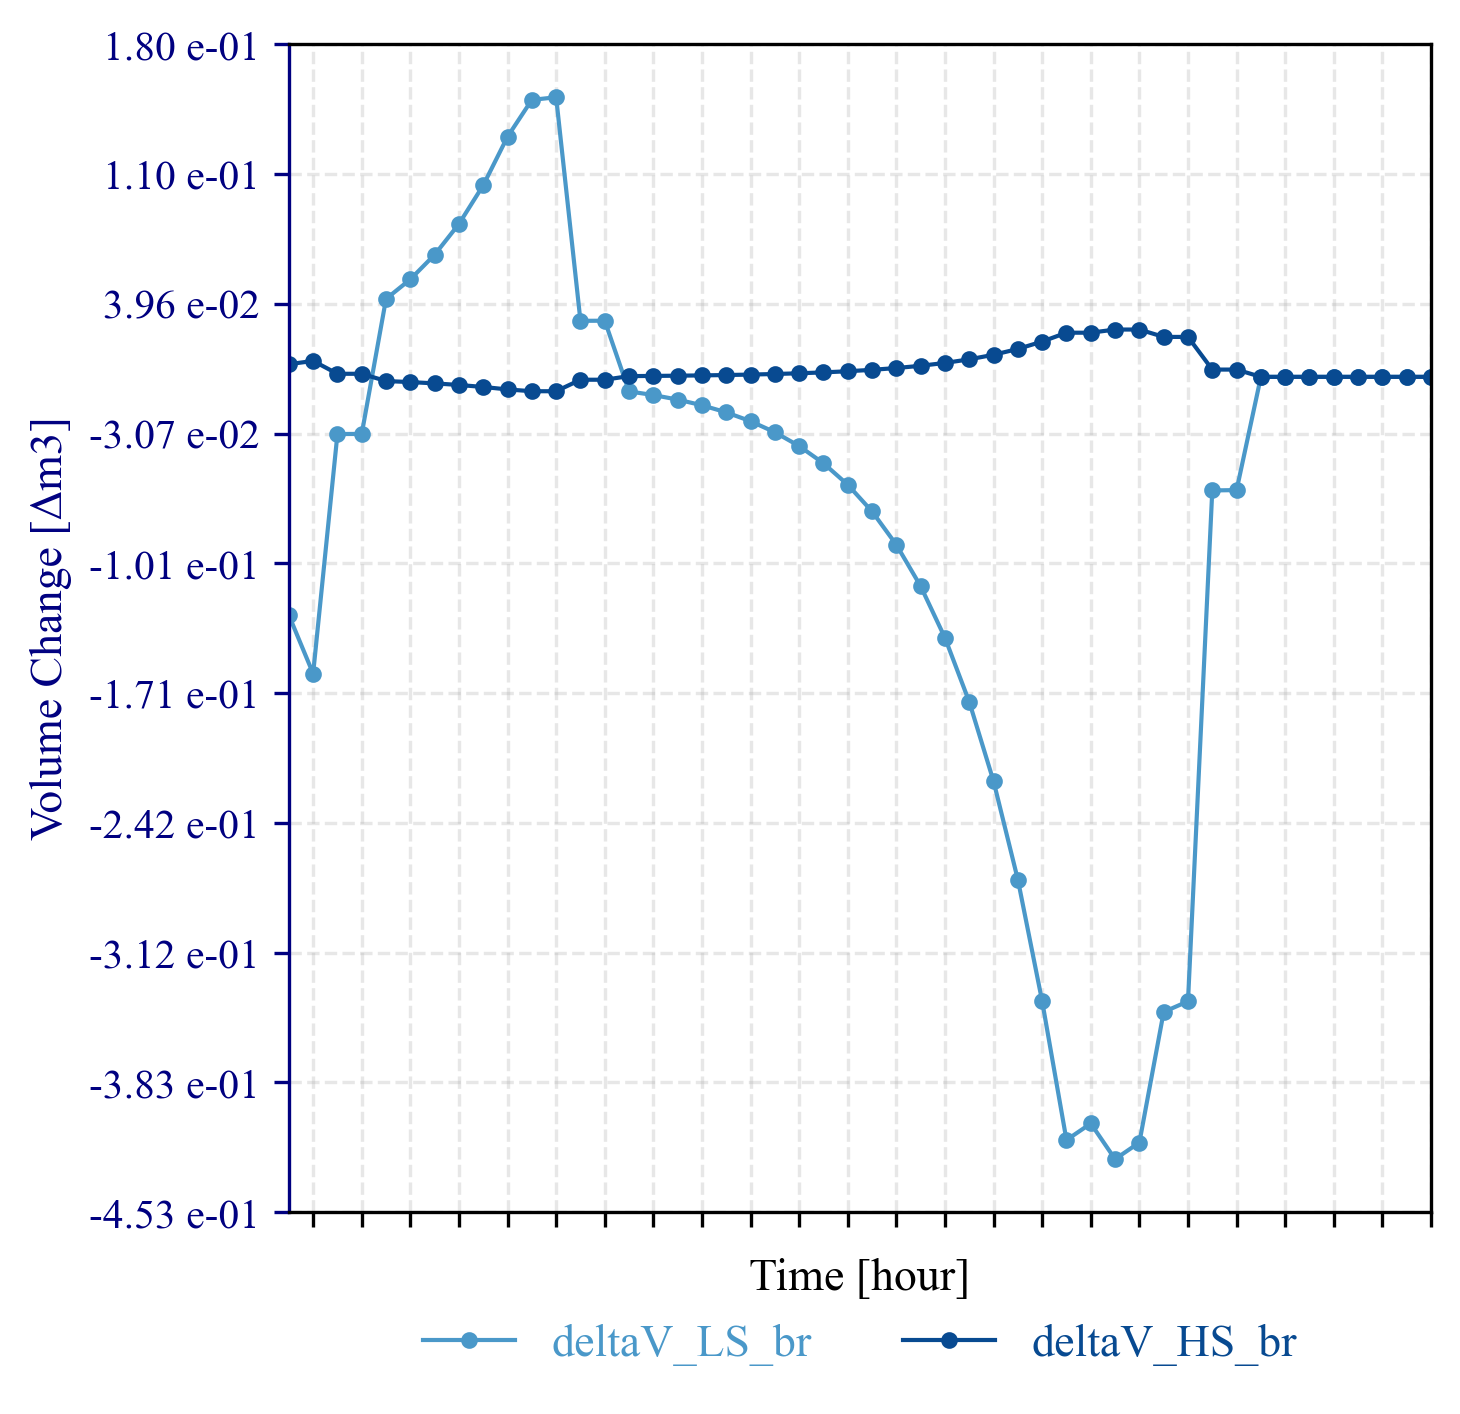

In [132]:
Figure_title = 'Brine Volume Adjustment'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['deltaV_LS_br', 'deltaV_HS_br'],
    left_label= 'Volume Change',
    left_units='[Δm3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

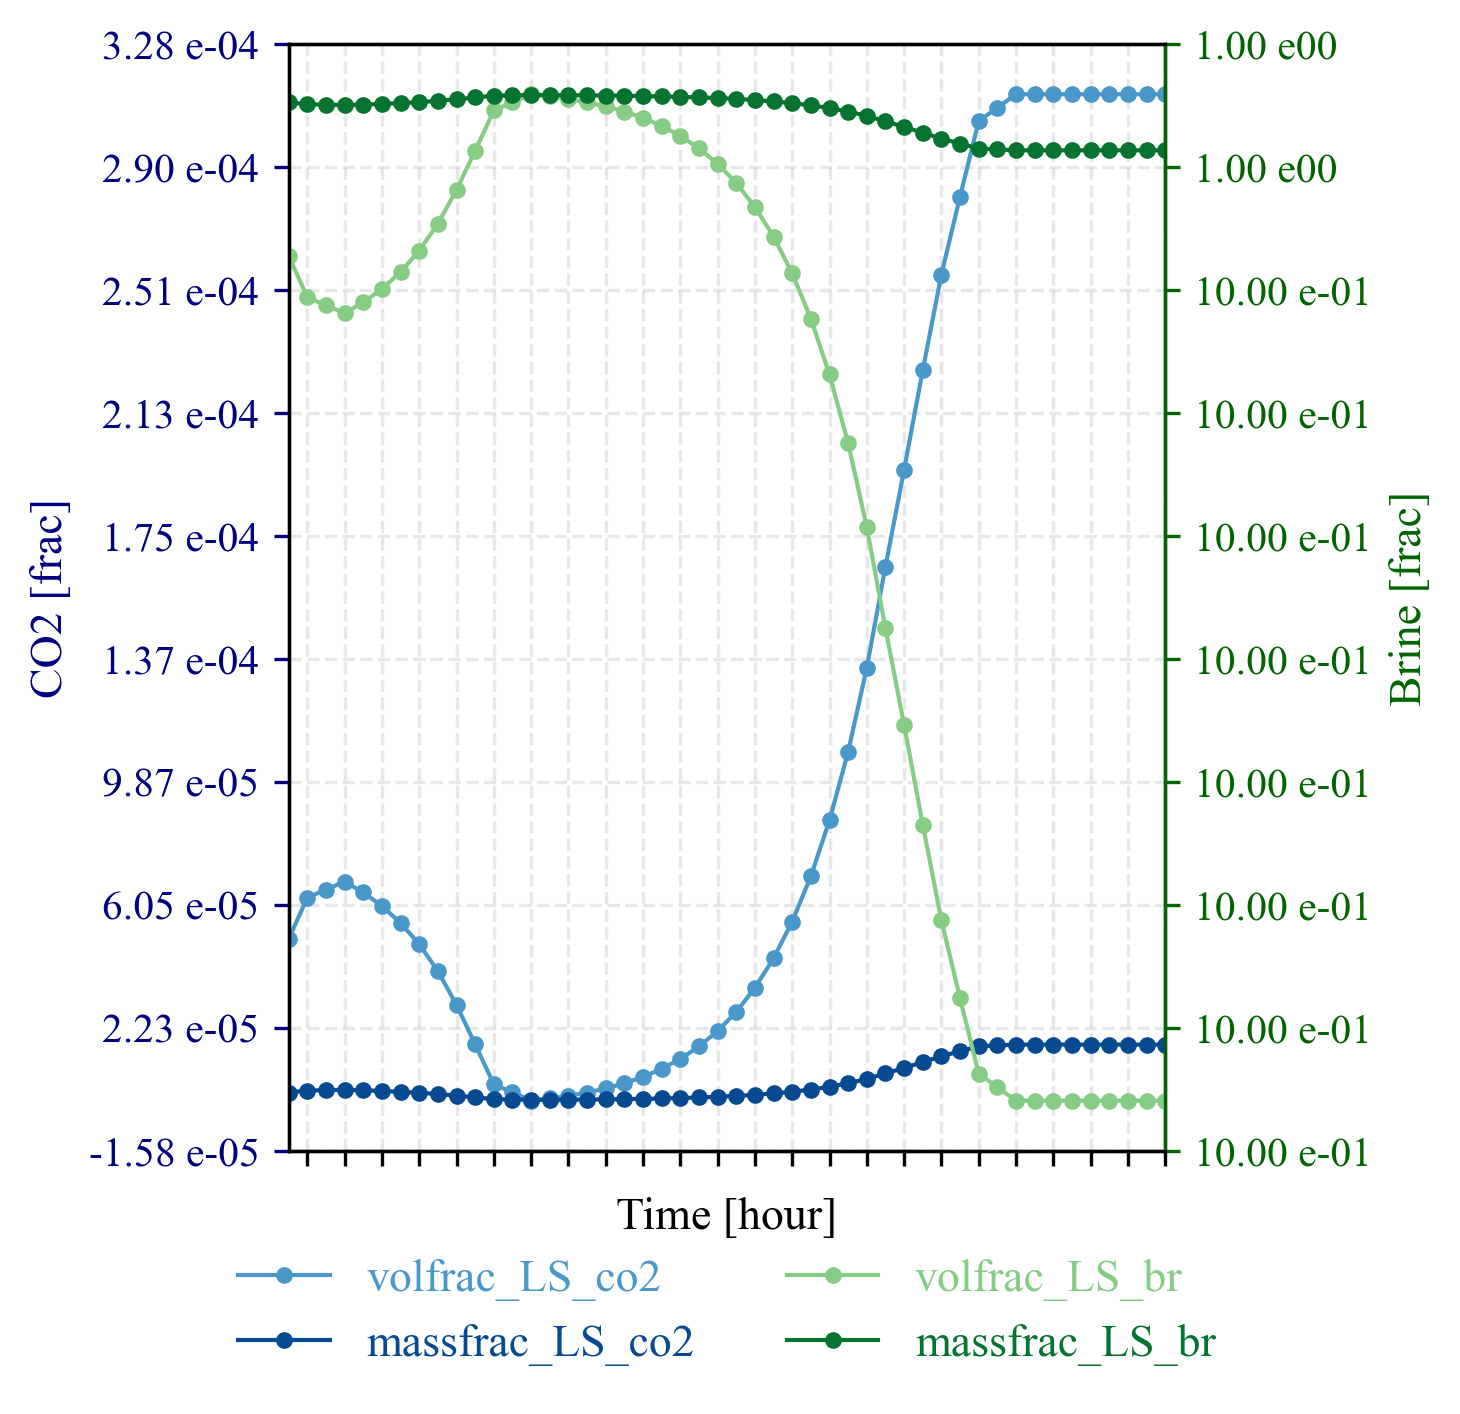

In [133]:
Figure_title = 'LS Binary Phase Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['volfrac_LS_co2','massfrac_LS_co2'],
    left_label= 'CO2',
    left_units='[frac]',
    series_right=['volfrac_LS_br','massfrac_LS_br'],
    right_label= 'Brine',
    right_units='[frac]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

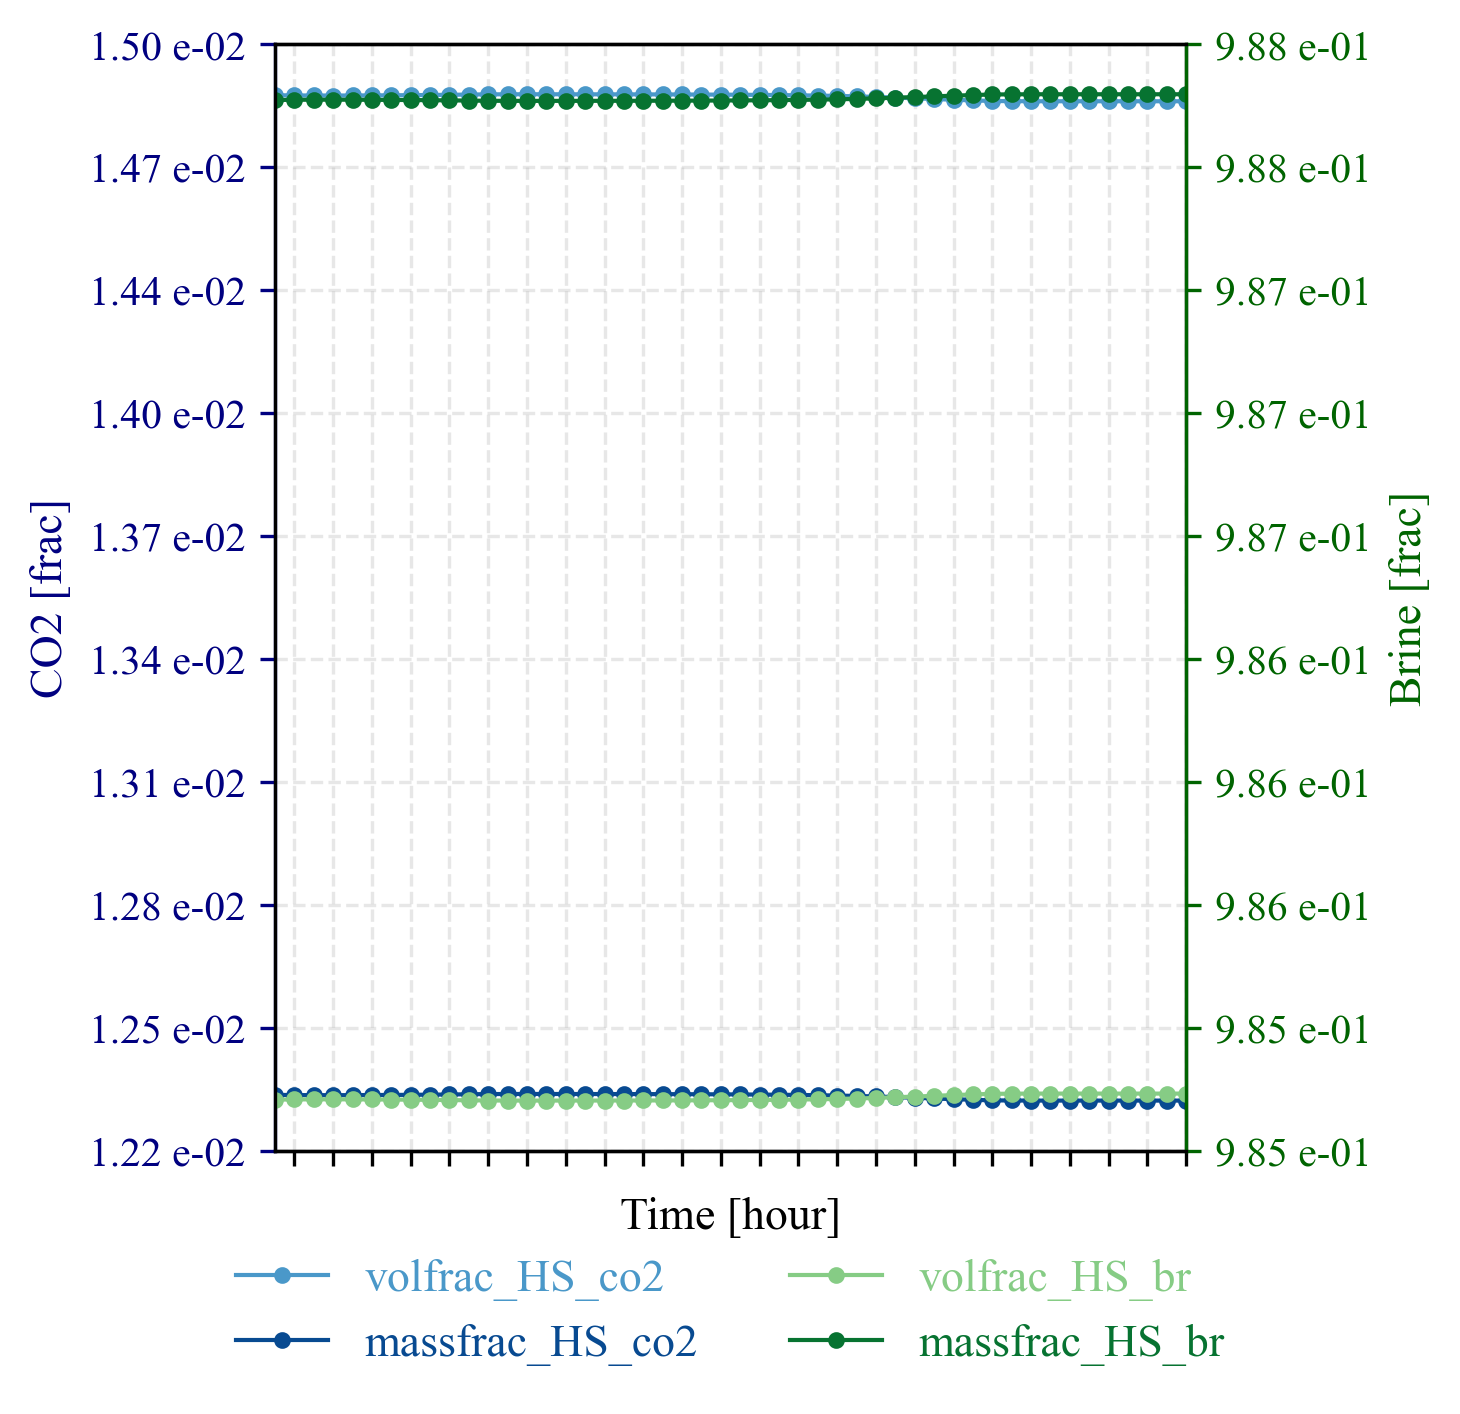

In [134]:
Figure_title = 'HS Binary Phase Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['volfrac_HS_co2','massfrac_HS_co2'],
    left_label= 'CO2',
    left_units='[frac]',
    series_right=['volfrac_HS_br','massfrac_HS_br'],
    right_label= 'Brine',
    right_units='[frac]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

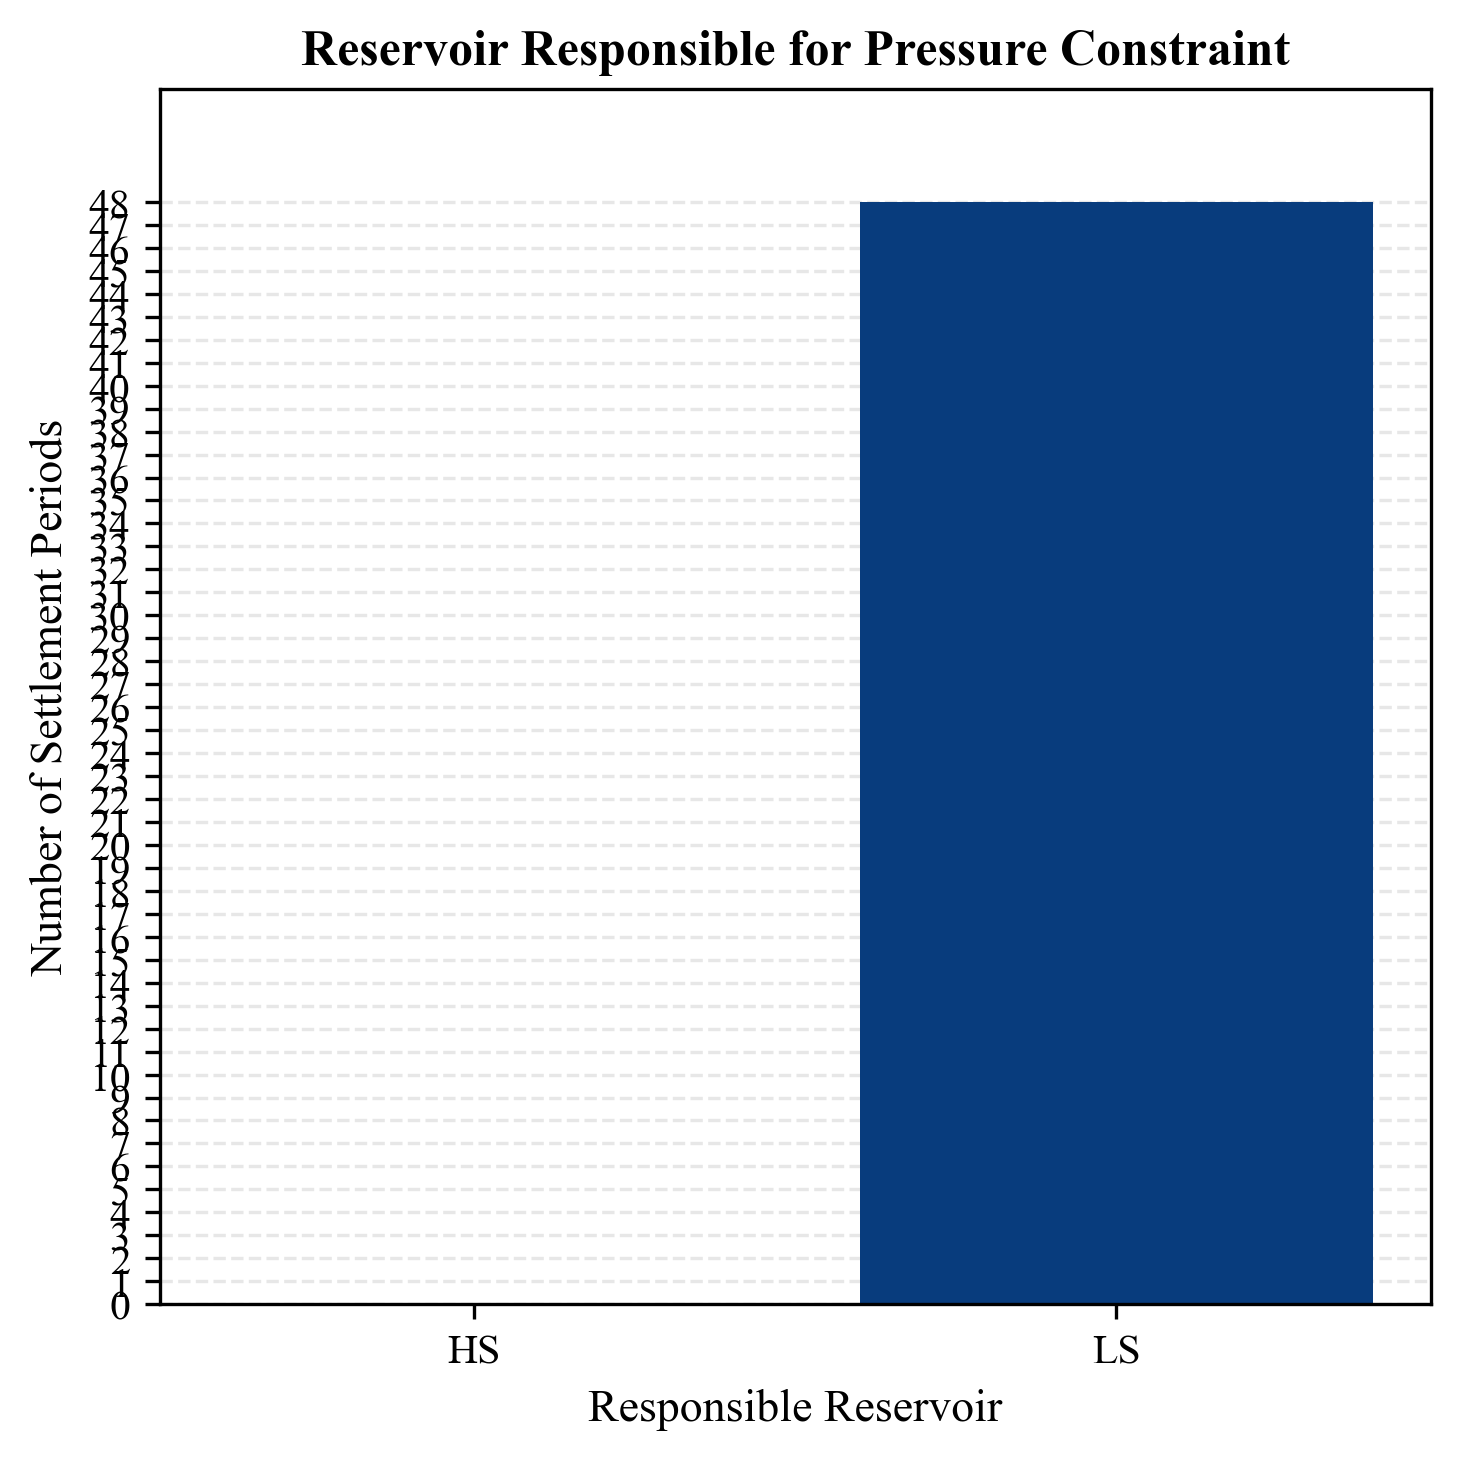

In [135]:
Figure_title = 'Reservoir Responsible for Pressure Constraint'

counts = dfQSS['reservoir_responsible_pressure_constraint'].value_counts(); HS_count = counts.get('HS', 0); LS_count = counts.get('LS', 0)
kpis = ['HS', 'LS']
y_data = [HS_count, LS_count]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); ax.set_xlabel('Responsible Reservoir'); ax.set_ylabel('Number of Settlement Periods'); ax.set_title(Figure_title)
y_max = max(y_data); ax.set_yticks(np.arange(0, y_max+1, 1))
plt.rcParams['font.family']    = 'serif'; plt.rcParams['font.serif']     = ['Times New Roman']; plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

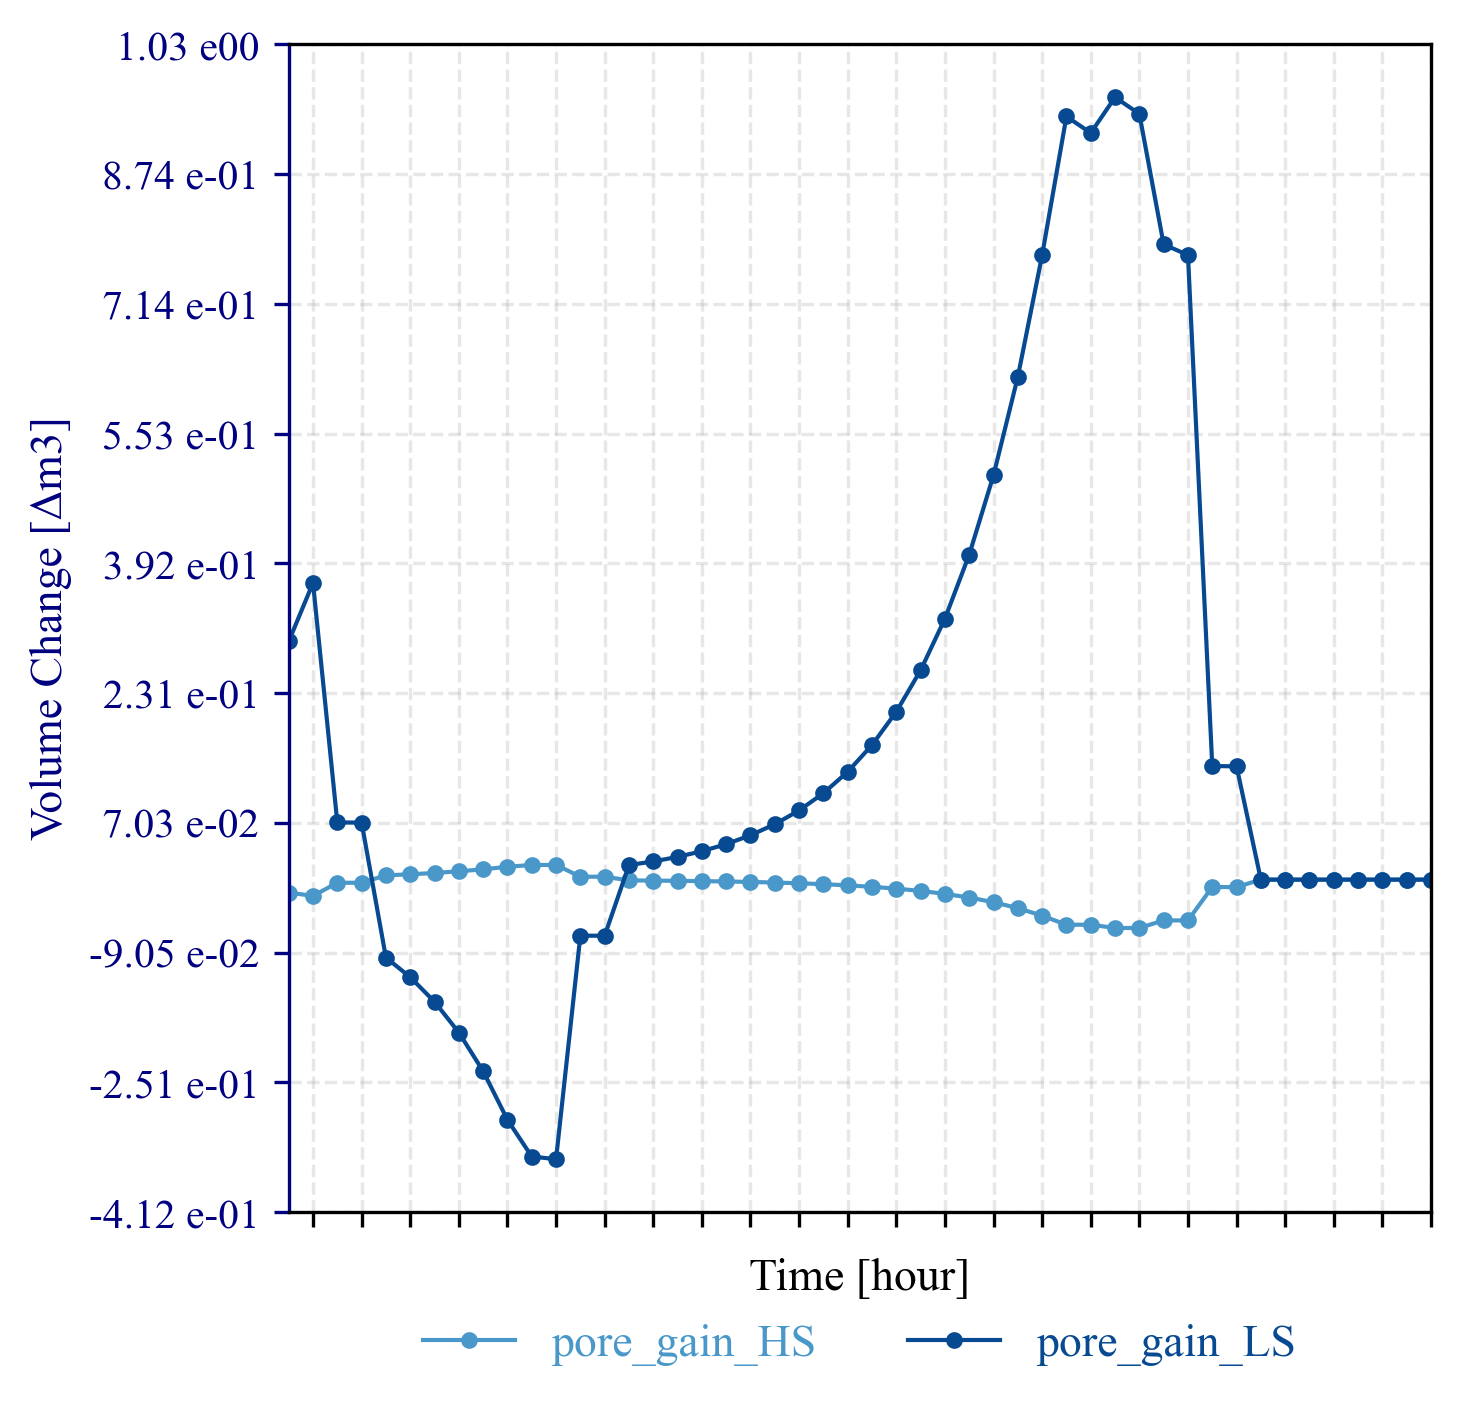

In [136]:
Figure_title = 'Pore Volume Gain'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['pore_gain_HS','pore_gain_LS'],
    left_label= 'Volume Change',
    left_units='[Δm3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

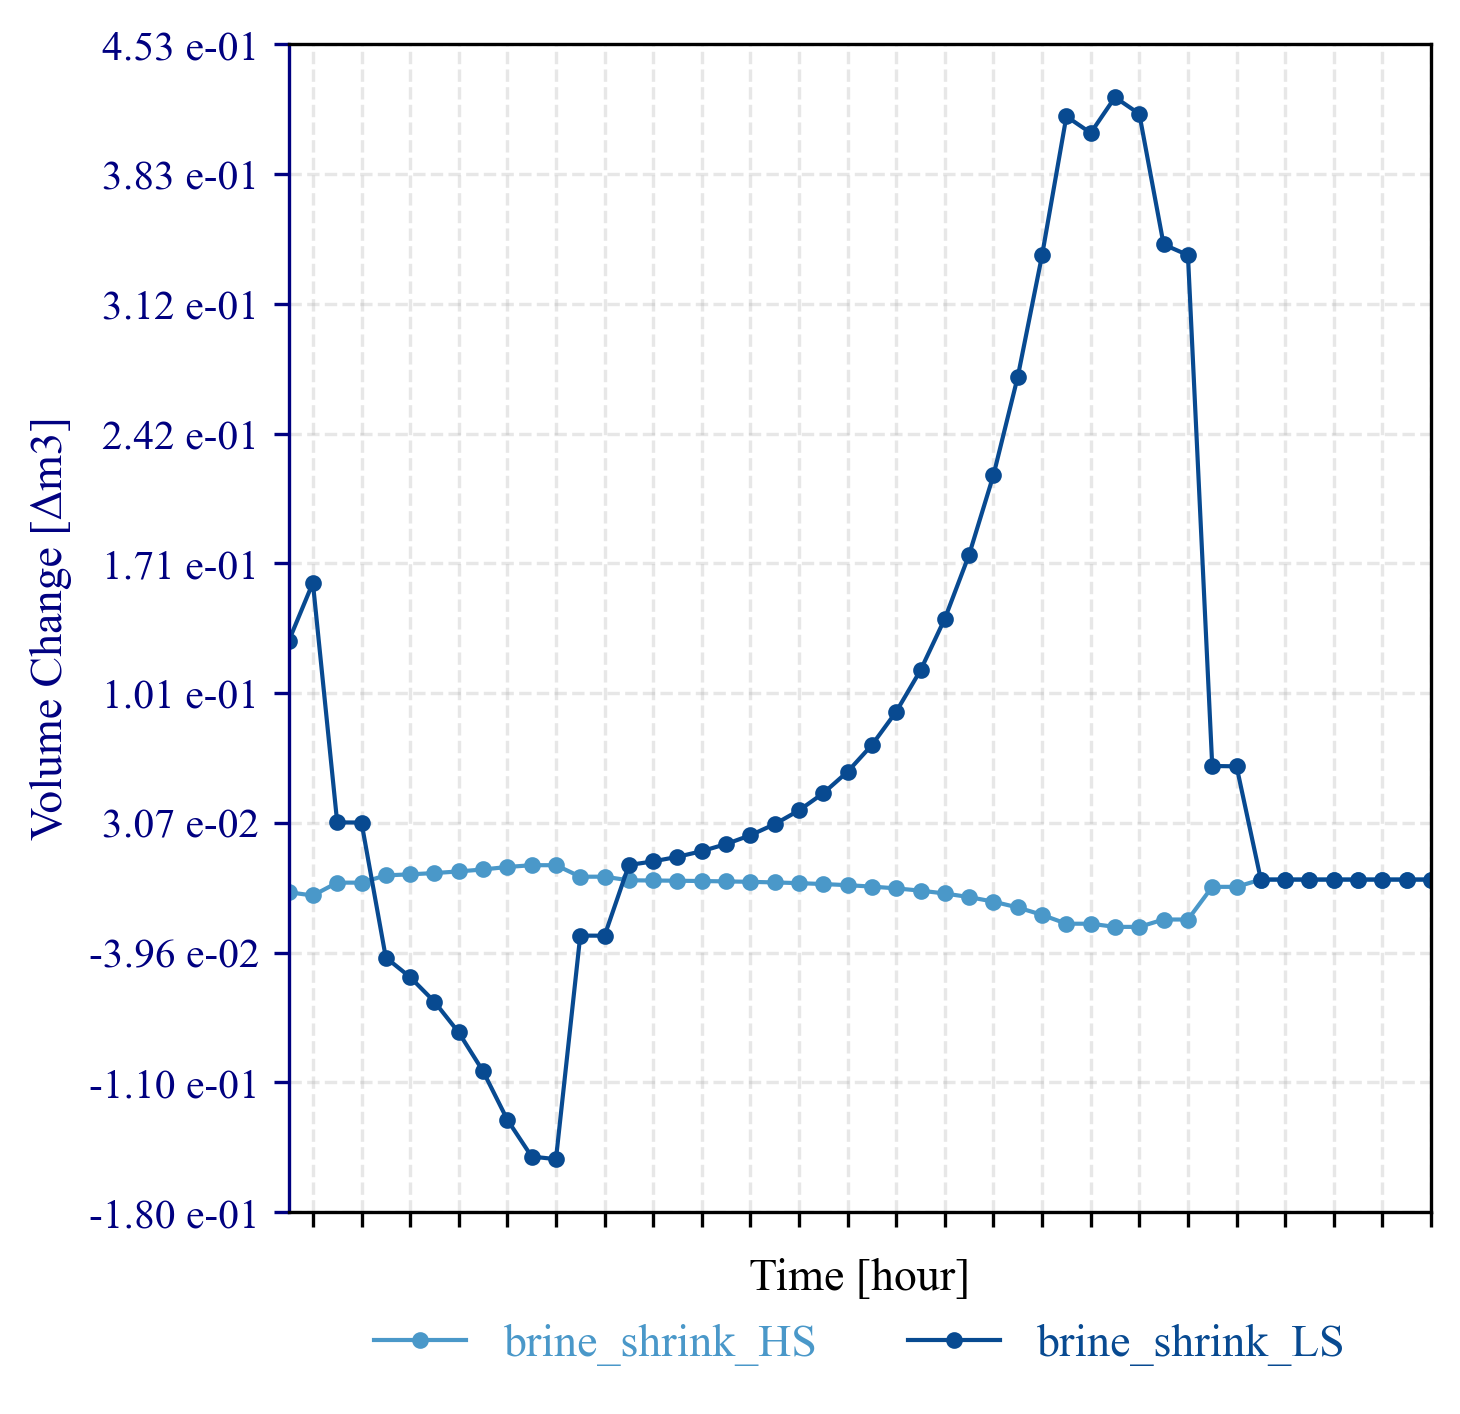

In [137]:
Figure_title = 'Brine Shrinkage'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['brine_shrink_HS','brine_shrink_LS'],
    left_label= 'Volume Change',
    left_units='[Δm3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

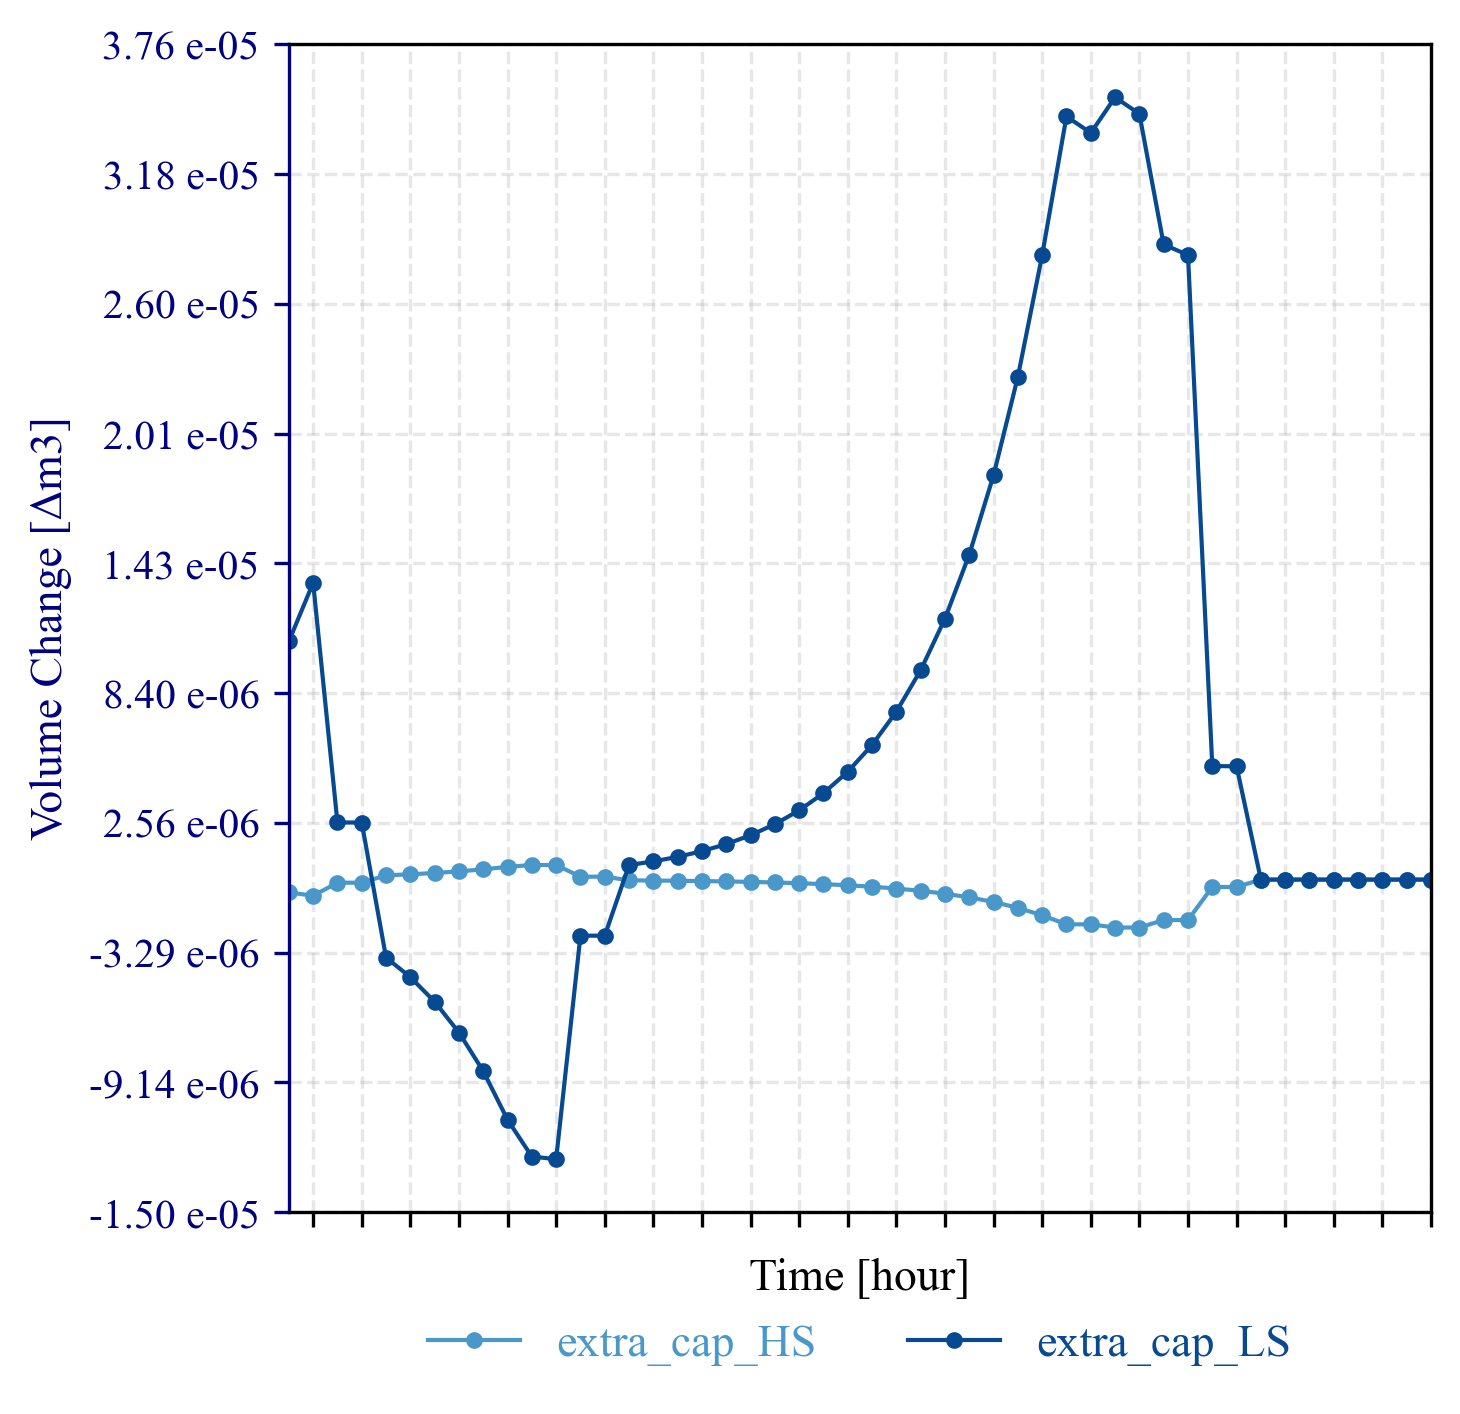

In [138]:
Figure_title = 'Extra Cap'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['extra_cap_HS','extra_cap_LS'],
    left_label= 'Volume Change',
    left_units='[Δm3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

In [139]:
import time; from openpyxl import load_workbook
total_runtime = time.time() - _start_time; total_runtime_mins = total_runtime/60; print(f"Simulation total runtime: {total_runtime_mins:.2f} minutes")
KPI_file_path = data_dir / f"{simulation_name}_dfKPI.xlsx"; wb = load_workbook(KPI_file_path); ws = wb.active; ws.append(["Simulation_runtime_mins", total_runtime_mins]); wb.save(KPI_file_path)

Simulation total runtime: 2.35 minutes
